# Investing 12 million $

By *Luca Comba*, *Mohamed Elshahawi*, *Arthur Kennedy*, *Charles Rehder* and *Roban Shrestha*

### TODO
- Insert Charlie's section
- Problem 6
- Clean up
- Write a common conclusion

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import StrMethodFormatter
import matplotlib.dates as mdates
import geopandas as gpd
import util
%matplotlib inline
sns.set(color_codes=True)

In [2]:
# Loading of the data
metro_us_top_tier = pd.read_csv("./data/Metro_zhvi_uc_sfrcondo_tier_0.67_1.0_sm_sa_month.csv")
sfr_df = pd.read_csv("./data/Metro_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_month.csv")

data_dir = './data/'
file_paths = {
    "inventory": os.path.join(data_dir, "Metro_invt_fs_uc_sfrcondo_sm_week.csv"),
    "sales": os.path.join(data_dir, "Metro_median_sale_price_uc_sfrcondo_sm_sa_week.csv"), #Median Sale Price
}

df = {key: pd.read_csv(path) for key, path in file_paths.items()}

inventory_df = df["inventory"]
sales_df = df["sales"]

# Luca's code
meadianSalePrices = pd.read_csv('./data/median_sale_prices_adjusted.csv')
forecastByZip = pd.read_csv('./data/forecast_zip.csv')

# Loading zip and state
# Source: https://www.census.gov/cgi-bin/geo/shapefiles/index.php
zip_codes = gpd.read_file("../data/tl_2024_us_zcta520/tl_2024_us_zcta520.shp")
us_states = gpd.read_file('../data/tl_2024_us_state/tl_2024_us_state.shp')

# Removing unincorporated territories
us_states = us_states[~us_states.STATEFP.isin(["72", "69", "60", "66", "78"])]

# Center to us continental
# Source: https://dev.to/oscarleo/how-to-create-data-maps-of-the-united-states-with-matplotlib-p9i
us_states = us_states.to_crs("ESRI:102003")

# Move column
col_to_move = us_states.pop('STUSPS')
us_states.insert(len(us_states.columns), 'STUSPS', col_to_move)

def translate_geometries(df, x, y, scale, rotate):
    df.loc[:, "geometry"] = df.geometry.translate(yoff=y, xoff=x)
    center = df.dissolve().centroid.iloc[0]
    df.loc[:, "geometry"] = df.geometry.scale(xfact=scale, yfact=scale, origin=center)
    df.loc[:, "geometry"] = df.geometry.rotate(rotate, origin=center)
    return df

def adjust_maps(df):
    df_main_land = df[~df.STATEFP.isin(["02", "15"])]
    df_alaska = df[df.STATEFP == "02"]
    df_hawaii = df[df.STATEFP == "15"]

    df_alaska = translate_geometries(df_alaska, 1300000, -4900000, 0.5, 32)
    df_hawaii = translate_geometries(df_hawaii, 5400000, -1500000, 1, 24)

    return pd.concat([df_main_land, df_alaska, df_hawaii])

us_states = adjust_maps(us_states)

# Market Trends in US real-estate market

Data is retrieved from [Zillow's Research data](https://www.zillow.com/research/data/) and following type from `Home Values` data.

Since we are interested in the market trends to decide which US real-estate market is doing best overall, initially getting the data of `Top Tier Time Series` data for all homes and `Single Family Home` from Zillow's Home Values data.

As per Zillow's webpage, the ZHVI for Top Tier Time Series provides the home values within 65th to 95th percentile range for given region.

The options for the type of Geography is given as follows:
* Metro and U.S.
* State
* County
* City

We are going to perform analysis of `Metro & US` geography for Top Tier Time Series data with the following data types:
1. All Homes - Top Tier Time Series
2. Single-Family Homes Time Series

Note:
As per Zillow's webpage, the CSV files uploaded in the server are updated on the 12th of each month. The data used in this analysis was downloaded on 11/27/2024 which should have latest data for this project before the due.

## 1. Data Type: ZHVI All Homes - Top Tier Time Series($)
## Geography: Metro & U.S.

In [3]:
# display first five rows of data
print("US metro Top tier dataframe's first 5 rows:")
display(metro_us_top_tier.head(5))

US metro Top tier dataframe's first 5 rows:


,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
0,102001,0,United States,country,NaN,236310.307821,236838.023959,237480.193801,238850.421544,240412.320519,...,6.617035e+05,6.627986e+05,6.656263e+05,6.696100e+05,6.731204e+05,6.746329e+05,6.752572e+05,6.759704e+05,6.773754e+05,6.789914e+05
1,394913,1,"New York, NY",msa,NY,422779.470763,424569.458990,426373.228624,430078.225391,433925.761544,...,1.040112e+06,1.044140e+06,1.051909e+06,1.061940e+06,1.070822e+06,1.075952e+06,1.079291e+06,1.083236e+06,1.087985e+06,1.091999e+06
2,753899,2,"Los Angeles, CA",msa,CA,408845.886049,410475.727683,412497.750632,416559.900109,420908.271857,...,1.538312e+06,1.531557e+06,1.529231e+06,1.535570e+06,1.546364e+06,1.551836e+06,1.557527e+06,1.564954e+06,1.576026e+06,1.585157e+06
3,394463,3,"Chicago, IL",msa,IL,294798.619006,295160.327624,295764.309500,297253.846121,298995.626064,...,5.029052e+05,5.050047e+05,5.087715e+05,5.132149e+05,5.164459e+05,5.179396e+05,5.185213e+05,5.194622e+05,5.209806e+05,5.227783e+05
4,394514,4,"Dallas, TX",msa,TX,234470.520983,234474.949985,234523.178926,234692.071349,234965.454079,...,6.038140e+05,6.057093e+05,6.088988e+05,6.120574e+05,6.134658e+05,6.129716e+05,6.114534e+05,6.104536e+05,6.104705e+05,6.112888e+05


In [4]:
# display last five rows of data
print("US metro Top tier dataframe's last 5 rows:")
display(metro_us_top_tier.tail(5))

US metro Top tier dataframe's last 5 rows:


,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
890,753929,935,"Zapata, TX",msa,TX,NaN,NaN,NaN,NaN,NaN,...,221914.095432,220287.910570,220192.537576,222203.281152,224501.537093,225784.071770,225948.532152,225991.175537,226064.814808,225879.321361
891,394743,936,"Ketchikan, AK",msa,AK,NaN,NaN,NaN,NaN,NaN,...,548360.287886,547769.478967,550368.767534,552969.820826,555076.306477,554859.636217,553466.035413,553438.132178,555357.238979,558374.377510
892,753874,937,"Craig, CO",msa,CO,171168.872755,171482.922883,171861.387668,172285.233625,172695.40665,...,394896.584283,393944.116716,394206.291399,395435.448506,397281.736381,398265.278118,399296.985077,400193.153531,402053.971208,404091.754361
893,395188,938,"Vernon, TX",msa,TX,NaN,NaN,NaN,NaN,NaN,...,179575.371395,180865.594222,182899.970265,184752.274354,185410.355676,185072.435743,184340.334684,183551.676624,182053.962201,180243.174764
894,394767,939,"Lamesa, TX",msa,TX,NaN,NaN,NaN,NaN,NaN,...,173196.777417,172352.641283,172959.096318,173663.574855,174270.220375,174816.753206,175129.003722,174897.405214,174250.740731,173417.359801


__Checking the types of data__

We are checking the datatypes for each columns to see if the datatypes that we are interested (in this case value of home in given datetime) is numerical.

If the columns of interests are not numerical, we would need to convert them to respective numerical datatypes such as int or float.

In [5]:
print("US metro Top tier dataframe's data types of all columns:")
display(metro_us_top_tier.dtypes)

US metro Top tier dataframe's data types of all columns:


RegionID        int64
SizeRank        int64
RegionName     object
RegionType     object
StateName      object
               ...   
2024-06-30    float64
2024-07-31    float64
2024-08-31    float64
2024-09-30    float64
2024-10-31    float64
Length: 303, dtype: object

__Dropping irrelevant columns__

We are mostly interested in the `RegionName` and the home values in the specified region.
Hence, we are dropping the columns that are note relevant to our analysis, such as `RegionID`, `SizeRank`, `RegionType`, `StateName`.


In [6]:
metro_us_top_tier = metro_us_top_tier.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName'])

__Setting RegionName as index__

For data analysis, we are setting `RegionName` as the index which will make it easier to work with numerical columns only as values.

In [7]:
metro_us_top_tier.set_index('RegionName', inplace=True)
print("US metro Top tier dataframe's first 5 rows after setting RegionName as index:")
display(metro_us_top_tier.head())

US metro Top tier dataframe's first 5 rows after setting RegionName as index:


,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
RegionName,,,,,,,,,,,,,,,,,,,,,
United States,236310.307821,236838.023959,237480.193801,238850.421544,240412.320519,242092.423675,243880.472278,245788.568877,247754.637581,249705.214888,...,6.617035e+05,6.627986e+05,6.656263e+05,6.696100e+05,6.731204e+05,6.746329e+05,6.752572e+05,6.759704e+05,6.773754e+05,6.789914e+05
"New York, NY",422779.470763,424569.458990,426373.228624,430078.225391,433925.761544,438227.180542,442864.842513,447790.344507,452751.695645,457642.186083,...,1.040112e+06,1.044140e+06,1.051909e+06,1.061940e+06,1.070822e+06,1.075952e+06,1.079291e+06,1.083236e+06,1.087985e+06,1.091999e+06
"Los Angeles, CA",408845.886049,410475.727683,412497.750632,416559.900109,420908.271857,425224.082320,429611.845129,433808.864387,437713.533947,441178.383748,...,1.538312e+06,1.531557e+06,1.529231e+06,1.535570e+06,1.546364e+06,1.551836e+06,1.557527e+06,1.564954e+06,1.576026e+06,1.585157e+06
"Chicago, IL",294798.619006,295160.327624,295764.309500,297253.846121,298995.626064,300909.949315,302873.303989,305500.525715,308584.756742,312185.145850,...,5.029052e+05,5.050047e+05,5.087715e+05,5.132149e+05,5.164459e+05,5.179396e+05,5.185213e+05,5.194622e+05,5.209806e+05,5.227783e+05
"Dallas, TX",234470.520983,234474.949985,234523.178926,234692.071349,234965.454079,235196.340543,235446.078093,235910.681916,236552.790322,237267.576760,...,6.038140e+05,6.057093e+05,6.088988e+05,6.120574e+05,6.134658e+05,6.129716e+05,6.114534e+05,6.104536e+05,6.104705e+05,6.112888e+05


__Checking the shape of the DataFrame__

In [8]:
metro_us_top_tier.shape

(895, 298)

__Checking for duplicate data in the DataFrame__

In [9]:
duplicate_rows_df = metro_us_top_tier[metro_us_top_tier.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (0, 298)


Since we do not have duplicated data in the dataframe, no need to remove duplicate data.

___

Now, check the counts of all Regions to see if we have data for all dates.

In [10]:
metro_us_top_tier.count(axis=1)

RegionName
United States      298
New York, NY       298
Los Angeles, CA    298
Chicago, IL        298
Dallas, TX         297
                  ... 
Zapata, TX         181
Ketchikan, AK      234
Craig, CO          298
Vernon, TX         185
Lamesa, TX         163
Length: 895, dtype: int64

__Handling the missing/null values if needed__

It seems like some of the data are missing in some regions.
Lets check to see the number of missing data for each region.

In [11]:
print(metro_us_top_tier.T.isnull().sum())

RegionName
United States        0
New York, NY         0
Los Angeles, CA      0
Chicago, IL          0
Dallas, TX           1
                  ... 
Zapata, TX         117
Ketchikan, AK       64
Craig, CO            0
Vernon, TX         113
Lamesa, TX         135
Length: 895, dtype: int64


Lets count the total rows to see how many rows are missing data.

In [12]:
region_df = metro_us_top_tier.T
metro_us_top_tier.loc[region_df.isnull().sum() > 150]

,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
RegionName,,,,,,,,,,,,,,,,,,,,,
"Hilo, HI",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000468e+06,9.986989e+05,1.003166e+06,1.012226e+06,1.022917e+06,1.027989e+06,1.028923e+06,1.029855e+06,1.031738e+06,1.033272e+06
"Burlington, NC",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.002047e+05,4.005167e+05,4.023245e+05,4.047573e+05,4.074483e+05,4.087861e+05,4.090008e+05,4.085119e+05,4.080807e+05,4.084431e+05
"San Angelo, TX",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.567569e+05,3.576660e+05,3.595468e+05,3.612262e+05,3.623152e+05,3.624865e+05,3.621408e+05,3.620969e+05,3.627970e+05,3.644381e+05
"Lumberton, NC",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.303530e+05,2.301403e+05,2.307762e+05,2.328270e+05,2.348773e+05,2.363203e+05,2.362519e+05,2.356716e+05,2.349689e+05,2.351128e+05
"Victoria, TX",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.436488e+05,3.435775e+05,3.450800e+05,3.471264e+05,3.487924e+05,3.491862e+05,3.484942e+05,3.483847e+05,3.487784e+05,3.496772e+05
"Key West, FL",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.015859e+06,2.020568e+06,2.026080e+06,2.034349e+06,2.039820e+06,2.035310e+06,2.025303e+06,2.018056e+06,2.016143e+06,2.012026e+06
"Hobbs, NM",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.716029e+05,2.721992e+05,2.733475e+05,2.745087e+05,2.742458e+05,2.731365e+05,2.717938e+05,2.706775e+05,2.700474e+05,2.700747e+05
"Alamogordo, NM",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.413533e+05,3.400226e+05,3.399166e+05,3.402580e+05,3.411700e+05,3.420395e+05,3.434910e+05,3.456921e+05,3.483749e+05,3.519506e+05
"Albemarle, NC",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.164754e+05,4.158366e+05,4.165025e+05,4.190411e+05,4.227899e+05,4.256493e+05,4.275904e+05,4.289709e+05,4.303864e+05,4.319679e+05


Above result shows that 52 regions are missing more than half of the column's data 150 out of 298 columns.

It would be better to skip those dates if half of the data is missing on those dates.

Lets check to see which dates have enough data for analysis.

In [13]:
all_count_by_date = metro_us_top_tier.isnull().sum()
print(all_count_by_date[all_count_by_date > 0])

2000-01-31    461
2000-02-29    460
2000-03-31    460
2000-04-30    458
2000-05-31    456
             ... 
2019-04-30      1
2020-09-30     11
2020-10-31      8
2020-11-30      6
2022-09-30      1
Length: 236, dtype: int64


Note that out of 298 columns, 236 columns have missing data. So, we cannot drop columns with null values.
___
Now, looking at the transposed dataframe to look at the total non-null values by Region name.

In [14]:
metro_us_top_tier.T.loc[metro_us_top_tier.isnull().sum() > 0]

RegionName,United States,"New York, NY","Los Angeles, CA","Chicago, IL","Dallas, TX","Houston, TX","Washington, DC","Philadelphia, PA","Miami, FL","Atlanta, GA",...,"Atchison, KS","Fairfield, IA","Vermillion, SD","Sweetwater, TX","Pecos, TX","Zapata, TX","Ketchikan, AK","Craig, CO","Vernon, TX","Lamesa, TX"
2000-01-31,236310.307821,4.227795e+05,4.088459e+05,294798.619006,234470.520983,234754.433650,309106.681840,217459.412925,239504.473875,269311.443535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,171168.872755,NaN,NaN
2000-02-29,236838.023959,4.245695e+05,4.104757e+05,295160.327624,234474.949985,234842.759817,309466.569298,218019.393479,240170.656610,269959.508530,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,171482.922883,NaN,NaN
2000-03-31,237480.193801,4.263732e+05,4.124978e+05,295764.309500,234523.178926,234702.488535,310077.513689,218396.982476,240870.838621,270693.043281,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,171861.387668,NaN,NaN
2000-04-30,238850.421544,4.300782e+05,4.165599e+05,297253.846121,234692.071349,234873.730241,311453.270897,219337.083931,242279.530495,272259.004540,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172285.233625,NaN,NaN
2000-05-31,240412.320519,4.339258e+05,4.209083e+05,298995.626064,234965.454079,235008.901195,313419.631083,220276.579865,243646.162216,273970.499620,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172695.406650,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-30,470400.201245,8.980153e+05,1.064949e+06,407989.230280,404612.033360,368767.864300,693304.048293,411684.634194,511779.316867,401434.848858,...,221298.877164,233772.450610,267953.859229,175269.033225,264923.108822,209308.925463,470399.382205,265707.781968,133266.903404,145021.250285
2020-09-30,495932.360295,8.869814e+05,1.115123e+06,406763.058893,419831.512930,380322.237541,729202.158214,431679.857479,530855.057264,418844.248872,...,244442.270581,248376.804119,282414.174751,181458.783949,304466.151078,227276.131841,500051.156353,291047.697151,147523.366297,167183.055935
2020-10-31,502569.305754,8.919172e+05,1.136773e+06,410456.236302,424766.092980,383795.173720,737885.383597,436706.569903,536444.654674,423878.167125,...,246934.544764,251717.889220,286802.561034,183071.013266,308022.712315,228418.517855,505886.574701,294967.257764,149823.242931,168707.070393
2020-11-30,510274.276335,8.993448e+05,1.160738e+06,415024.163742,430331.323912,387771.457608,747627.383935,442914.433978,543359.551162,429590.955718,...,250671.285523,254893.938786,292090.840624,184676.864300,310442.023914,229302.360180,511735.288199,299299.814490,151734.270568,170167.182892


From above data 236 out of 298 rows are missing at least 1 record.

Lets check to see how many rows are missing about half of the data.

In [15]:
print(metro_us_top_tier.isnull().sum() > 400)
metro_us_top_tier.T.loc[metro_us_top_tier.isnull().sum() > 400]

2000-01-31     True
2000-02-29     True
2000-03-31     True
2000-04-30     True
2000-05-31     True
              ...  
2024-06-30    False
2024-07-31    False
2024-08-31    False
2024-09-30    False
2024-10-31    False
Length: 298, dtype: bool


RegionName,United States,"New York, NY","Los Angeles, CA","Chicago, IL","Dallas, TX","Houston, TX","Washington, DC","Philadelphia, PA","Miami, FL","Atlanta, GA",...,"Atchison, KS","Fairfield, IA","Vermillion, SD","Sweetwater, TX","Pecos, TX","Zapata, TX","Ketchikan, AK","Craig, CO","Vernon, TX","Lamesa, TX"
2000-01-31,236310.307821,422779.470763,408845.886049,294798.619006,234470.520983,234754.433650,309106.681840,217459.412925,239504.473875,269311.443535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,171168.872755,NaN,NaN
2000-02-29,236838.023959,424569.458990,410475.727683,295160.327624,234474.949985,234842.759817,309466.569298,218019.393479,240170.656610,269959.508530,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,171482.922883,NaN,NaN
2000-03-31,237480.193801,426373.228624,412497.750632,295764.309500,234523.178926,234702.488535,310077.513689,218396.982476,240870.838621,270693.043281,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,171861.387668,NaN,NaN
2000-04-30,238850.421544,430078.225391,416559.900109,297253.846121,234692.071349,234873.730241,311453.270897,219337.083931,242279.530495,272259.004540,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172285.233625,NaN,NaN
2000-05-31,240412.320519,433925.761544,420908.271857,298995.626064,234965.454079,235008.901195,313419.631083,220276.579865,243646.162216,273970.499620,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172695.406650,NaN,NaN
2000-06-30,242092.423675,438227.180542,425224.082320,300909.949315,235196.340543,235395.264043,315768.485620,221421.974647,245010.750816,275785.766414,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173115.715035,NaN,NaN
2000-07-31,243880.472278,442864.842513,429611.845129,302873.303989,235446.078093,235726.058394,318695.271269,222613.503336,246451.625281,277602.214335,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,174364.822255,NaN,NaN
2000-08-31,245788.568877,447790.344507,433808.864387,305500.525715,235910.681916,236179.141763,322133.392951,223822.022984,247934.835658,279516.746749,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,175740.501952,NaN,NaN
2000-09-30,247754.637581,452751.695645,437713.533947,308584.756742,236552.790322,236721.453613,325620.602152,225075.026635,249518.825713,281500.584154,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,176603.313256,NaN,NaN
2000-10-31,249705.214888,457642.186083,441178.383748,312185.145850,237267.576760,237072.987184,329030.855612,226314.064171,251110.509547,283539.721545,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,176714.602536,NaN,NaN


Looking at the above data, 48 rows are missing at least 400 records.

And looking at the trends, it seems that the early 2000s is missing a lot of data, which would make sense since the data may not have been collected around that timeframe.

Because of the high number of missing records, instead of dropping all the records in this case, it might be better to fill the n/a or null values with `backfill` or `bfill` method from pandas [fillna method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html) as we are missing older data. Eventually, we would not miss the trend for the regions that have actual data.

In [16]:
metro_us_top_tier.bfill(axis=1, inplace=True)

Finally, verify if all null values have been filled.

In [17]:
print(metro_us_top_tier.isnull().sum())

2000-01-31    0
2000-02-29    0
2000-03-31    0
2000-04-30    0
2000-05-31    0
             ..
2024-06-30    0
2024-07-31    0
2024-08-31    0
2024-09-30    0
2024-10-31    0
Length: 298, dtype: int64


In [18]:
metro_us_top_tier.count()

2000-01-31    895
2000-02-29    895
2000-03-31    895
2000-04-30    895
2000-05-31    895
             ... 
2024-06-30    895
2024-07-31    895
2024-08-31    895
2024-09-30    895
2024-10-31    895
Length: 298, dtype: int64

__Get Descriptive Statistics__

After the data has been cleaned up, get descriptive statistics from the data:

* By Date:

In [19]:
metro_us_top_tier.describe()

,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
count,8.950000e+02,8.950000e+02,8.950000e+02,8.950000e+02,8.950000e+02,8.950000e+02,8.950000e+02,8.950000e+02,8.950000e+02,8.950000e+02,...,8.950000e+02,8.950000e+02,8.950000e+02,8.950000e+02,8.950000e+02,8.950000e+02,8.950000e+02,8.950000e+02,8.950000e+02,8.950000e+02
mean,2.244999e+05,2.246547e+05,2.248497e+05,2.252773e+05,2.257697e+05,2.263107e+05,2.268796e+05,2.274900e+05,2.281220e+05,2.287393e+05,...,4.561163e+05,4.564667e+05,4.582145e+05,4.608882e+05,4.632947e+05,4.644340e+05,4.648532e+05,4.653857e+05,4.663054e+05,4.675193e+05
std,1.178513e+05,1.179714e+05,1.181404e+05,1.185220e+05,1.189697e+05,1.194897e+05,1.200409e+05,1.206763e+05,1.213454e+05,1.219931e+05,...,3.344519e+05,3.346980e+05,3.363036e+05,3.388711e+05,3.413754e+05,3.418937e+05,3.416597e+05,3.417138e+05,3.430359e+05,3.439965e+05
min,9.541612e+04,9.563501e+04,9.579942e+04,9.611036e+04,9.636357e+04,9.658167e+04,9.683453e+04,9.707890e+04,9.747264e+04,9.799395e+04,...,1.190895e+05,1.184370e+05,1.186096e+05,1.195186e+05,1.208685e+05,1.214954e+05,1.215936e+05,1.194656e+05,1.175563e+05,1.164843e+05
25%,1.620948e+05,1.622639e+05,1.625076e+05,1.626781e+05,1.634778e+05,1.641569e+05,1.642050e+05,1.645884e+05,1.649882e+05,1.655102e+05,...,2.896991e+05,2.901200e+05,2.918698e+05,2.930859e+05,2.942465e+05,2.947793e+05,2.953982e+05,2.963095e+05,2.964365e+05,2.973400e+05
50%,1.993615e+05,1.994510e+05,1.995772e+05,1.999413e+05,1.998811e+05,2.001526e+05,1.998287e+05,2.001526e+05,2.008191e+05,2.008908e+05,...,3.681630e+05,3.691564e+05,3.701972e+05,3.723249e+05,3.741403e+05,3.746193e+05,3.754770e+05,3.755848e+05,3.769496e+05,3.780473e+05
75%,2.502948e+05,2.502948e+05,2.502948e+05,2.507255e+05,2.512161e+05,2.514968e+05,2.514968e+05,2.514968e+05,2.523231e+05,2.527323e+05,...,4.981236e+05,4.985424e+05,5.006858e+05,5.033250e+05,5.060890e+05,5.078161e+05,5.075082e+05,5.079142e+05,5.075861e+05,5.096878e+05
max,1.720427e+06,1.720427e+06,1.720427e+06,1.720427e+06,1.720427e+06,1.720427e+06,1.720427e+06,1.720427e+06,1.720427e+06,1.720427e+06,...,3.941395e+06,3.942331e+06,3.958731e+06,3.989273e+06,4.011914e+06,3.992887e+06,3.946338e+06,3.903833e+06,3.895642e+06,3.896277e+06


* By Region:

In [20]:
metro_us_top_tier.T.describe()

RegionName,United States,"New York, NY","Los Angeles, CA","Chicago, IL","Dallas, TX","Houston, TX","Washington, DC","Philadelphia, PA","Miami, FL","Atlanta, GA",...,"Atchison, KS","Fairfield, IA","Vermillion, SD","Sweetwater, TX","Pecos, TX","Zapata, TX","Ketchikan, AK","Craig, CO","Vernon, TX","Lamesa, TX"
count,298.000000,2.980000e+02,2.980000e+02,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,...,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000
mean,414866.070577,7.936197e+05,9.089712e+05,404553.548107,340397.843345,324159.870904,626801.058278,384513.342114,476426.645585,363931.952202,...,216587.467533,216473.481517,253771.924621,157145.466077,240120.333356,189306.133768,406848.260099,254149.541120,128883.340326,127917.110915
std,112721.944142,1.525320e+05,2.905960e+05,55911.301645,113552.444567,79847.589233,144671.503658,85027.318400,158625.328824,93704.173492,...,43638.690473,39686.998558,49037.971322,25587.127480,30291.354463,27797.715609,79465.703109,57153.678784,21591.980471,27395.281518
min,236310.307821,4.227795e+05,4.088459e+05,294798.619006,234470.520983,234702.488535,309106.681840,217459.412925,239504.473875,255632.143997,...,177448.281245,185064.944399,226905.199908,134817.899206,220711.256423,162937.418361,326810.568383,171168.872755,112270.527983,107401.688765
25%,336610.577497,7.182325e+05,7.113086e+05,366491.071462,263198.053725,269234.040545,555595.675677,347290.421965,353419.530348,301200.359232,...,195376.965172,185064.944399,227754.025599,139367.287404,225143.530071,166626.955456,350964.551956,227425.184694,118320.420822,107401.688765
50%,396232.566501,8.072528e+05,8.879829e+05,398824.420721,279703.469526,284704.217610,634393.400480,378985.852490,459114.003607,337965.632954,...,195376.965172,191954.065450,227754.025599,139367.287404,225143.530071,174098.050900,369852.962078,243159.283880,118320.420822,109535.788715
75%,461727.175796,8.880541e+05,1.055512e+06,451840.188062,400783.920027,363549.098057,705252.597280,413442.296359,547578.995091,389975.563616,...,209879.087736,235287.805294,260201.049156,168713.751670,231444.907163,207300.991823,454723.414065,258288.791245,128705.976994,139334.822700
max,678991.405288,1.091999e+06,1.585157e+06,522778.305707,617200.314748,509422.244299,914305.472519,589694.991144,863258.976346,610673.760402,...,341256.877535,317983.037885,403231.912435,219830.110037,333324.348389,261278.720249,586138.593845,404091.754361,187053.796609,190095.733677


__Descriptive analysis of Last 10 years data__

Now, lets narrow the data to last 10 years to view the trends of the market. Since Zillow's data provides each month as new column, getting last 120 columns from the dataframe to get the last 10 years (or 120 months) of data:

In [21]:
last_ten_years_metro_data = metro_us_top_tier.iloc[:,-120:]
last_ten_years_metro_data

,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
RegionName,,,,,,,,,,,,,,,,,,,,,
United States,383173.851903,384678.141281,386547.866216,388426.128046,390296.164145,391819.563334,393349.380010,394706.165915,396129.237282,397595.674290,...,6.617035e+05,6.627986e+05,6.656263e+05,6.696100e+05,6.731204e+05,6.746329e+05,6.752572e+05,6.759704e+05,6.773754e+05,6.789914e+05
"New York, NY",787759.759964,790042.966439,791700.754989,792460.585066,793470.521691,793962.597518,795627.657564,797373.299325,799613.507724,802312.043086,...,1.040112e+06,1.044140e+06,1.051909e+06,1.061940e+06,1.070822e+06,1.075952e+06,1.079291e+06,1.083236e+06,1.087985e+06,1.091999e+06
"Los Angeles, CA",881937.497007,891775.470635,899154.100228,902745.842748,903198.802350,901877.449924,901383.508208,901990.969172,900286.612724,894085.452084,...,1.538312e+06,1.531557e+06,1.529231e+06,1.535570e+06,1.546364e+06,1.551836e+06,1.557527e+06,1.564954e+06,1.576026e+06,1.585157e+06
"Chicago, IL",372872.581435,373531.555952,374338.351385,374997.259926,376063.696511,376763.543700,377761.420060,378191.808093,378536.539653,378906.193172,...,5.029052e+05,5.050047e+05,5.087715e+05,5.132149e+05,5.164459e+05,5.179396e+05,5.185213e+05,5.194622e+05,5.209806e+05,5.227783e+05
"Dallas, TX",314332.839707,316257.598259,318586.105777,321126.787458,323706.349559,325915.148116,328299.310402,330718.046865,333432.215660,335991.990706,...,6.038140e+05,6.057093e+05,6.088988e+05,6.120574e+05,6.134658e+05,6.129716e+05,6.114534e+05,6.104536e+05,6.104705e+05,6.112888e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Zapata, TX",190476.657434,191785.988333,192350.706607,193115.746005,193526.617704,194659.621113,196156.916169,197113.234064,197662.769466,196945.333441,...,2.219141e+05,2.202879e+05,2.201925e+05,2.222033e+05,2.245015e+05,2.257841e+05,2.259485e+05,2.259912e+05,2.260648e+05,2.258793e+05
"Ketchikan, AK",393320.989537,394951.777059,397288.791153,399263.298715,400700.546202,402157.396765,403780.723157,404323.113862,404591.652477,405541.748725,...,5.483603e+05,5.477695e+05,5.503688e+05,5.529698e+05,5.550763e+05,5.548596e+05,5.534660e+05,5.534381e+05,5.553572e+05,5.583744e+05
"Craig, CO",238038.803468,237877.609291,238238.207346,239273.019902,240618.466888,241922.569470,242677.269831,242943.800806,242684.638549,242619.581460,...,3.948966e+05,3.939441e+05,3.942063e+05,3.954354e+05,3.972817e+05,3.982653e+05,3.992970e+05,4.001932e+05,4.020540e+05,4.040918e+05


In [22]:
descriptive_analysis_df = last_ten_years_metro_data.T.describe()
descriptive_analysis_df

RegionName,United States,"New York, NY","Los Angeles, CA","Chicago, IL","Dallas, TX","Houston, TX","Washington, DC","Philadelphia, PA","Miami, FL","Atlanta, GA",...,"Atchison, KS","Fairfield, IA","Vermillion, SD","Sweetwater, TX","Pecos, TX","Zapata, TX","Ketchikan, AK","Craig, CO","Vernon, TX","Lamesa, TX"
count,120.000000,1.200000e+02,1.200000e+02,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,...,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,515480.339595,9.200607e+05,1.164777e+06,429053.337001,453148.494192,406453.326866,742876.688542,450427.793440,592867.903316,443782.951043,...,248724.379243,256842.634733,292365.141506,183384.355117,262335.924895,218923.600603,487740.304777,300917.899546,146041.756810,156311.775554
std,100052.238296,8.680387e+04,2.345462e+05,45954.027184,101180.610452,61682.199676,97727.301465,73560.728358,149666.204156,97904.472109,...,54754.086351,32464.657078,59052.499389,21427.410724,38168.910517,19848.081689,63190.432580,59421.891874,25743.871785,22199.591080
min,383173.851903,7.877598e+05,8.603172e+05,372872.581435,314332.839707,332644.368113,632187.748398,366270.112328,426574.895469,315928.502214,...,177448.281245,216465.151654,226905.199908,151331.816539,220711.256423,190476.657434,393320.989537,237877.609291,116014.137368,121614.523300
25%,432081.737876,8.588567e+05,9.684610e+05,396342.491557,380179.592394,357561.156415,657532.096458,389702.048952,479104.435497,366371.623415,...,201854.443789,233440.956324,239255.915606,164979.167999,227671.702583,202511.440143,424297.683892,248424.494292,120478.984637,135045.887677
50%,475195.679402,8.954824e+05,1.095694e+06,406593.219112,405216.137509,370506.742138,699477.837690,415790.826743,512473.960970,403169.106230,...,227107.639354,237923.098944,271234.651529,176334.276083,250177.310957,213432.068516,484306.500422,274369.915854,138133.357741,153792.890173
75%,639025.559313,1.013033e+06,1.418151e+06,480943.617501,585122.175872,484093.973473,856324.670539,528218.559622,756293.630548,562521.260671,...,310795.774742,294152.777470,357174.488561,207716.082361,293872.961539,233255.817639,553799.920908,367360.508970,178459.042927,177101.538464
max,678991.405288,1.091999e+06,1.585157e+06,522778.305707,617200.314748,509422.244299,914305.472519,589694.991144,863258.976346,610673.760402,...,341256.877535,317983.037885,403231.912435,219830.110037,333324.348389,261278.720249,586138.593845,404091.754361,187053.796609,190095.733677


From the descriptive statistics of our data, lets analyze by comparing the mean of the housing market in descending order with standard deviation by ascending order.

##### Descriptive Statistics Analysis

Mean (Average)

The mean or average is used as a measure to calculate the midpoint of the housing market for a given region. It helps identify the central tendency of housing prices.

We will compare the regions based on their mean values in descending order, highlighting areas with the highest average housing prices first.

Standard Deviation

The standard deviation measures the volatility of the housing market, indicating how much housing prices deviate from the average.

We will analyze regions by standard deviation in ascending order, focusing first on areas with more stable housing prices.

Comparative Analysis

Regions Ranked by Mean (__Descending__):

* Region A: Highest mean value

* Region B: Second highest mean value

* Region C: Third highest mean value

Regions Ranked by Standard Deviation (__Ascending__):

* Region X: Lowest volatility

* Region Y: Moderate volatility

* Region Z: Highest volatility

This comparison will help identify regions with high average prices and low volatility, which may be ideal for investment or residential stability.


In [23]:
sorted_analysis_df = descriptive_analysis_df.T.sort_values(by=['mean', 'std'],ascending=[False, True])
sorted_analysis_df

,count,mean,std,min,25%,50%,75%,max
RegionName,,,,,,,,
"Jackson, WY",120.0,2.599571e+06,801671.444980,1.617092e+06,1.939171e+06,2.211838e+06,3.578790e+06,4.011914e+06
"Glenwood Springs, CO",120.0,2.433055e+06,670265.647823,1.711403e+06,1.878956e+06,2.065083e+06,3.330238e+06,3.669062e+06
"Vineyard Haven, MA",120.0,2.110457e+06,543758.384237,1.490998e+06,1.638508e+06,1.856524e+06,2.821790e+06,2.995819e+06
"Edwards, CO",120.0,2.069514e+06,559886.247694,1.498583e+06,1.637929e+06,1.737663e+06,2.745985e+06,3.132346e+06
"San Jose, CA",120.0,1.981348e+06,377474.299384,1.378980e+06,1.611267e+06,1.918204e+06,2.331659e+06,2.640595e+06
...,...,...,...,...,...,...,...,...
"Danville, IL",120.0,1.450328e+05,14453.783081,1.289491e+05,1.343749e+05,1.359089e+05,1.620583e+05,1.711702e+05
"Kennett, MO",120.0,1.443631e+05,9928.461623,1.284562e+05,1.380869e+05,1.414799e+05,1.525852e+05,1.648935e+05
"Middlesborough, KY",120.0,1.341713e+05,17780.988739,1.145880e+05,1.178251e+05,1.279105e+05,1.562373e+05,1.635898e+05


Now, retrieving data for top 25 housing market.

In [24]:
top_25_list_analysis = sorted_analysis_df.head(25)
top_25_list_analysis

,count,mean,std,min,25%,50%,75%,max
RegionName,,,,,,,,
"Jackson, WY",120.0,2.599571e+06,801671.444980,1.617092e+06,1.939171e+06,2.211838e+06,3.578790e+06,4.011914e+06
"Glenwood Springs, CO",120.0,2.433055e+06,670265.647823,1.711403e+06,1.878956e+06,2.065083e+06,3.330238e+06,3.669062e+06
"Vineyard Haven, MA",120.0,2.110457e+06,543758.384237,1.490998e+06,1.638508e+06,1.856524e+06,2.821790e+06,2.995819e+06
"Edwards, CO",120.0,2.069514e+06,559886.247694,1.498583e+06,1.637929e+06,1.737663e+06,2.745985e+06,3.132346e+06
"San Jose, CA",120.0,1.981348e+06,377474.299384,1.378980e+06,1.611267e+06,1.918204e+06,2.331659e+06,2.640595e+06
"Heber, UT",120.0,1.817092e+06,534465.042796,1.139297e+06,1.361130e+06,1.564483e+06,2.460620e+06,2.804826e+06
"Hailey, ID",120.0,1.670355e+06,532237.038034,1.155222e+06,1.234713e+06,1.335399e+06,2.368940e+06,2.555836e+06
"San Francisco, CA",120.0,1.592171e+06,229502.217441,1.159958e+06,1.396123e+06,1.548863e+06,1.814029e+06,2.066546e+06
"Santa Maria, CA",120.0,1.535039e+06,330266.265228,1.161766e+06,1.293747e+06,1.336654e+06,1.943984e+06,2.104334e+06


Text(0.5, 0, 'Metro region')

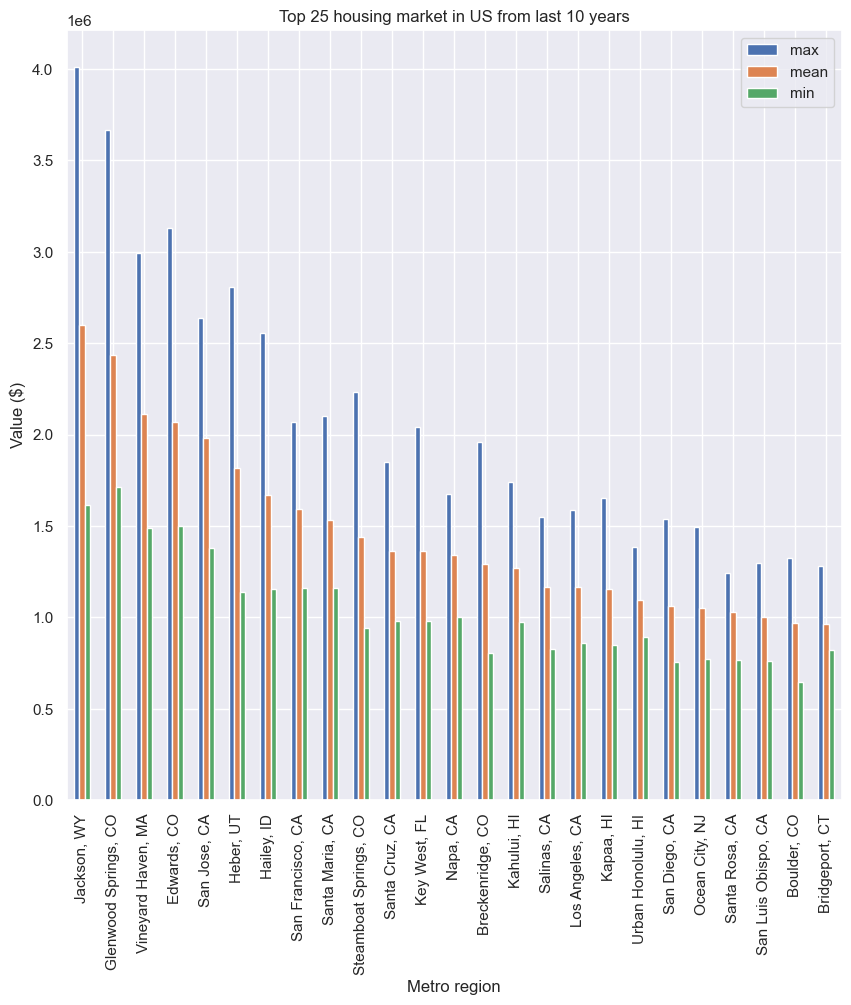

In [25]:
top_25_list_analysis[['max','mean','min']].plot(kind='bar', figsize=(10,10))
plt.title('Top 25 housing market in US from last 10 years')
plt.ylabel('Value ($)')
plt.xlabel('Metro region')

In [26]:
# Top 25 dataframe:
top_25_df = last_ten_years_metro_data.T[top_25_list_analysis.index]

# Add United States for comparison:
top_25_df['United States'] = last_ten_years_metro_data.loc['United States']
top_25_df

RegionName,"Jackson, WY","Glenwood Springs, CO","Vineyard Haven, MA","Edwards, CO","San Jose, CA","Heber, UT","Hailey, ID","San Francisco, CA","Santa Maria, CA","Steamboat Springs, CO",...,"Los Angeles, CA","Kapaa, HI","Urban Honolulu, HI","San Diego, CA","Ocean City, NJ","Santa Rosa, CA","San Luis Obispo, CA","Boulder, CO","Bridgeport, CT",United States
2014-11-30,1.617092e+06,1.711403e+06,1.491207e+06,1.498583e+06,1.378980e+06,1.139297e+06,1.155222e+06,1.159958e+06,1.161766e+06,9.400859e+05,...,8.819375e+05,8.466452e+05,8.950216e+05,7.535746e+05,7.840441e+05,7.690643e+05,7.600225e+05,6.444154e+05,8.716914e+05,383173.851903
2014-12-31,1.632974e+06,1.720627e+06,1.490998e+06,1.501019e+06,1.409377e+06,1.144735e+06,1.155522e+06,1.173009e+06,1.173270e+06,9.414843e+05,...,8.917755e+05,8.505426e+05,8.959725e+05,7.585563e+05,7.847789e+05,7.754851e+05,7.672350e+05,6.485687e+05,8.721134e+05,384678.141281
2015-01-31,1.651915e+06,1.729963e+06,1.492291e+06,1.506195e+06,1.436612e+06,1.153489e+06,1.159647e+06,1.188505e+06,1.182802e+06,9.443114e+05,...,8.991541e+05,8.521415e+05,8.984728e+05,7.638773e+05,7.829043e+05,7.836090e+05,7.748252e+05,6.545845e+05,8.737194e+05,386547.866216
2015-02-28,1.666725e+06,1.742505e+06,1.492701e+06,1.512682e+06,1.456716e+06,1.167078e+06,1.166792e+06,1.204791e+06,1.190432e+06,9.465742e+05,...,9.027458e+05,8.568407e+05,9.014198e+05,7.690906e+05,7.796337e+05,7.919774e+05,7.819281e+05,6.611385e+05,8.747134e+05,388426.128046
2015-03-31,1.681158e+06,1.758913e+06,1.496599e+06,1.518425e+06,1.468929e+06,1.183690e+06,1.177826e+06,1.220455e+06,1.194911e+06,9.499776e+05,...,9.031988e+05,8.616697e+05,9.041274e+05,7.735314e+05,7.751906e+05,8.001051e+05,7.871727e+05,6.686781e+05,8.782094e+05,390296.164145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30,3.992887e+06,3.536781e+06,2.957411e+06,3.060744e+06,2.548022e+06,2.577072e+06,2.514774e+06,1.876839e+06,2.082600e+06,2.161726e+06,...,1.551836e+06,1.631169e+06,1.318567e+06,1.536238e+06,1.460466e+06,1.198909e+06,1.299871e+06,1.220699e+06,1.273417e+06,674632.909163
2024-07-31,3.946338e+06,3.568441e+06,2.941489e+06,3.075059e+06,2.570504e+06,2.565263e+06,2.514770e+06,1.880246e+06,2.086244e+06,2.169863e+06,...,1.557527e+06,1.637696e+06,1.314568e+06,1.538632e+06,1.459583e+06,1.195302e+06,1.298902e+06,1.214814e+06,1.273721e+06,675257.201683
2024-08-31,3.903833e+06,3.604391e+06,2.932812e+06,3.092453e+06,2.591966e+06,2.554623e+06,2.516292e+06,1.878437e+06,2.089348e+06,2.182999e+06,...,1.564954e+06,1.643275e+06,1.311578e+06,1.537317e+06,1.461231e+06,1.191768e+06,1.298948e+06,1.210394e+06,1.274094e+06,675970.419296
2024-09-30,3.895642e+06,3.643856e+06,2.942363e+06,3.116613e+06,2.617204e+06,2.555176e+06,2.524810e+06,1.878028e+06,2.098580e+06,2.207551e+06,...,1.576026e+06,1.648224e+06,1.313258e+06,1.536367e+06,1.470035e+06,1.190610e+06,1.300218e+06,1.210579e+06,1.276992e+06,677375.380044


__Detecting Outliers__

Using boxplot, we are visualizing if the dataframe that we are using has any outliers.

Additionally, since the housing market has drastically went uphill in last few years since 2020, it can be assumed that the higher side of data can be on outlier when we use all data provided by Zillow since 2000.

Hence, we chomped our data to last 10 years of data to see if the outliers are removed from our data.

<Axes: xlabel='United States'>

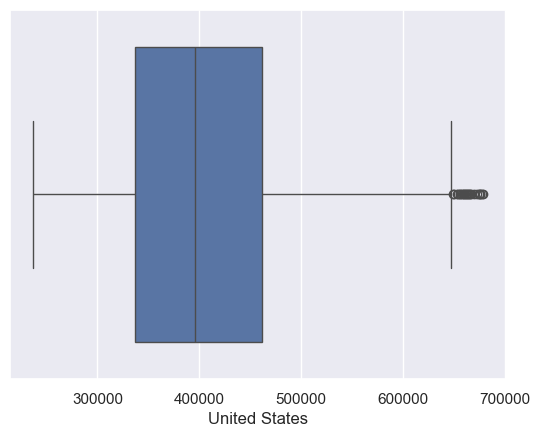

In [27]:
# Checking outliers with all 20+ years of data
sns.boxplot(x=metro_us_top_tier.loc['United States'])

<Axes: xlabel='United States'>

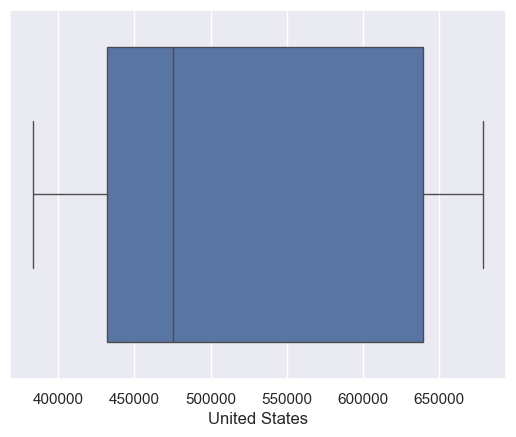

In [28]:
# Checking outliers with last 10 years of data
sns.boxplot(x=last_ten_years_metro_data.loc['United States'])

Last 10 year's of data seem to be in IQR.

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25],
 [Text(0, 0, 'Jackson, WY'),
  Text(1, 0, 'Glenwood Springs, CO'),
  Text(2, 0, 'Vineyard Haven, MA'),
  Text(3, 0, 'Edwards, CO'),
  Text(4, 0, 'San Jose, CA'),
  Text(5, 0, 'Heber, UT'),
  Text(6, 0, 'Hailey, ID'),
  Text(7, 0, 'San Francisco, CA'),
  Text(8, 0, 'Santa Maria, CA'),
  Text(9, 0, 'Steamboat Springs, CO'),
  Text(10, 0, 'Santa Cruz, CA'),
  Text(11, 0, 'Key West, FL'),
  Text(12, 0, 'Napa, CA'),
  Text(13, 0, 'Breckenridge, CO'),
  Text(14, 0, 'Kahului, HI'),
  Text(15, 0, 'Salinas, CA'),
  Text(16, 0, 'Los Angeles, CA'),
  Text(17, 0, 'Kapaa, HI'),
  Text(18, 0, 'Urban Honolulu, HI'),
  Text(19, 0, 'San Diego, CA'),
  Text(20, 0, 'Ocean City, NJ'),
  Text(21, 0, 'Santa Rosa, CA'),
  Text(22, 0, 'San Luis Obispo, CA'),
  Text(23, 0, 'Boulder, CO'),
  Text(24, 0, 'Bridgeport, CT'),
  Text(25, 0, 'United States')])

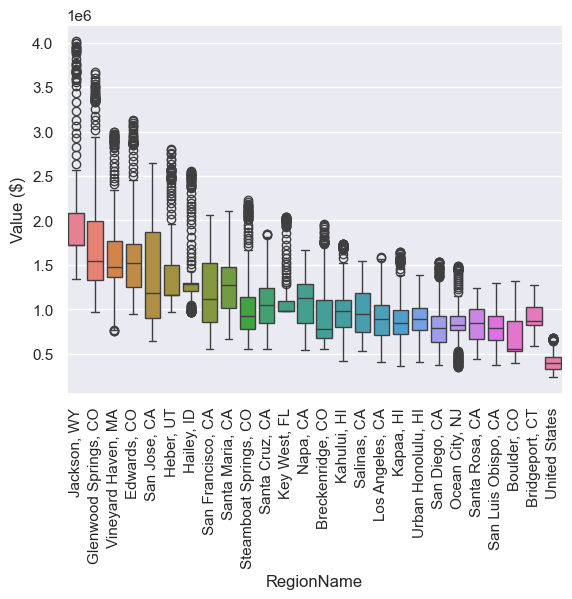

In [29]:
# Checking outliers of All data since 2000 for top 25 metro area
sns.boxplot(data=metro_us_top_tier.loc[top_25_df.T.index].T) 
plt.ylabel('Value ($)')

# Rotate labels in x axis so that all labels are visible
plt.xticks(rotation=90)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25],
 [Text(0, 0, 'Jackson, WY'),
  Text(1, 0, 'Glenwood Springs, CO'),
  Text(2, 0, 'Vineyard Haven, MA'),
  Text(3, 0, 'Edwards, CO'),
  Text(4, 0, 'San Jose, CA'),
  Text(5, 0, 'Heber, UT'),
  Text(6, 0, 'Hailey, ID'),
  Text(7, 0, 'San Francisco, CA'),
  Text(8, 0, 'Santa Maria, CA'),
  Text(9, 0, 'Steamboat Springs, CO'),
  Text(10, 0, 'Santa Cruz, CA'),
  Text(11, 0, 'Key West, FL'),
  Text(12, 0, 'Napa, CA'),
  Text(13, 0, 'Breckenridge, CO'),
  Text(14, 0, 'Kahului, HI'),
  Text(15, 0, 'Salinas, CA'),
  Text(16, 0, 'Los Angeles, CA'),
  Text(17, 0, 'Kapaa, HI'),
  Text(18, 0, 'Urban Honolulu, HI'),
  Text(19, 0, 'San Diego, CA'),
  Text(20, 0, 'Ocean City, NJ'),
  Text(21, 0, 'Santa Rosa, CA'),
  Text(22, 0, 'San Luis Obispo, CA'),
  Text(23, 0, 'Boulder, CO'),
  Text(24, 0, 'Bridgeport, CT'),
  Text(25, 0, 'United States')])

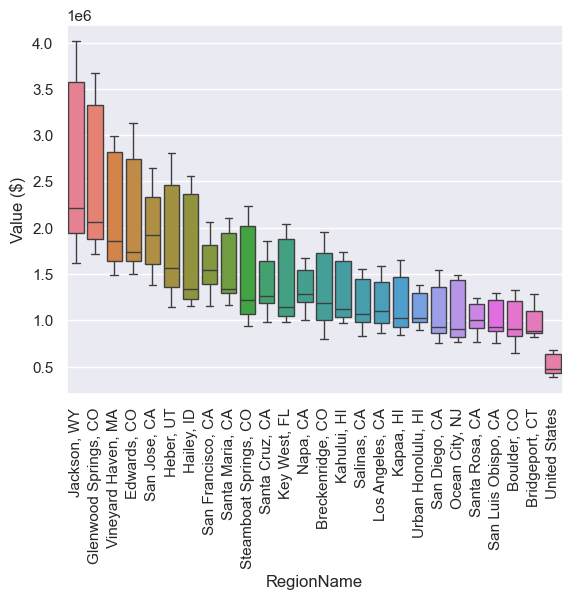

In [30]:
# Checking outliers with last 10 years of data for top 25 metro area
sns.boxplot(data=top_25_df)

plt.ylabel('Value ($)')

# Rotate labels in x axis so that all labels are visible
plt.xticks(rotation=90)

Although the data since 2000 shows outliers for higher range, looking at the box plot top 25 metro area data from last 10 years, the housing trend seems to be inside the IQR(Inter Quartile Range). This makes sense because of surge of housing market in general after 2020.

In [31]:
Q1 = top_25_df.quantile(0.25)
Q3 = top_25_df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

RegionName
Jackson, WY              1.639620e+06
Glenwood Springs, CO     1.451283e+06
Vineyard Haven, MA       1.183281e+06
Edwards, CO              1.108056e+06
San Jose, CA             7.203927e+05
Heber, UT                1.099490e+06
Hailey, ID               1.134227e+06
San Francisco, CA        4.179062e+05
Santa Maria, CA          6.502366e+05
Steamboat Springs, CO    9.446740e+05
Santa Cruz, CA           4.614101e+05
Key West, FL             8.299367e+05
Napa, CA                 3.508064e+05
Breckenridge, CO         7.307027e+05
Kahului, HI              5.996192e+05
Salinas, CA              4.598422e+05
Los Angeles, CA          4.496898e+05
Kapaa, HI                5.446788e+05
Urban Honolulu, HI       3.050923e+05
San Diego, CA            4.975523e+05
Ocean City, NJ           6.176585e+05
Santa Rosa, CA           2.545225e+05
San Luis Obispo, CA      3.422724e+05
Boulder, CO              3.794440e+05
Bridgeport, CT           2.323582e+05
United States            2.069438e+05
d

In [32]:
df = top_25_df
print("Initial shape: ", df.shape)
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
print("Expected Shape of dataframe after removing outliers:", df.shape)

Initial shape:  (120, 26)
Expected Shape of dataframe after removing outliers: (120, 26)


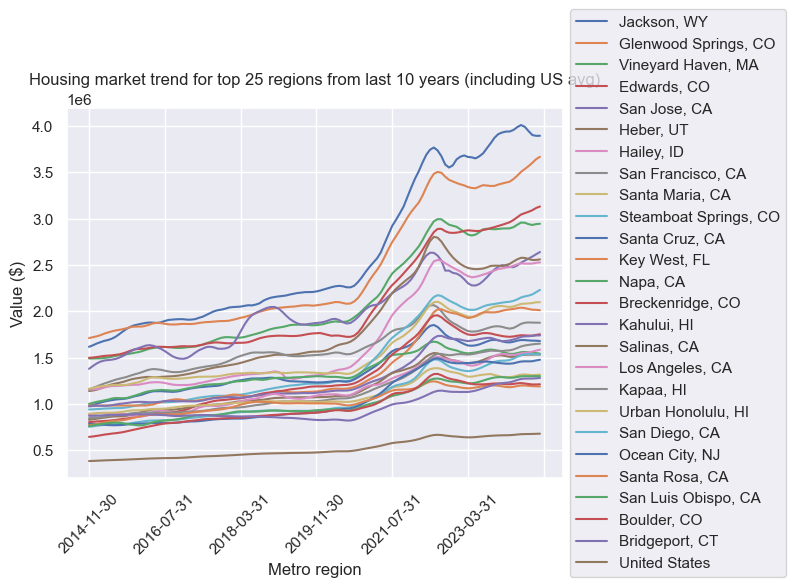

In [33]:
top_25_df.plot()

# Add title to the graph, x-axis and y-axis
plt.title('Housing market trend for top 25 regions from last 10 years (including US avg)')
plt.ylabel('Value ($)')
plt.xlabel('Metro region')

# Move legend to the right for better visiblity of the graph
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Rotate labels in x axis so that all labels are visible
plt.xticks(rotation=45)

plt.show()

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(-20.0, 0, '2023-03-31'),
  Text(0.0, 0, '2015-11-30'),
  Text(20.0, 0, '2017-07-31'),
  Text(40.0, 0, '2019-03-31'),
  Text(60.0, 0, '2020-11-30'),
  Text(80.0, 0, '2022-07-31'),
  Text(100.0, 0, '2024-03-31'),
  Text(120.0, 0, '')])

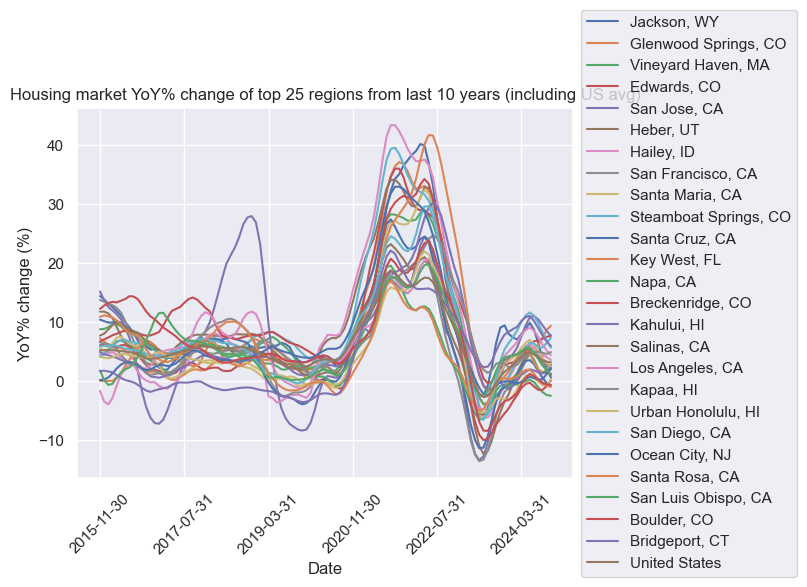

In [34]:
# Calculate YoY growth
yoy_growth_top_25_metro = pd.DataFrame()

for col in top_25_df:
    yoy_growth_top_25_metro[col] = top_25_df[col].pct_change(periods=12, fill_method=None) * 100

yoy_growth_top_25_metro.dropna(inplace=True)

yoy_growth_top_25_metro.plot()

# Add title to the graph, x-axis and y-axis
plt.title('Housing market YoY% change of top 25 regions from last 10 years (including US avg)')
plt.ylabel('YoY% change (%)')
plt.xlabel('Date')

# Move legend to the right for better visiblity of the graph
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Rotate labels in x axis so that all labels are visible
plt.xticks(rotation=45)

Using the pandas' [pct_change](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pct_change.html) method, we were able to calculate Year on Year (YoY) % change in the housing market for top 25 housing market.

We are able to observe that if investors were able to invest on these housing markets, it would go up to about 15-42% YoY % change in around 2022.

---
---

## 2. Data Type: ZHVI Single-Family Homes Time Series($)
## Geography: Metro and US.

Now, we are going to perform the exact same steps as we did above in `All Homes - Top Tier Time Series($)`.

In [35]:
# display first five rows of data
print("First 5 data:")
display(sfr_df.head(5))  

# display last five rows of data
print("Last 5 data:")
display(sfr_df.tail(5))

print("Data Types:")
display(sfr_df.dtypes)

First 5 data:


,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
0,102001,0,United States,country,NaN,121531.336651,121738.651072,121995.876446,122548.308184,123184.186238,...,350593.674816,351419.563807,352981.682891,354901.213108,356405.219291,357054.866170,357269.495250,357556.470130,358047.728564,358695.400157
1,394913,1,"New York, NY",msa,NY,215526.347853,216437.299774,217353.388393,219206.206623,221115.123983,...,653024.167946,657325.710093,662976.463941,669457.862304,674379.010648,677580.634957,680209.743078,683834.502366,687956.181425,691747.775297
2,753899,2,"Los Angeles, CA",msa,CA,228840.318549,229713.653329,230850.552728,233116.339880,235575.321729,...,961240.278183,958067.128774,956942.083361,960982.286878,967579.982979,972048.452546,976772.555536,982347.195293,989199.485026,994897.480686
3,394463,3,"Chicago, IL",msa,IL,156308.333980,156460.092041,156739.556227,157434.724023,158265.478146,...,323407.920786,325014.621277,327666.811355,330756.679881,333074.201792,334422.582458,335234.282077,336199.561203,337340.532590,338506.114351
4,394514,4,"Dallas, TX",msa,TX,126045.193158,126100.940737,126169.731762,126344.177104,126568.833701,...,371215.184232,371698.224857,372852.439583,373826.243574,373978.341627,373322.949324,372396.923106,371759.173084,371580.012878,371494.296639


Last 5 data:


,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
890,753929,935,"Zapata, TX",msa,TX,NaN,NaN,NaN,NaN,NaN,...,125505.480365,124620.859170,124703.453283,126217.346418,127940.190271,129029.544547,129216.203575,128841.856015,128169.963134,127248.665154
891,394743,936,"Ketchikan, AK",msa,AK,NaN,NaN,NaN,NaN,NaN,...,411724.194103,411668.716287,413385.593811,415037.934548,416247.744981,416235.514828,415323.647956,415325.998281,416842.773776,419086.682223
892,753874,937,"Craig, CO",msa,CO,98830.861837,99097.911211,99574.805478,100259.229234,101040.616567,...,285287.949217,285219.875814,285685.290380,286463.285398,287357.918108,287698.710801,288033.677233,288266.115146,289594.833055,291259.120524
893,395188,938,"Vernon, TX",msa,TX,NaN,NaN,NaN,NaN,NaN,...,91184.718655,91281.020656,91975.182494,92739.898571,93395.868423,93641.985168,93402.487663,92893.101563,91612.695630,90013.700765
894,394767,939,"Lamesa, TX",msa,TX,NaN,NaN,NaN,NaN,NaN,...,88711.311676,87596.741991,87637.262603,87847.018796,88770.521386,90064.663210,91903.350319,93542.740242,94253.311435,94265.128384


Data Types:


RegionID        int64
SizeRank        int64
RegionName     object
RegionType     object
StateName      object
               ...   
2024-06-30    float64
2024-07-31    float64
2024-08-31    float64
2024-09-30    float64
2024-10-31    float64
Length: 303, dtype: object

In [36]:
# Cleanup columns
sfr_df = sfr_df.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName'])
sfr_df.set_index('RegionName', inplace=True)
sfr_df.head()

,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
RegionName,,,,,,,,,,,,,,,,,,,,,
United States,121531.336651,121738.651072,121995.876446,122548.308184,123184.186238,123865.680213,124586.279073,125365.300224,126176.642380,126992.456858,...,350593.674816,351419.563807,352981.682891,354901.213108,356405.219291,357054.866170,357269.495250,357556.470130,358047.728564,358695.400157
"New York, NY",215526.347853,216437.299774,217353.388393,219206.206623,221115.123983,223259.025429,225613.438183,228131.099900,230680.962642,233209.761443,...,653024.167946,657325.710093,662976.463941,669457.862304,674379.010648,677580.634957,680209.743078,683834.502366,687956.181425,691747.775297
"Los Angeles, CA",228840.318549,229713.653329,230850.552728,233116.339880,235575.321729,238017.327535,240515.010731,243005.004934,245342.258175,247423.560181,...,961240.278183,958067.128774,956942.083361,960982.286878,967579.982979,972048.452546,976772.555536,982347.195293,989199.485026,994897.480686
"Chicago, IL",156308.333980,156460.092041,156739.556227,157434.724023,158265.478146,159199.059474,160194.910072,161574.960011,163187.672396,165047.344391,...,323407.920786,325014.621277,327666.811355,330756.679881,333074.201792,334422.582458,335234.282077,336199.561203,337340.532590,338506.114351
"Dallas, TX",126045.193158,126100.940737,126169.731762,126344.177104,126568.833701,126796.407950,127030.425355,127380.246590,127815.924260,128301.186954,...,371215.184232,371698.224857,372852.439583,373826.243574,373978.341627,373322.949324,372396.923106,371759.173084,371580.012878,371494.296639


In [37]:
# Check for duplicates
dup_df = sfr_df[sfr_df.duplicated()]
print("number of duplicate rows: ", dup_df.shape)

number of duplicate rows:  (0, 298)


In [38]:
# Cleanup null data
print(sfr_df.isnull().sum())

2000-01-31    464
2000-02-29    463
2000-03-31    462
2000-04-30    460
2000-05-31    458
             ... 
2024-06-30      0
2024-07-31      0
2024-08-31      0
2024-09-30      0
2024-10-31      0
Length: 298, dtype: int64


In [39]:
# Similar to previous data, we need to backfill missing data
sfr_df.bfill(axis=1, inplace=True)
print(sfr_df.isnull().sum())

2000-01-31    0
2000-02-29    0
2000-03-31    0
2000-04-30    0
2000-05-31    0
             ..
2024-06-30    0
2024-07-31    0
2024-08-31    0
2024-09-30    0
2024-10-31    0
Length: 298, dtype: int64


In [40]:
# Descriptive statistics for last 10 years of data
# View details in previous data analysis in step 1 for more details.
last_ten_years_sfr_metro_data = sfr_df.iloc[:,-120:]
descriptive_analysis_sfr_df = last_ten_years_sfr_metro_data.T.describe()
sorted_sfr_df = descriptive_analysis_sfr_df.T.sort_values(by=['mean', 'std'],ascending=[False, True])
top_25_sfr_list_analysis = sorted_sfr_df.head(25)
top_25_sfr_list_analysis

,count,mean,std,min,25%,50%,75%,max
RegionName,,,,,,,,
"San Jose, CA",120.0,1.227770e+06,267761.480380,797728.285666,960762.412575,1.198467e+06,1.471244e+06,1.702743e+06
"Jackson, WY",120.0,1.027722e+06,343449.306049,598841.658036,752370.337884,8.632563e+05,1.457562e+06,1.627873e+06
"Vineyard Haven, MA",120.0,1.017045e+06,298184.783358,670733.689937,761675.171617,8.890117e+05,1.381567e+06,1.528388e+06
"Breckenridge, CO",120.0,1.012145e+06,296715.646988,607037.371220,770032.918989,9.339546e+05,1.365240e+06,1.544412e+06
"San Francisco, CA",120.0,9.975818e+05,178554.888295,669164.710363,844554.899866,9.651118e+05,1.173840e+06,1.322396e+06
"Edwards, CO",120.0,9.496837e+05,300340.623304,609277.848856,716201.581925,8.020417e+05,1.302244e+06,1.535533e+06
"Santa Cruz, CA",120.0,9.238488e+05,190722.600565,621639.338449,775343.533615,8.518331e+05,1.135772e+06,1.262473e+06
"Urban Honolulu, HI",120.0,8.490712e+05,137494.628288,656734.967712,747023.072934,7.945712e+05,1.024892e+06,1.087724e+06
"Steamboat Springs, CO",120.0,8.247768e+05,275754.640298,495552.061851,602122.468676,7.028160e+05,1.163190e+06,1.312827e+06


Text(0.5, 0, 'Metro region')

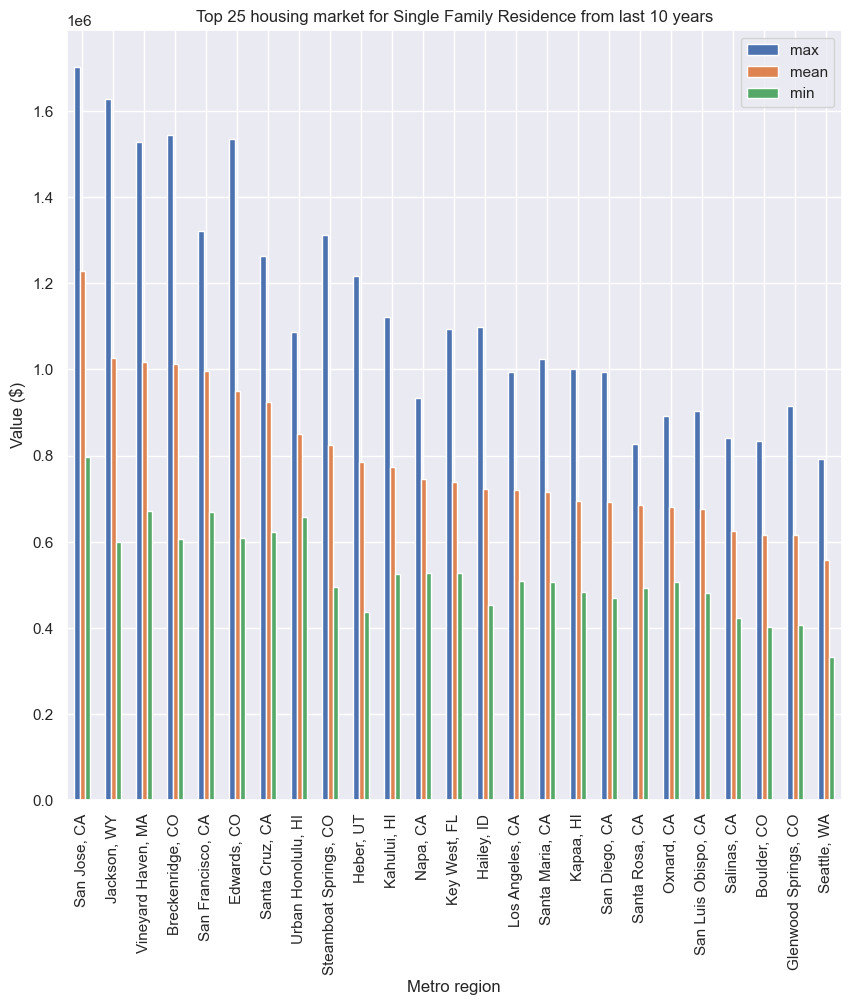

In [41]:
# Bar chart
top_25_sfr_list_analysis[['max','mean','min']].plot(kind='bar', figsize=(10,10))
plt.title('Top 25 housing market for Single Family Residence from last 10 years')
plt.ylabel('Value ($)')
plt.xlabel('Metro region')

In [42]:
# Top 25 dataframe:
top_25_sfr_df = last_ten_years_sfr_metro_data.T[top_25_sfr_list_analysis.index]

# Add United States for comparison:
top_25_sfr_df['United States'] = last_ten_years_sfr_metro_data.loc['United States']
top_25_sfr_df

RegionName,"San Jose, CA","Jackson, WY","Vineyard Haven, MA","Breckenridge, CO","San Francisco, CA","Edwards, CO","Santa Cruz, CA","Urban Honolulu, HI","Steamboat Springs, CO","Heber, UT",...,"Kapaa, HI","San Diego, CA","Santa Rosa, CA","Oxnard, CA","San Luis Obispo, CA","Salinas, CA","Boulder, CO","Glenwood Springs, CO","Seattle, WA",United States
2014-11-30,7.977283e+05,5.988417e+05,6.707337e+05,6.070374e+05,6.691647e+05,6.092778e+05,6.216393e+05,6.567350e+05,4.955521e+05,4.379330e+05,...,4.832179e+05,470137.968734,492145.182379,506802.415334,480130.845483,422078.949928,401948.492560,406705.690365,332009.292636,183119.477734
2014-12-31,8.129893e+05,6.051410e+05,6.712370e+05,6.104846e+05,6.763180e+05,6.116896e+05,6.286417e+05,6.578930e+05,4.975340e+05,4.411798e+05,...,4.859857e+05,473230.961709,495562.044744,508816.648047,484630.580138,423980.699058,404738.599033,409667.606292,334643.189694,183749.122476
2015-01-31,8.264284e+05,6.115475e+05,6.721315e+05,6.129583e+05,6.849462e+05,6.141527e+05,6.359017e+05,6.601115e+05,4.994614e+05,4.451816e+05,...,4.879561e+05,476788.301589,500164.705131,511276.545224,489153.457991,425117.340890,408678.362882,413348.993768,338174.375622,184535.969904
2015-02-28,8.365256e+05,6.164900e+05,6.731938e+05,6.149740e+05,6.943245e+05,6.174458e+05,6.443133e+05,6.627933e+05,5.013914e+05,4.509419e+05,...,4.912250e+05,480656.664234,505634.544965,514370.416674,493499.290948,427308.048779,413209.637536,417826.766668,342098.571710,185330.314211
2015-03-31,8.423841e+05,6.215188e+05,6.748560e+05,6.178346e+05,7.036024e+05,6.208437e+05,6.511477e+05,6.651091e+05,5.037327e+05,4.575501e+05,...,4.943015e+05,484356.946989,511360.059947,517757.081661,497053.385575,429229.680051,418272.957146,423015.758996,345746.506786,186140.654880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30,1.645861e+06,1.623897e+06,1.528388e+06,1.383134e+06,1.231113e+06,1.496410e+06,1.189461e+06,1.047280e+06,1.274767e+06,1.158544e+06,...,9.917911e+05,993451.496153,821640.284768,888444.399012,902358.768271,837110.519943,785871.479074,899522.573554,761965.250257,357054.866170
2024-07-31,1.662261e+06,1.611548e+06,1.524474e+06,1.382251e+06,1.234249e+06,1.507545e+06,1.188875e+06,1.045014e+06,1.279373e+06,1.154122e+06,...,9.963030e+05,994946.104302,820549.142884,890788.459075,903034.281181,839584.074191,783281.235107,901702.297963,763152.773547,357269.495250
2024-08-31,1.676799e+06,1.600794e+06,1.521817e+06,1.383335e+06,1.232985e+06,1.517310e+06,1.189054e+06,1.043513e+06,1.286411e+06,1.151417e+06,...,9.996661e+05,994352.364898,819340.770603,891976.864321,903490.106956,840308.572337,781656.310157,904829.568594,764192.349569,357556.470130
2024-09-30,1.690593e+06,1.599956e+06,1.525980e+06,1.389037e+06,1.230762e+06,1.528688e+06,1.188908e+06,1.045277e+06,1.300061e+06,1.152907e+06,...,1.001037e+06,993706.241079,819051.319335,893076.005802,904151.975252,841273.035972,782104.363124,909907.850763,766999.120177,358047.728564


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25],
 [Text(0, 0, 'San Jose, CA'),
  Text(1, 0, 'Jackson, WY'),
  Text(2, 0, 'Vineyard Haven, MA'),
  Text(3, 0, 'Breckenridge, CO'),
  Text(4, 0, 'San Francisco, CA'),
  Text(5, 0, 'Edwards, CO'),
  Text(6, 0, 'Santa Cruz, CA'),
  Text(7, 0, 'Urban Honolulu, HI'),
  Text(8, 0, 'Steamboat Springs, CO'),
  Text(9, 0, 'Heber, UT'),
  Text(10, 0, 'Kahului, HI'),
  Text(11, 0, 'Napa, CA'),
  Text(12, 0, 'Key West, FL'),
  Text(13, 0, 'Hailey, ID'),
  Text(14, 0, 'Los Angeles, CA'),
  Text(15, 0, 'Santa Maria, CA'),
  Text(16, 0, 'Kapaa, HI'),
  Text(17, 0, 'San Diego, CA'),
  Text(18, 0, 'Santa Rosa, CA'),
  Text(19, 0, 'Oxnard, CA'),
  Text(20, 0, 'San Luis Obispo, CA'),
  Text(21, 0, 'Salinas, CA'),
  Text(22, 0, 'Boulder, CO'),
  Text(23, 0, 'Glenwood Springs, CO'),
  Text(24, 0, 'Seattle, WA'),
  Text(25, 0, 'United States')])

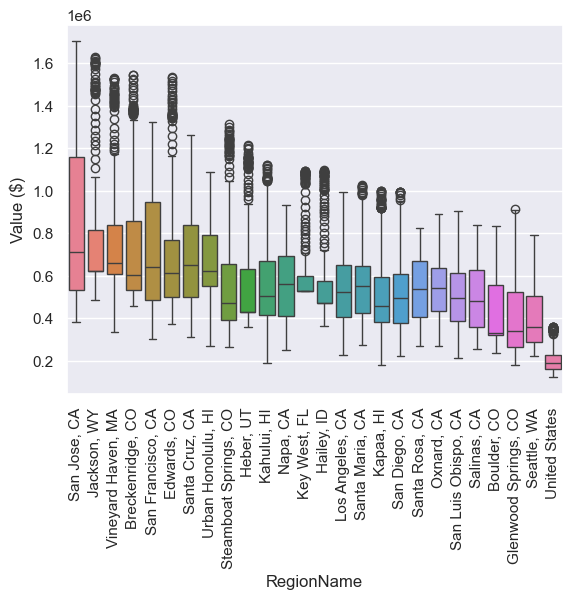

In [43]:
# Checking outliers of All data since 2000 for top 25 SFR area
sns.boxplot(data=sfr_df.loc[top_25_sfr_df.T.index].T) 
plt.ylabel('Value ($)')

# Rotate labels in x axis so that all labels are visible
plt.xticks(rotation=90)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25],
 [Text(0, 0, 'San Jose, CA'),
  Text(1, 0, 'Jackson, WY'),
  Text(2, 0, 'Vineyard Haven, MA'),
  Text(3, 0, 'Breckenridge, CO'),
  Text(4, 0, 'San Francisco, CA'),
  Text(5, 0, 'Edwards, CO'),
  Text(6, 0, 'Santa Cruz, CA'),
  Text(7, 0, 'Urban Honolulu, HI'),
  Text(8, 0, 'Steamboat Springs, CO'),
  Text(9, 0, 'Heber, UT'),
  Text(10, 0, 'Kahului, HI'),
  Text(11, 0, 'Napa, CA'),
  Text(12, 0, 'Key West, FL'),
  Text(13, 0, 'Hailey, ID'),
  Text(14, 0, 'Los Angeles, CA'),
  Text(15, 0, 'Santa Maria, CA'),
  Text(16, 0, 'Kapaa, HI'),
  Text(17, 0, 'San Diego, CA'),
  Text(18, 0, 'Santa Rosa, CA'),
  Text(19, 0, 'Oxnard, CA'),
  Text(20, 0, 'San Luis Obispo, CA'),
  Text(21, 0, 'Salinas, CA'),
  Text(22, 0, 'Boulder, CO'),
  Text(23, 0, 'Glenwood Springs, CO'),
  Text(24, 0, 'Seattle, WA'),
  Text(25, 0, 'United States')])

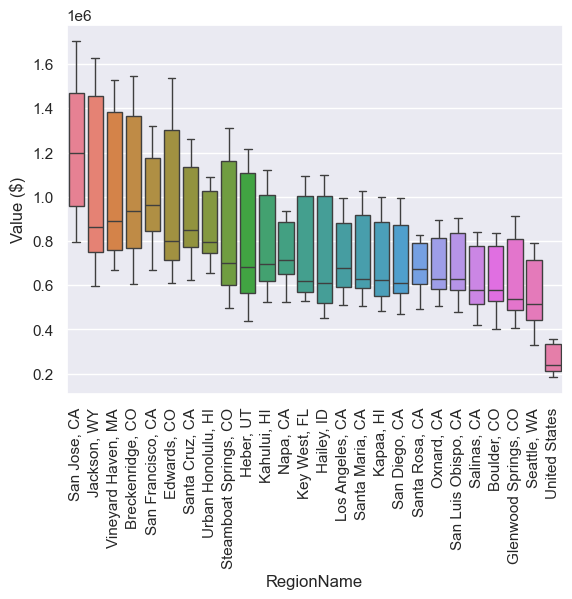

In [44]:
# Checking outliers with last 10 years of data for top 25 SFR
sns.boxplot(data=top_25_sfr_df)

plt.ylabel('Value ($)')

# Rotate labels in x axis so that all labels are visible
plt.xticks(rotation=90)

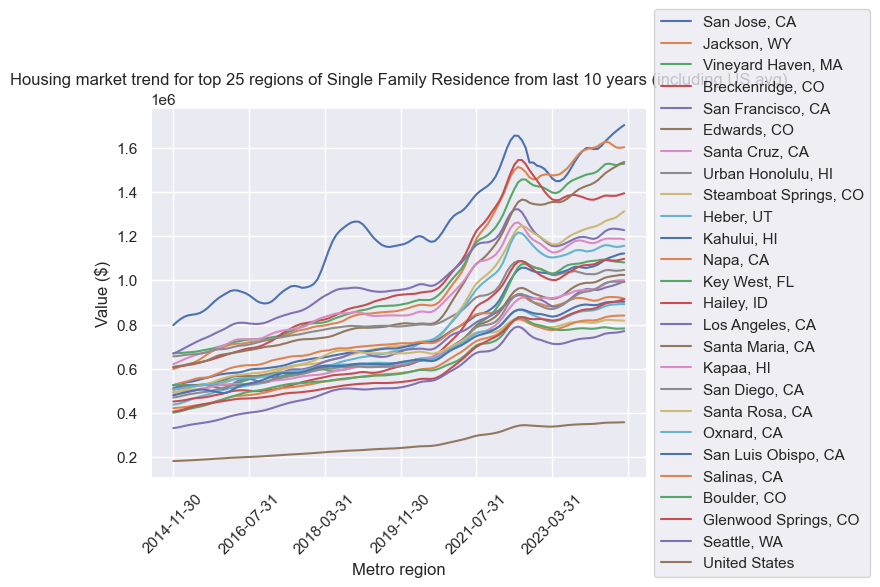

In [45]:
# Trend for top 25 market
top_25_sfr_df.plot()
plt.title('Housing market trend for top 25 regions of Single Family Residence from last 10 years (including US avg)')
plt.ylabel('Value ($)')
plt.xlabel('Metro region')

# Move legend to the right for better visiblity of the graph
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Rotate labels in x axis so that all labels are visible
plt.xticks(rotation=45)

plt.show()

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(-20.0, 0, '2023-03-31'),
  Text(0.0, 0, '2015-11-30'),
  Text(20.0, 0, '2017-07-31'),
  Text(40.0, 0, '2019-03-31'),
  Text(60.0, 0, '2020-11-30'),
  Text(80.0, 0, '2022-07-31'),
  Text(100.0, 0, '2024-03-31'),
  Text(120.0, 0, '')])

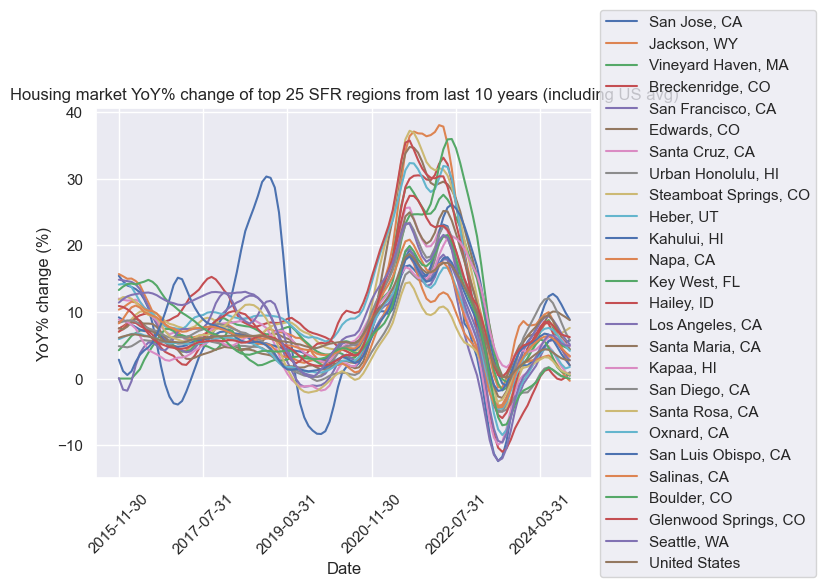

In [46]:
# Calculate YoY growth
yoy_growth_top_25_sfr = pd.DataFrame()

for col in top_25_sfr_df:
    yoy_growth_top_25_sfr[col] = top_25_sfr_df[col].pct_change(periods=12, fill_method=None) * 100

yoy_growth_top_25_sfr.dropna(inplace=True)

yoy_growth_top_25_sfr.plot()

# Add title to the graph, x-axis and y-axis
plt.title('Housing market YoY% change of top 25 SFR regions from last 10 years (including US avg)')
plt.ylabel('YoY% change (%)')
plt.xlabel('Date')

# Move legend to the right for better visiblity of the graph
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Rotate labels in x axis so that all labels are visible
plt.xticks(rotation=45)

In [47]:
# Uncomment to install tabulate and/or create markdown to be copied to conclusion
# !pip install tabulate
# # From all houses
# print(pd.concat([top_25_list_analysis.loc[:, ['mean','std']], yoy_growth_top_25_metro.mean().rename("Average YoY% last 10 years")], axis=1).to_markdown())

# # From only SFR
# print(pd.concat([top_25_sfr_list_analysis.loc[:, ['mean','std']], yoy_growth_top_25_sfr.mean().rename("Average YoY% last 10 years")], axis=1).to_markdown())

## Conclusion:

Here are the list of top 25 housing market that are doing well overall.

### Top 25 All Housing market (Includes Single Family Residence and Condos)
|  RegionName           |             mean |    std |   Average YoY% last 10 years |
|:----------------------|-----------------:|-------:|-----------------------------:|
| Jackson, WY           |      2.59957e+06 | 801671 |                     10.1646  |
| Glenwood Springs, CO  |      2.43306e+06 | 670266 |                      8.33359 |
| Vineyard Haven, MA    |      2.11046e+06 | 543758 |                      7.9457  |
| Edwards, CO           |      2.06951e+06 | 559886 |                      8.32554 |
| San Jose, CA          |      1.98135e+06 | 377474 |                      6.69464 |
| Heber, UT             |      1.81709e+06 | 534465 |                      9.20788 |
| Hailey, ID            |      1.67035e+06 | 532237 |                      9.42108 |
| San Francisco, CA     |      1.59217e+06 | 229502 |                      4.8508  |
| Santa Maria, CA       |      1.53504e+06 | 330266 |                      6.69487 |
| Steamboat Springs, CO |      1.44105e+06 | 455912 |                      9.93316 |
| Santa Cruz, CA        |      1.36547e+06 | 248359 |                      5.93189 |
| Key West, FL          |      1.36303e+06 | 402685 |                      8.86717 |
| Napa, CA              |      1.33953e+06 | 190744 |                      4.65281 |
| Breckenridge, CO      |      1.29232e+06 | 365414 |                      9.12443 |
| Kahului, HI           |      1.27069e+06 | 280592 |                      6.54653 |
| Salinas, CA           |      1.16843e+06 | 237667 |                      6.80919 |
| Los Angeles, CA       |      1.16478e+06 | 234546 |                      6.46095 |
| Kapaa, HI             |      1.15683e+06 | 269255 |                      7.25422 |
| Urban Honolulu, HI    |      1.09775e+06 | 155236 |                      4.30424 |
| San Diego, CA         |      1.06392e+06 | 258233 |                      7.94899 |
| Ocean City, NJ        |      1.05362e+06 | 276310 |                      7.58025 |
| Santa Rosa, CA        |      1.02831e+06 | 133822 |                      4.56057 |
| San Luis Obispo, CA   |      1.00375e+06 | 179990 |                      5.86646 |
| Boulder, CO           | 967842           | 197576 |                      6.99047 |
| Bridgeport, CT        | 962255           | 144675 |                      4.27155 |

### Top 25 Single Family Residence housing market

|   RegionName          |             mean |      std |   Average YoY% last 10 years |
|:----------------------|-----------------:|---------:|-----------------------------:|
| San Jose, CA          |      1.22777e+06 | 267761   |                      8.01245 |
| Jackson, WY           |      1.02772e+06 | 343449   |                     11.2728  |
| Vineyard Haven, MA    |      1.01704e+06 | 298185   |                      9.51001 |
| Breckenridge, CO      |      1.01214e+06 | 296716   |                      9.65667 |
| San Francisco, CA     | 997582           | 178555   |                      6.2944  |
| Edwards, CO           | 949684           | 300341   |                     10.3479  |
| Santa Cruz, CA        | 923849           | 190723   |                      7.0235  |
| Urban Honolulu, HI    | 849071           | 137495   |                      5.18692 |
| Steamboat Springs, CO | 824777           | 275755   |                     11.0773  |
| Heber, UT             | 784485           | 258184   |                     10.9395  |
| Kahului, HI           | 774397           | 190472   |                      8.11614 |
| Napa, CA              | 744594           | 125742   |                      5.95208 |
| Key West, FL          | 738031           | 212630   |                      8.77469 |
| Hailey, ID            | 722814           | 232838   |                     10.2501  |
| Los Angeles, CA       | 719565           | 156142   |                      7.24308 |
| Santa Maria, CA       | 715098           | 169254   |                      7.76368 |
| Kapaa, HI             | 695026           | 167550   |                      7.8303  |
| San Diego, CA         | 692270           | 165706   |                      8.20197 |
| Santa Rosa, CA        | 685695           |  98524.8 |                      5.29591 |
| Oxnard, CA            | 680779           | 123017   |                      6.10498 |
| San Luis Obispo, CA   | 676830           | 136815   |                      6.90863 |
| Salinas, CA           | 624332           | 137029   |                      7.57841 |
| Boulder, CO           | 616570           | 127961   |                      7.2792  |
| Glenwood Springs, CO  | 615993           | 161010   |                      8.65886 |
| Seattle, WA           | 558299           | 142944   |                      9.17337 |

Text(0.5, 0, 'RegionName')

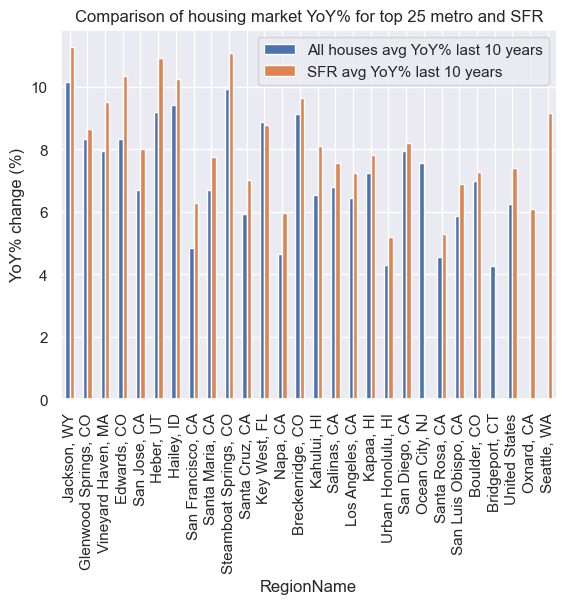

In [48]:
comparison_list = pd.concat([yoy_growth_top_25_metro.mean().rename("All houses avg YoY% last 10 years"), yoy_growth_top_25_sfr.mean().rename("SFR avg YoY% last 10 years")], axis=1)
comparison_list.plot.bar()
plt.title('Comparison of housing market YoY% for top 25 metro and SFR')
plt.ylabel('YoY% change (%)')
plt.xlabel('RegionName')

Looking at the above data, we can conclude that the `Single Family Residence` would give more profit than that of top tier level of general housing market.

# Analysis of Inventory Listings and Sale Prices in the US

This analysis examines trends in **sale prices** and **inventory listings** across the United States to determine whether they are increasing or decreasing over time.



# Data Preparation

**Display Head**

In [49]:
print("Inventory: ")
display(inventory_df.head(5))

print("Sales: ")
display(sales_df.head(5))

Inventory: 


,RegionID,SizeRank,RegionName,RegionType,StateName,2018-02-03,2018-02-10,2018-02-17,2018-02-24,2018-03-03,...,2024-08-31,2024-09-07,2024-09-14,2024-09-21,2024-09-28,2024-10-05,2024-10-12,2024-10-19,2024-10-26,2024-11-02
0,102001,0,United States,country,NaN,1099344.0,1102526.0,1107447.0,1112877.0,1121833.0,...,916135.0,918365.0,922465.0,927881.0,933655.0,939666.0,939618.0,937949.0,935707.0,929912.0
1,394913,1,"New York, NY",msa,NY,54940.0,56344.0,57463.0,58652.0,60209.0,...,32771.0,32523.0,32564.0,32777.0,33197.0,33415.0,33344.0,33108.0,32820.0,32456.0
2,753899,2,"Los Angeles, CA",msa,CA,14067.0,14493.0,14833.0,15147.0,15491.0,...,15849.0,15913.0,16075.0,16242.0,16443.0,16600.0,16597.0,16529.0,16413.0,16187.0
3,394463,3,"Chicago, IL",msa,IL,27287.0,27458.0,27688.0,27982.0,28726.0,...,17751.0,17840.0,18020.0,18265.0,18489.0,18705.0,18747.0,18732.0,18666.0,18434.0
4,394514,4,"Dallas, TX",msa,TX,17536.0,17648.0,17725.0,17647.0,17546.0,...,25403.0,25385.0,25399.0,25466.0,25540.0,25671.0,25707.0,25667.0,25598.0,25412.0


Sales: 


,RegionID,SizeRank,RegionName,RegionType,StateName,2010-07-31,2010-08-07,2010-08-14,2010-08-21,2010-08-28,...,2024-08-03,2024-08-10,2024-08-17,2024-08-24,2024-08-31,2024-09-07,2024-09-14,2024-09-21,2024-09-28,2024-10-05
0,102001,0,United States,country,NaN,163057.0,162938.0,161641.0,161022.0,159605.0,...,361061.0,358884.0,358128.0,358372.0,357833.0,357615.0,355333.0,353609.0,352024.0,352741.0
1,394913,1,"New York, NY",msa,NY,373726.0,377501.0,378907.0,378429.0,379390.0,...,644874.0,644825.0,642866.0,642027.0,637116.0,637910.0,634042.0,634199.0,629413.0,626027.0
2,753899,2,"Los Angeles, CA",msa,CA,366043.0,359488.0,358723.0,359124.0,359683.0,...,954847.0,944996.0,935440.0,933922.0,930676.0,931104.0,929514.0,919733.0,915425.0,912577.0
3,394463,3,"Chicago, IL",msa,IL,187862.0,190964.0,193905.0,197783.0,194147.0,...,333020.0,328126.0,324579.0,323817.0,316574.0,317515.0,315110.0,314574.0,318462.0,319632.0
4,394514,4,"Dallas, TX",msa,TX,156243.0,157720.0,159032.0,158744.0,157167.0,...,397151.0,399930.0,397865.0,396551.0,391532.0,386206.0,381294.0,379462.0,380009.0,381189.0


**Display Tails**

In [50]:
print("Inventory: ")
display(inventory_df.tail(5))

print("Sales: ")
display(sales_df.tail(5))

Inventory: 


,RegionID,SizeRank,RegionName,RegionType,StateName,2018-02-03,2018-02-10,2018-02-17,2018-02-24,2018-03-03,...,2024-08-31,2024-09-07,2024-09-14,2024-09-21,2024-09-28,2024-10-05,2024-10-12,2024-10-19,2024-10-26,2024-11-02
923,753929,935,"Zapata, TX",msa,TX,NaN,NaN,NaN,NaN,NaN,...,36.0,35.0,34.0,34.0,34.0,35.0,35.0,36.0,36.0,36.0
924,394743,936,"Ketchikan, AK",msa,AK,67.0,66.0,65.0,65.0,65.0,...,44.0,45.0,45.0,45.0,44.0,43.0,43.0,43.0,42.0,41.0
925,753874,937,"Craig, CO",msa,CO,101.0,99.0,98.0,97.0,95.0,...,77.0,75.0,72.0,69.0,65.0,62.0,61.0,63.0,65.0,67.0
926,395188,938,"Vernon, TX",msa,TX,NaN,NaN,NaN,NaN,NaN,...,32.0,32.0,32.0,31.0,31.0,31.0,31.0,31.0,32.0,33.0
927,394767,939,"Lamesa, TX",msa,TX,NaN,NaN,NaN,NaN,NaN,...,34.0,33.0,33.0,33.0,33.0,32.0,32.0,31.0,29.0,28.0


Sales: 


,RegionID,SizeRank,RegionName,RegionType,StateName,2010-07-31,2010-08-07,2010-08-14,2010-08-21,2010-08-28,...,2024-08-03,2024-08-10,2024-08-17,2024-08-24,2024-08-31,2024-09-07,2024-09-14,2024-09-21,2024-09-28,2024-10-05
260,394928,410,"Ocean City, NJ",msa,NJ,NaN,NaN,NaN,NaN,NaN,...,633584.0,599041.0,601314.0,626950.0,625251.0,651322.0,699685.0,693830.0,668666.0,639465.0
261,753881,456,"Glenwood Springs, CO",msa,CO,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,777451.0
262,394674,467,"Heber, UT",msa,UT,NaN,NaN,NaN,NaN,NaN,...,1094240.0,1056131.0,1073995.0,1072451.0,1007439.0,1044525.0,1062591.0,1040264.0,1057117.0,1020720.0
263,394629,520,"Georgetown, SC",msa,SC,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,404566.0,375550.0,400007.0,445330.0
264,753871,811,"Breckenridge, CO",msa,CO,NaN,NaN,NaN,NaN,NaN,...,1084891.0,1092285.0,1078373.0,1131790.0,1076013.0,996083.0,949072.0,908514.0,928565.0,906492.0


**Display Data Types**

In [51]:
print("Inventory: ")
display(inventory_df.dtypes)

print("Sales: ")
display(sales_df.dtypes)

Inventory: 


RegionID        int64
SizeRank        int64
RegionName     object
RegionType     object
StateName      object
               ...   
2024-10-05    float64
2024-10-12    float64
2024-10-19    float64
2024-10-26    float64
2024-11-02    float64
Length: 358, dtype: object

Sales: 


RegionID        int64
SizeRank        int64
RegionName     object
RegionType     object
StateName      object
               ...   
2024-09-07    float64
2024-09-14    float64
2024-09-21    float64
2024-09-28    float64
2024-10-05    float64
Length: 746, dtype: object

# Cleaning

##### Dropping Columns

In [52]:
print("Inventory: ")
inventory_df = inventory_df.drop(['RegionID', "SizeRank", 'RegionType'], axis=1)
display(inventory_df.head(5))

print("Sales: ")
sales_df = sales_df.drop(['RegionID', "SizeRank", 'RegionType'], axis=1)
display(sales_df.head(5))




Inventory: 


,RegionName,StateName,2018-02-03,2018-02-10,2018-02-17,2018-02-24,2018-03-03,2018-03-10,2018-03-17,2018-03-24,...,2024-08-31,2024-09-07,2024-09-14,2024-09-21,2024-09-28,2024-10-05,2024-10-12,2024-10-19,2024-10-26,2024-11-02
0,United States,NaN,1099344.0,1102526.0,1107447.0,1112877.0,1121833.0,1133065.0,1151110.0,1166015.0,...,916135.0,918365.0,922465.0,927881.0,933655.0,939666.0,939618.0,937949.0,935707.0,929912.0
1,"New York, NY",NY,54940.0,56344.0,57463.0,58652.0,60209.0,61109.0,62550.0,63753.0,...,32771.0,32523.0,32564.0,32777.0,33197.0,33415.0,33344.0,33108.0,32820.0,32456.0
2,"Los Angeles, CA",CA,14067.0,14493.0,14833.0,15147.0,15491.0,15715.0,16175.0,16450.0,...,15849.0,15913.0,16075.0,16242.0,16443.0,16600.0,16597.0,16529.0,16413.0,16187.0
3,"Chicago, IL",IL,27287.0,27458.0,27688.0,27982.0,28726.0,29531.0,30637.0,31502.0,...,17751.0,17840.0,18020.0,18265.0,18489.0,18705.0,18747.0,18732.0,18666.0,18434.0
4,"Dallas, TX",TX,17536.0,17648.0,17725.0,17647.0,17546.0,17639.0,17913.0,18304.0,...,25403.0,25385.0,25399.0,25466.0,25540.0,25671.0,25707.0,25667.0,25598.0,25412.0


Sales: 


,RegionName,StateName,2010-07-31,2010-08-07,2010-08-14,2010-08-21,2010-08-28,2010-09-04,2010-09-11,2010-09-18,...,2024-08-03,2024-08-10,2024-08-17,2024-08-24,2024-08-31,2024-09-07,2024-09-14,2024-09-21,2024-09-28,2024-10-05
0,United States,NaN,163057.0,162938.0,161641.0,161022.0,159605.0,159532.0,160755.0,159731.0,...,361061.0,358884.0,358128.0,358372.0,357833.0,357615.0,355333.0,353609.0,352024.0,352741.0
1,"New York, NY",NY,373726.0,377501.0,378907.0,378429.0,379390.0,378766.0,336127.0,328807.0,...,644874.0,644825.0,642866.0,642027.0,637116.0,637910.0,634042.0,634199.0,629413.0,626027.0
2,"Los Angeles, CA",CA,366043.0,359488.0,358723.0,359124.0,359683.0,361253.0,366245.0,365901.0,...,954847.0,944996.0,935440.0,933922.0,930676.0,931104.0,929514.0,919733.0,915425.0,912577.0
3,"Chicago, IL",IL,187862.0,190964.0,193905.0,197783.0,194147.0,190110.0,183058.0,178297.0,...,333020.0,328126.0,324579.0,323817.0,316574.0,317515.0,315110.0,314574.0,318462.0,319632.0
4,"Dallas, TX",TX,156243.0,157720.0,159032.0,158744.0,157167.0,154474.0,152503.0,150986.0,...,397151.0,399930.0,397865.0,396551.0,391532.0,386206.0,381294.0,379462.0,380009.0,381189.0


##### Dropping Rows (RegionName: United States)

In [53]:
#Dropping united states

inventory_df = inventory_df[inventory_df["RegionName"] != "United States"]

sales_df = sales_df[sales_df["RegionName"] != "United States"]

print("Inventory: ")
display(inventory_df)

print("Inventory: ")
display(sales_df)

Inventory: 


,RegionName,StateName,2018-02-03,2018-02-10,2018-02-17,2018-02-24,2018-03-03,2018-03-10,2018-03-17,2018-03-24,...,2024-08-31,2024-09-07,2024-09-14,2024-09-21,2024-09-28,2024-10-05,2024-10-12,2024-10-19,2024-10-26,2024-11-02
1,"New York, NY",NY,54940.0,56344.0,57463.0,58652.0,60209.0,61109.0,62550.0,63753.0,...,32771.0,32523.0,32564.0,32777.0,33197.0,33415.0,33344.0,33108.0,32820.0,32456.0
2,"Los Angeles, CA",CA,14067.0,14493.0,14833.0,15147.0,15491.0,15715.0,16175.0,16450.0,...,15849.0,15913.0,16075.0,16242.0,16443.0,16600.0,16597.0,16529.0,16413.0,16187.0
3,"Chicago, IL",IL,27287.0,27458.0,27688.0,27982.0,28726.0,29531.0,30637.0,31502.0,...,17751.0,17840.0,18020.0,18265.0,18489.0,18705.0,18747.0,18732.0,18666.0,18434.0
4,"Dallas, TX",TX,17536.0,17648.0,17725.0,17647.0,17546.0,17639.0,17913.0,18304.0,...,25403.0,25385.0,25399.0,25466.0,25540.0,25671.0,25707.0,25667.0,25598.0,25412.0
5,"Houston, TX",TX,19163.0,19128.0,19150.0,19203.0,19344.0,19622.0,20131.0,20565.0,...,23542.0,23536.0,23562.0,23620.0,23670.0,23769.0,23786.0,23797.0,23785.0,23676.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923,"Zapata, TX",TX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36.0,35.0,34.0,34.0,34.0,35.0,35.0,36.0,36.0,36.0
924,"Ketchikan, AK",AK,67.0,66.0,65.0,65.0,65.0,66.0,68.0,70.0,...,44.0,45.0,45.0,45.0,44.0,43.0,43.0,43.0,42.0,41.0
925,"Craig, CO",CO,101.0,99.0,98.0,97.0,95.0,94.0,94.0,95.0,...,77.0,75.0,72.0,69.0,65.0,62.0,61.0,63.0,65.0,67.0
926,"Vernon, TX",TX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32.0,32.0,32.0,31.0,31.0,31.0,31.0,31.0,32.0,33.0


Inventory: 


,RegionName,StateName,2010-07-31,2010-08-07,2010-08-14,2010-08-21,2010-08-28,2010-09-04,2010-09-11,2010-09-18,...,2024-08-03,2024-08-10,2024-08-17,2024-08-24,2024-08-31,2024-09-07,2024-09-14,2024-09-21,2024-09-28,2024-10-05
1,"New York, NY",NY,373726.0,377501.0,378907.0,378429.0,379390.0,378766.0,336127.0,328807.0,...,644874.0,644825.0,642866.0,642027.0,637116.0,637910.0,634042.0,634199.0,629413.0,626027.0
2,"Los Angeles, CA",CA,366043.0,359488.0,358723.0,359124.0,359683.0,361253.0,366245.0,365901.0,...,954847.0,944996.0,935440.0,933922.0,930676.0,931104.0,929514.0,919733.0,915425.0,912577.0
3,"Chicago, IL",IL,187862.0,190964.0,193905.0,197783.0,194147.0,190110.0,183058.0,178297.0,...,333020.0,328126.0,324579.0,323817.0,316574.0,317515.0,315110.0,314574.0,318462.0,319632.0
4,"Dallas, TX",TX,156243.0,157720.0,159032.0,158744.0,157167.0,154474.0,152503.0,150986.0,...,397151.0,399930.0,397865.0,396551.0,391532.0,386206.0,381294.0,379462.0,380009.0,381189.0
5,"Houston, TX",TX,152927.0,151550.0,151861.0,151876.0,152570.0,151958.0,149164.0,148670.0,...,344625.0,337467.0,332838.0,331312.0,327138.0,326199.0,328787.0,329571.0,329291.0,331335.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,"Ocean City, NJ",NJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,633584.0,599041.0,601314.0,626950.0,625251.0,651322.0,699685.0,693830.0,668666.0,639465.0
261,"Glenwood Springs, CO",CO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,777451.0
262,"Heber, UT",UT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1094240.0,1056131.0,1073995.0,1072451.0,1007439.0,1044525.0,1062591.0,1040264.0,1057117.0,1020720.0
263,"Georgetown, SC",SC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,404566.0,375550.0,400007.0,445330.0


##### Dropping Rows with more than 50% of data missing

In [54]:
# Calculate the percentage of missing values per row
missing_percentage = inventory_df.isnull().sum(axis=1) / inventory_df.shape[1] * 100

# Identify rows with more than x% missing values
rows_to_drop = missing_percentage > 50

# Display the rows with more than 50% missing data
print("Rows to drop: ")
display(inventory_df[rows_to_drop])

# Drop rows with more than x% missing values
inventory_df = inventory_df[~rows_to_drop]

# Optional: Display the cleaned DataFrame
display(inventory_df)

Rows to drop: 


,RegionName,StateName,2018-02-03,2018-02-10,2018-02-17,2018-02-24,2018-03-03,2018-03-10,2018-03-17,2018-03-24,...,2024-08-31,2024-09-07,2024-09-14,2024-09-21,2024-09-28,2024-10-05,2024-10-12,2024-10-19,2024-10-26,2024-11-02
473,"Gallup, NM",NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36.0,38.0,39.0,39.0,39.0,39.0,40.0,41.0,42.0,43.0
500,"Jasper, AL",AL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,171.0,171.0,172.0,174.0,176.0,178.0,181.0,182.0,182.0,181.0
527,"Granbury, TX",TX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,587.0,584.0,586.0,591.0,594.0,594.0,590.0,583.0,577.0,573.0
691,"Selinsgrove, PA",PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.0,37.0,36.0,36.0,37.0,38.0,39.0,38.0,38.0,37.0
715,"Logansport, IN",IN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,81.0,83.0,84.0,85.0,85.0,86.0,85.0,83.0,85.0,88.0
724,"Minden, LA",LA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,74.0,74.0,75.0,74.0,74.0,72.0,71.0,71.0,73.0,75.0
749,"Decatur, IN",IN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,35.0,34.0,32.0,31.0,31.0,31.0,33.0,34.0,35.0,36.0
769,"Brookings, SD",SD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,55.0,57.0,60.0,62.0,64.0,65.0,63.0,62.0,61.0,59.0
793,"Juneau, AK",AK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,47.0,45.0,45.0,45.0,44.0,43.0,41.0,42.0,42.0,43.0
797,"Cleveland, MS",MS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,61.0,59.0,58.0,59.0,61.0,66.0,69.0,71.0,72.0,72.0


,RegionName,StateName,2018-02-03,2018-02-10,2018-02-17,2018-02-24,2018-03-03,2018-03-10,2018-03-17,2018-03-24,...,2024-08-31,2024-09-07,2024-09-14,2024-09-21,2024-09-28,2024-10-05,2024-10-12,2024-10-19,2024-10-26,2024-11-02
1,"New York, NY",NY,54940.0,56344.0,57463.0,58652.0,60209.0,61109.0,62550.0,63753.0,...,32771.0,32523.0,32564.0,32777.0,33197.0,33415.0,33344.0,33108.0,32820.0,32456.0
2,"Los Angeles, CA",CA,14067.0,14493.0,14833.0,15147.0,15491.0,15715.0,16175.0,16450.0,...,15849.0,15913.0,16075.0,16242.0,16443.0,16600.0,16597.0,16529.0,16413.0,16187.0
3,"Chicago, IL",IL,27287.0,27458.0,27688.0,27982.0,28726.0,29531.0,30637.0,31502.0,...,17751.0,17840.0,18020.0,18265.0,18489.0,18705.0,18747.0,18732.0,18666.0,18434.0
4,"Dallas, TX",TX,17536.0,17648.0,17725.0,17647.0,17546.0,17639.0,17913.0,18304.0,...,25403.0,25385.0,25399.0,25466.0,25540.0,25671.0,25707.0,25667.0,25598.0,25412.0
5,"Houston, TX",TX,19163.0,19128.0,19150.0,19203.0,19344.0,19622.0,20131.0,20565.0,...,23542.0,23536.0,23562.0,23620.0,23670.0,23769.0,23786.0,23797.0,23785.0,23676.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,"Atchison, KS",KS,65.0,64.0,64.0,64.0,66.0,69.0,73.0,76.0,...,44.0,45.0,45.0,44.0,45.0,44.0,44.0,44.0,44.0,44.0
919,"Fairfield, IA",IA,77.0,75.0,73.0,73.0,73.0,76.0,80.0,84.0,...,65.0,66.0,71.0,74.0,76.0,79.0,79.0,79.0,80.0,79.0
921,"Sweetwater, TX",TX,65.0,65.0,64.0,62.0,61.0,61.0,63.0,66.0,...,72.0,71.0,70.0,70.0,71.0,72.0,74.0,74.0,75.0,75.0
924,"Ketchikan, AK",AK,67.0,66.0,65.0,65.0,65.0,66.0,68.0,70.0,...,44.0,45.0,45.0,45.0,44.0,43.0,43.0,43.0,42.0,41.0


In [55]:
# Calculate the percentage of missing values per row
missing_percentage = sales_df.isnull().sum(axis=1) / sales_df.shape[1] * 100

# Identify rows with more than x% missing values
rows_to_drop = missing_percentage > 50

# Display the rows with more than 50% missing data
print("Rows to drop: ")
display(sales_df[rows_to_drop])

# Drop rows with more than x% missing values
sales_df = sales_df[~rows_to_drop]

# Optional: Display the cleaned DataFrame
display(sales_df)


Rows to drop: 


,RegionName,StateName,2010-07-31,2010-08-07,2010-08-14,2010-08-21,2010-08-28,2010-09-04,2010-09-11,2010-09-18,...,2024-08-03,2024-08-10,2024-08-17,2024-08-24,2024-08-31,2024-09-07,2024-09-14,2024-09-21,2024-09-28,2024-10-05
46,"New Orleans, LA",LA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,258745.0,254901.0,259844.0,252037.0,256507.0,255170.0,258710.0,261879.0,254324.0,262828.0
85,"Poughkeepsie, NY",NY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,440927.0,438666.0,442870.0,435946.0,442394.0,445941.0,444317.0,438796.0,427462.0,426007.0
122,"Salinas, CA",CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,846996.0,824956.0,851580.0,817438.0,821730.0,848121.0,835947.0,942802.0,967659.0,948347.0
124,"Mobile, AL",AL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,195340.0,196465.0,200404.0,206993.0,211219.0,207204.0,206220.0,201527.0,197082.0,195035.0
133,"Savannah, GA",GA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,340405.0,343813.0,351502.0,344749.0,341867.0,336955.0,323377.0,328124.0,334257.0,339025.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,"Brainerd, MN",MN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,322807.0,338751.0,333916.0,320140.0,326258.0,348927.0,334028.0,363514.0,370756.0,361858.0
261,"Glenwood Springs, CO",CO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,777451.0
262,"Heber, UT",UT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1094240.0,1056131.0,1073995.0,1072451.0,1007439.0,1044525.0,1062591.0,1040264.0,1057117.0,1020720.0
263,"Georgetown, SC",SC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,404566.0,375550.0,400007.0,445330.0


,RegionName,StateName,2010-07-31,2010-08-07,2010-08-14,2010-08-21,2010-08-28,2010-09-04,2010-09-11,2010-09-18,...,2024-08-03,2024-08-10,2024-08-17,2024-08-24,2024-08-31,2024-09-07,2024-09-14,2024-09-21,2024-09-28,2024-10-05
1,"New York, NY",NY,373726.0,377501.0,378907.0,378429.0,379390.0,378766.0,336127.0,328807.0,...,644874.0,644825.0,642866.0,642027.0,637116.0,637910.0,634042.0,634199.0,629413.0,626027.0
2,"Los Angeles, CA",CA,366043.0,359488.0,358723.0,359124.0,359683.0,361253.0,366245.0,365901.0,...,954847.0,944996.0,935440.0,933922.0,930676.0,931104.0,929514.0,919733.0,915425.0,912577.0
3,"Chicago, IL",IL,187862.0,190964.0,193905.0,197783.0,194147.0,190110.0,183058.0,178297.0,...,333020.0,328126.0,324579.0,323817.0,316574.0,317515.0,315110.0,314574.0,318462.0,319632.0
4,"Dallas, TX",TX,156243.0,157720.0,159032.0,158744.0,157167.0,154474.0,152503.0,150986.0,...,397151.0,399930.0,397865.0,396551.0,391532.0,386206.0,381294.0,379462.0,380009.0,381189.0
5,"Houston, TX",TX,152927.0,151550.0,151861.0,151876.0,152570.0,151958.0,149164.0,148670.0,...,344625.0,337467.0,332838.0,331312.0,327138.0,326199.0,328787.0,329571.0,329291.0,331335.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,"Muskegon, MI",MI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,230871.0,231202.0,222904.0,221756.0,225314.0,214050.0,216148.0,219897.0,214361.0,225365.0
226,"East Stroudsburg, PA",PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,304970.0,302926.0,301405.0,301439.0,287968.0,290746.0,288826.0,297617.0,302572.0,306447.0
233,"Sebastian, FL",FL,119776.0,119063.0,115263.0,113410.0,117758.0,119151.0,115959.0,112551.0,...,358384.0,349022.0,341363.0,330594.0,323226.0,329461.0,319584.0,335795.0,337603.0,347615.0
240,"Homosassa Springs, FL",FL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,272953.0,272541.0,275021.0,266661.0,260085.0,252379.0,244306.0,247360.0,248882.0,248501.0


##### Imputing Missing Data with Less Than 20% Missing Values


In [56]:
# Calculate the percentage of missing values per row
missing_percentage = inventory_df.isnull().sum(axis=1) / inventory_df.shape[1] * 100

# Identify rows with less than 20% missing values
rows_to_impute = missing_percentage < 20

#display rows with less than 20 missing
print("Rows to impute: ")
display(inventory_df[rows_to_impute])

# Separate numeric columns
numeric_columns = inventory_df.select_dtypes(include=['number']).columns

# Impute missing values for numeric columns using the mean
inventory_df.loc[rows_to_impute, numeric_columns] = inventory_df.loc[rows_to_impute, numeric_columns].apply(lambda row: row.fillna(row.mean()), axis=1)

# Display the imputed DataFrame
display(inventory_df)

Rows to impute: 


,RegionName,StateName,2018-02-03,2018-02-10,2018-02-17,2018-02-24,2018-03-03,2018-03-10,2018-03-17,2018-03-24,...,2024-08-31,2024-09-07,2024-09-14,2024-09-21,2024-09-28,2024-10-05,2024-10-12,2024-10-19,2024-10-26,2024-11-02
1,"New York, NY",NY,54940.0,56344.0,57463.0,58652.0,60209.0,61109.0,62550.0,63753.0,...,32771.0,32523.0,32564.0,32777.0,33197.0,33415.0,33344.0,33108.0,32820.0,32456.0
2,"Los Angeles, CA",CA,14067.0,14493.0,14833.0,15147.0,15491.0,15715.0,16175.0,16450.0,...,15849.0,15913.0,16075.0,16242.0,16443.0,16600.0,16597.0,16529.0,16413.0,16187.0
3,"Chicago, IL",IL,27287.0,27458.0,27688.0,27982.0,28726.0,29531.0,30637.0,31502.0,...,17751.0,17840.0,18020.0,18265.0,18489.0,18705.0,18747.0,18732.0,18666.0,18434.0
4,"Dallas, TX",TX,17536.0,17648.0,17725.0,17647.0,17546.0,17639.0,17913.0,18304.0,...,25403.0,25385.0,25399.0,25466.0,25540.0,25671.0,25707.0,25667.0,25598.0,25412.0
5,"Houston, TX",TX,19163.0,19128.0,19150.0,19203.0,19344.0,19622.0,20131.0,20565.0,...,23542.0,23536.0,23562.0,23620.0,23670.0,23769.0,23786.0,23797.0,23785.0,23676.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,"Atchison, KS",KS,65.0,64.0,64.0,64.0,66.0,69.0,73.0,76.0,...,44.0,45.0,45.0,44.0,45.0,44.0,44.0,44.0,44.0,44.0
919,"Fairfield, IA",IA,77.0,75.0,73.0,73.0,73.0,76.0,80.0,84.0,...,65.0,66.0,71.0,74.0,76.0,79.0,79.0,79.0,80.0,79.0
921,"Sweetwater, TX",TX,65.0,65.0,64.0,62.0,61.0,61.0,63.0,66.0,...,72.0,71.0,70.0,70.0,71.0,72.0,74.0,74.0,75.0,75.0
924,"Ketchikan, AK",AK,67.0,66.0,65.0,65.0,65.0,66.0,68.0,70.0,...,44.0,45.0,45.0,45.0,44.0,43.0,43.0,43.0,42.0,41.0


,RegionName,StateName,2018-02-03,2018-02-10,2018-02-17,2018-02-24,2018-03-03,2018-03-10,2018-03-17,2018-03-24,...,2024-08-31,2024-09-07,2024-09-14,2024-09-21,2024-09-28,2024-10-05,2024-10-12,2024-10-19,2024-10-26,2024-11-02
1,"New York, NY",NY,54940.0,56344.0,57463.0,58652.0,60209.0,61109.0,62550.0,63753.0,...,32771.0,32523.0,32564.0,32777.0,33197.0,33415.0,33344.0,33108.0,32820.0,32456.0
2,"Los Angeles, CA",CA,14067.0,14493.0,14833.0,15147.0,15491.0,15715.0,16175.0,16450.0,...,15849.0,15913.0,16075.0,16242.0,16443.0,16600.0,16597.0,16529.0,16413.0,16187.0
3,"Chicago, IL",IL,27287.0,27458.0,27688.0,27982.0,28726.0,29531.0,30637.0,31502.0,...,17751.0,17840.0,18020.0,18265.0,18489.0,18705.0,18747.0,18732.0,18666.0,18434.0
4,"Dallas, TX",TX,17536.0,17648.0,17725.0,17647.0,17546.0,17639.0,17913.0,18304.0,...,25403.0,25385.0,25399.0,25466.0,25540.0,25671.0,25707.0,25667.0,25598.0,25412.0
5,"Houston, TX",TX,19163.0,19128.0,19150.0,19203.0,19344.0,19622.0,20131.0,20565.0,...,23542.0,23536.0,23562.0,23620.0,23670.0,23769.0,23786.0,23797.0,23785.0,23676.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,"Atchison, KS",KS,65.0,64.0,64.0,64.0,66.0,69.0,73.0,76.0,...,44.0,45.0,45.0,44.0,45.0,44.0,44.0,44.0,44.0,44.0
919,"Fairfield, IA",IA,77.0,75.0,73.0,73.0,73.0,76.0,80.0,84.0,...,65.0,66.0,71.0,74.0,76.0,79.0,79.0,79.0,80.0,79.0
921,"Sweetwater, TX",TX,65.0,65.0,64.0,62.0,61.0,61.0,63.0,66.0,...,72.0,71.0,70.0,70.0,71.0,72.0,74.0,74.0,75.0,75.0
924,"Ketchikan, AK",AK,67.0,66.0,65.0,65.0,65.0,66.0,68.0,70.0,...,44.0,45.0,45.0,45.0,44.0,43.0,43.0,43.0,42.0,41.0


In [57]:
# Calculate the percentage of missing values per row
missing_percentage = sales_df.isnull().sum(axis=1) / sales_df.shape[1] * 100

# Identify rows with less than 20% missing values
rows_to_impute = missing_percentage < 20

#display rows with less than 20 missing
display(sales_df[rows_to_impute])

# Separate numeric columns
numeric_columns = sales_df.select_dtypes(include=['number']).columns

# Impute missing values for numeric columns using the mean
sales_df.loc[rows_to_impute, numeric_columns] = sales_df.loc[rows_to_impute, numeric_columns].apply(lambda row: row.fillna(row.mean()), axis=1)

# Display the imputed DataFrame
display(sales_df)


,RegionName,StateName,2010-07-31,2010-08-07,2010-08-14,2010-08-21,2010-08-28,2010-09-04,2010-09-11,2010-09-18,...,2024-08-03,2024-08-10,2024-08-17,2024-08-24,2024-08-31,2024-09-07,2024-09-14,2024-09-21,2024-09-28,2024-10-05
1,"New York, NY",NY,373726.0,377501.0,378907.0,378429.0,379390.0,378766.0,336127.0,328807.0,...,644874.0,644825.0,642866.0,642027.0,637116.0,637910.0,634042.0,634199.0,629413.0,626027.0
2,"Los Angeles, CA",CA,366043.0,359488.0,358723.0,359124.0,359683.0,361253.0,366245.0,365901.0,...,954847.0,944996.0,935440.0,933922.0,930676.0,931104.0,929514.0,919733.0,915425.0,912577.0
3,"Chicago, IL",IL,187862.0,190964.0,193905.0,197783.0,194147.0,190110.0,183058.0,178297.0,...,333020.0,328126.0,324579.0,323817.0,316574.0,317515.0,315110.0,314574.0,318462.0,319632.0
4,"Dallas, TX",TX,156243.0,157720.0,159032.0,158744.0,157167.0,154474.0,152503.0,150986.0,...,397151.0,399930.0,397865.0,396551.0,391532.0,386206.0,381294.0,379462.0,380009.0,381189.0
5,"Houston, TX",TX,152927.0,151550.0,151861.0,151876.0,152570.0,151958.0,149164.0,148670.0,...,344625.0,337467.0,332838.0,331312.0,327138.0,326199.0,328787.0,329571.0,329291.0,331335.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,"St. George, UT",UT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,513463.0,505714.0,491796.0,480310.0,482612.0,499733.0,518577.0,522156.0,526760.0,507100.0
226,"East Stroudsburg, PA",PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,304970.0,302926.0,301405.0,301439.0,287968.0,290746.0,288826.0,297617.0,302572.0,306447.0
233,"Sebastian, FL",FL,119776.0,119063.0,115263.0,113410.0,117758.0,119151.0,115959.0,112551.0,...,358384.0,349022.0,341363.0,330594.0,323226.0,329461.0,319584.0,335795.0,337603.0,347615.0
240,"Homosassa Springs, FL",FL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,272953.0,272541.0,275021.0,266661.0,260085.0,252379.0,244306.0,247360.0,248882.0,248501.0


,RegionName,StateName,2010-07-31,2010-08-07,2010-08-14,2010-08-21,2010-08-28,2010-09-04,2010-09-11,2010-09-18,...,2024-08-03,2024-08-10,2024-08-17,2024-08-24,2024-08-31,2024-09-07,2024-09-14,2024-09-21,2024-09-28,2024-10-05
1,"New York, NY",NY,373726.000000,377501.000000,378907.000000,378429.000000,379390.000000,378766.000000,336127.000000,328807.000000,...,644874.0,644825.0,642866.0,642027.0,637116.0,637910.0,634042.0,634199.0,629413.0,626027.0
2,"Los Angeles, CA",CA,366043.000000,359488.000000,358723.000000,359124.000000,359683.000000,361253.000000,366245.000000,365901.000000,...,954847.0,944996.0,935440.0,933922.0,930676.0,931104.0,929514.0,919733.0,915425.0,912577.0
3,"Chicago, IL",IL,187862.000000,190964.000000,193905.000000,197783.000000,194147.000000,190110.000000,183058.000000,178297.000000,...,333020.0,328126.0,324579.0,323817.0,316574.0,317515.0,315110.0,314574.0,318462.0,319632.0
4,"Dallas, TX",TX,156243.000000,157720.000000,159032.000000,158744.000000,157167.000000,154474.000000,152503.000000,150986.000000,...,397151.0,399930.0,397865.0,396551.0,391532.0,386206.0,381294.0,379462.0,380009.0,381189.0
5,"Houston, TX",TX,152927.000000,151550.000000,151861.000000,151876.000000,152570.000000,151958.000000,149164.000000,148670.000000,...,344625.0,337467.0,332838.0,331312.0,327138.0,326199.0,328787.0,329571.0,329291.0,331335.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,"Muskegon, MI",MI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,230871.0,231202.0,222904.0,221756.0,225314.0,214050.0,216148.0,219897.0,214361.0,225365.0
226,"East Stroudsburg, PA",PA,164676.065250,164676.065250,164676.065250,164676.065250,164676.065250,164676.065250,164676.065250,164676.065250,...,304970.0,302926.0,301405.0,301439.0,287968.0,290746.0,288826.0,297617.0,302572.0,306447.0
233,"Sebastian, FL",FL,119776.000000,119063.000000,115263.000000,113410.000000,117758.000000,119151.000000,115959.000000,112551.000000,...,358384.0,349022.0,341363.0,330594.0,323226.0,329461.0,319584.0,335795.0,337603.0,347615.0
240,"Homosassa Springs, FL",FL,156128.332845,156128.332845,156128.332845,156128.332845,156128.332845,156128.332845,156128.332845,156128.332845,...,272953.0,272541.0,275021.0,266661.0,260085.0,252379.0,244306.0,247360.0,248882.0,248501.0


##### Data Shape

In [58]:
print("Inventory shape: ", inventory_df.shape)

print("Sales shape: ", sales_df.shape)

Inventory shape:  (890, 355)
Sales shape:  (182, 743)


##### Perfrom the melting process

In [59]:
#Inventory
inventory_df = inventory_df.melt(
    id_vars=["RegionName", "StateName"], 
    var_name="Date", 
    value_name="Value"
)
print("Inventory: ")
display(inventory_df)

#Sales
sales_df = sales_df.melt(
    id_vars=["RegionName", "StateName"], 
    var_name="Date", 
    value_name="Value"
)
print("Sales: ")
display(sales_df)

Inventory: 


,RegionName,StateName,Date,Value
0,"New York, NY",NY,2018-02-03,54940.0
1,"Los Angeles, CA",CA,2018-02-03,14067.0
2,"Chicago, IL",IL,2018-02-03,27287.0
3,"Dallas, TX",TX,2018-02-03,17536.0
4,"Houston, TX",TX,2018-02-03,19163.0
...,...,...,...,...
314165,"Atchison, KS",KS,2024-11-02,44.0
314166,"Fairfield, IA",IA,2024-11-02,79.0
314167,"Sweetwater, TX",TX,2024-11-02,75.0
314168,"Ketchikan, AK",AK,2024-11-02,41.0


Sales: 


,RegionName,StateName,Date,Value
0,"New York, NY",NY,2010-07-31,373726.0
1,"Los Angeles, CA",CA,2010-07-31,366043.0
2,"Chicago, IL",IL,2010-07-31,187862.0
3,"Dallas, TX",TX,2010-07-31,156243.0
4,"Houston, TX",TX,2010-07-31,152927.0
...,...,...,...,...
134857,"Muskegon, MI",MI,2024-10-05,225365.0
134858,"East Stroudsburg, PA",PA,2024-10-05,306447.0
134859,"Sebastian, FL",FL,2024-10-05,347615.0
134860,"Homosassa Springs, FL",FL,2024-10-05,248501.0


##### Finding and Removing Duplicate Rows

In [60]:
inventory_dup_df = inventory_df[inventory_df.duplicated()]
print("number of duplicate rows: ", inventory_dup_df.shape)

sales_dup_df = sales_df[sales_df.duplicated()]
print("number of duplicate rows: ", sales_dup_df.shape)

number of duplicate rows:  (0, 4)
number of duplicate rows:  (0, 4)


##### Dropping the missing or null values

In [61]:
print("Inventory Lisings: ")
display(inventory_df.isnull().sum())

print("Sale Prices: ")
display(sales_df.isnull().sum())

Inventory Lisings: 


RegionName       0
StateName        0
Date             0
Value         4307
dtype: int64

Sale Prices: 


RegionName       0
StateName        0
Date             0
Value         2394
dtype: int64

In [62]:
# Filter rows where 'Value' is missing
missing_values_df = inventory_df[inventory_df["Value"].isnull()]

# Group by 'StateName' and count the missing values
missing_by_state = missing_values_df.groupby("StateName")["Value"].size()

# Group by 'StateName' and count total values
total_by_state = inventory_df.groupby("StateName")["Value"].size()

# Calculate the percentage of missing values per state
null_percentage = (missing_by_state / total_by_state) * 100

# Display states with over 20% missing values
display("Over 20% missing values: ", null_percentage[null_percentage > 20])

# Display states with under 20% missing values
display("Under 20% missing values: ", null_percentage[null_percentage < 20])

# Separate states with less than 20% missing data for imputation
states_to_impute = null_percentage[null_percentage < 20].index

# Impute median of each state as the imputation value
inventory_df.loc[inventory_df["StateName"].isin(states_to_impute), "Value"] = inventory_df.groupby("StateName")["Value"].transform(lambda x: x.fillna(x.median()))

# Display the imputed DataFrame
display(inventory_df)

#Display missing values
display(inventory_df.isnull().sum())

'Over 20% missing values: '

Series([], Name: Value, dtype: float64)

'Under 20% missing values: '

StateName
AL    7.377243
AR    2.237960
IA    6.671388
ID    3.421225
IN    5.540743
KY    2.171860
LA    2.533837
MN    4.017512
MS    2.549575
NE    3.895184
NM    2.762040
NY    1.689225
PA    1.333111
SD    5.524079
TN    1.636764
TX    1.470390
WA    2.181303
Name: Value, dtype: float64

,RegionName,StateName,Date,Value
0,"New York, NY",NY,2018-02-03,54940.0
1,"Los Angeles, CA",CA,2018-02-03,14067.0
2,"Chicago, IL",IL,2018-02-03,27287.0
3,"Dallas, TX",TX,2018-02-03,17536.0
4,"Houston, TX",TX,2018-02-03,19163.0
...,...,...,...,...
314165,"Atchison, KS",KS,2024-11-02,44.0
314166,"Fairfield, IA",IA,2024-11-02,79.0
314167,"Sweetwater, TX",TX,2024-11-02,75.0
314168,"Ketchikan, AK",AK,2024-11-02,41.0


RegionName    0
StateName     0
Date          0
Value         0
dtype: int64

In [63]:
# Filter rows where 'Value' is missing
missing_values_df = sales_df[sales_df["Value"].isnull()]

# Group by 'StateName' and count the missing values
missing_by_state = missing_values_df.groupby("StateName")["Value"].size()

# Group by 'StateName' and count total values
total_by_state = sales_df.groupby("StateName")["Value"].size()

# Calculate the percentage of missing values per state
null_percentage = (missing_by_state / total_by_state) * 100

# Display states with over 20% missing values
display("Over 20% missing values: ", null_percentage[null_percentage > 20])

# Display states with under 20% missing values
display("Under 20% missing values: ", null_percentage[null_percentage < 20])

# Separate states with less than 20% missing data for imputation
states_to_impute = null_percentage[null_percentage < 20].index

# Impute missing values for these states
# impute median of each state as the imputation value
sales_df.loc[sales_df["StateName"].isin(states_to_impute), "Value"] = sales_df.groupby("StateName")["Value"].transform(lambda x: x.fillna(x.median()))

# Display the imputed DataFrame
display(sales_df)

#Display missing values
display(sales_df.isnull().sum())


'Over 20% missing values: '

Series([], Name: Value, dtype: float64)

'Under 20% missing values: '

StateName
AL     6.342780
AZ    11.639676
CT     5.047233
GA    15.587045
IL     6.396761
MI     4.453441
OH     3.523767
VA     7.793522
Name: Value, dtype: float64

,RegionName,StateName,Date,Value
0,"New York, NY",NY,2010-07-31,373726.0
1,"Los Angeles, CA",CA,2010-07-31,366043.0
2,"Chicago, IL",IL,2010-07-31,187862.0
3,"Dallas, TX",TX,2010-07-31,156243.0
4,"Houston, TX",TX,2010-07-31,152927.0
...,...,...,...,...
134857,"Muskegon, MI",MI,2024-10-05,225365.0
134858,"East Stroudsburg, PA",PA,2024-10-05,306447.0
134859,"Sebastian, FL",FL,2024-10-05,347615.0
134860,"Homosassa Springs, FL",FL,2024-10-05,248501.0


RegionName    0
StateName     0
Date          0
Value         0
dtype: int64

##### New variables for cleaned data

In [64]:
inventory_cleaned_df = inventory_df
sales_cleaned_df = sales_df

# Analysis

##### Discriptive Summary (After Cleaning)

In [65]:
print("Inventory: ")
summary_stats_sf = round(inventory_cleaned_df.describe(),2).T
summary_stats_sf['median'] = inventory_cleaned_df.select_dtypes(include="number").median()
display(summary_stats_sf)

print("Sales: ")
summary_stats_sf = round(sales_cleaned_df.describe(),2).T
summary_stats_sf['median'] = sales_cleaned_df.select_dtypes(include="number").median()
display(summary_stats_sf)

Inventory: 


,count,mean,std,min,25%,50%,75%,max,median
Value,314170.0,919.23,3032.91,13.0,125.0,250.0,591.0,82018.0,250.0


Sales: 


,count,mean,std,min,25%,50%,75%,max,median
Value,134862.0,236235.61,147027.69,52207.0,143072.25,190489.5,278940.25,1633708.0,190489.5


In [66]:
print("Inventory")
display(inventory_cleaned_df.select_dtypes(include = ['object']).describe().T)

print("Sales: ")
display(sales_cleaned_df.select_dtypes(include = ['object']).describe().T)

display(sales_cleaned_df.dtypes)

Inventory


,count,unique,top,freq
RegionName,314170,890,"New York, NY",353
StateName,314170,50,TX,22239
Date,314170,353,2018-02-03,890


Sales: 


,count,unique,top,freq
RegionName,134862,182,"New York, NY",741
StateName,134862,41,FL,13338
Date,134862,741,2010-07-31,182


RegionName     object
StateName      object
Date           object
Value         float64
dtype: object

**Trend of Inventory Listings over time**

<Axes: title={'center': 'Inventory Listings'}, xlabel='Date', ylabel='Sum of Inventory Listings'>

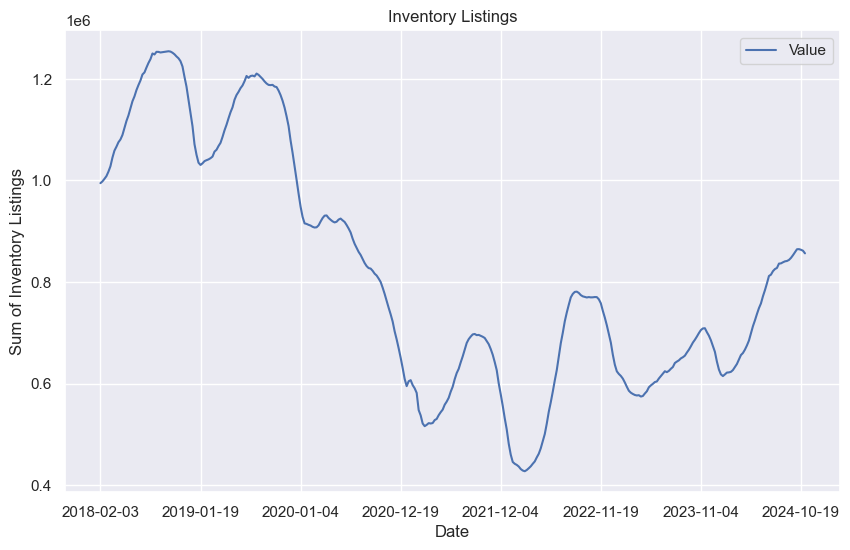

In [67]:
inventory_trend_df = inventory_cleaned_df.groupby("Date")["Value"].sum().reset_index()
inventory_trend_df.plot(x="Date", y="Value", figsize=(10, 6), linestyle="-", title="Inventory Listings", xlabel="Date", ylabel="Sum of Inventory Listings", grid=True)


**Trend of Sale Prices over time**

<Axes: title={'center': 'Sale Prices'}, xlabel='Date', ylabel='Sum of Sale Prices'>

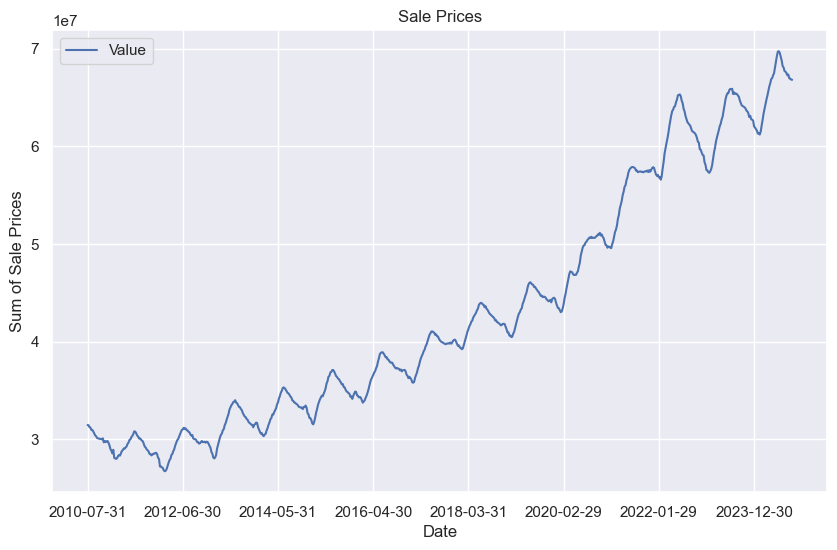

In [68]:
sales_trend_df = sales_cleaned_df.groupby("Date")["Value"].sum().reset_index()
sales_trend_df.plot(x="Date", y="Value", figsize=(10, 6), linestyle="-", title="Sale Prices", xlabel="Date", ylabel="Sum of Sale Prices", grid=True)


### Trend Analysis Conclusion

The charts show that **inventory listings are decreasing** over time, while **sale prices are steadily increasing**. This suggests that fewer homes are available, which is likely driving prices up.


**Top 10 states for inventory listings**

/var/folders/y0/rbdj7f755h1cpddq270cg3800000gn/T/ipykernel_29312/327549068.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_10_states["StateName"], rotation=45, ha="right", fontsize=10)


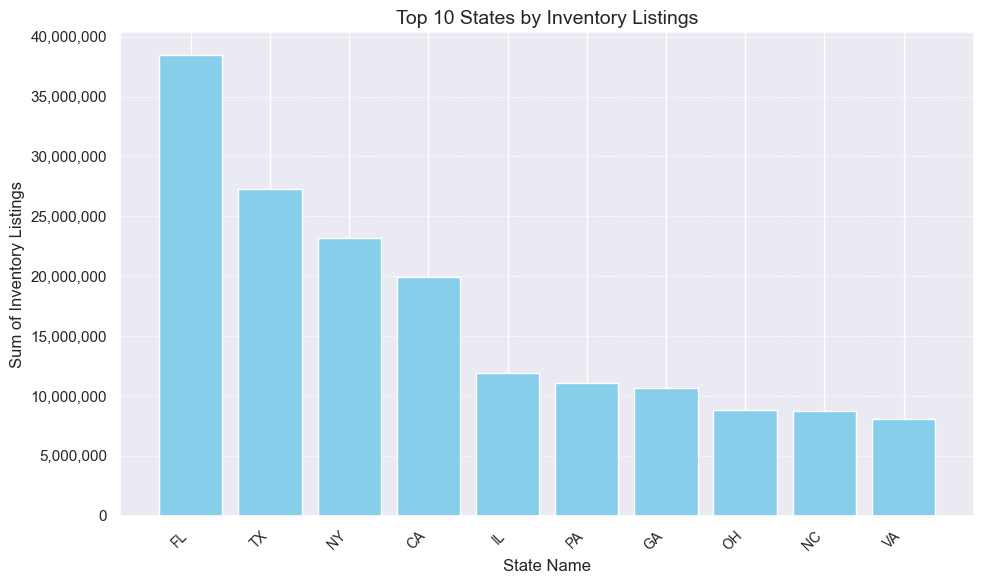

In [69]:
# Group and calculate the total inventory value for each region
inventory_trend_df = inventory_cleaned_df.groupby("StateName")["Value"].sum().reset_index()

# Sort by "Value" in descending order and select the top 10 regions
top_10_states = inventory_trend_df.sort_values(by="Value", ascending=False).head(10)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(top_10_states["StateName"], top_10_states["Value"], color="skyblue")

# Add titles and labels
ax.set_title("Top 10 States by Inventory Listings", fontsize=14)
ax.set_xlabel("State Name", fontsize=12)
ax.set_ylabel("Sum of Inventory Listings", fontsize=12)

# Rotate x-axis labels for readability
ax.set_xticklabels(top_10_states["StateName"], rotation=45, ha="right", fontsize=10)

# Format the y-axis to show full values
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))  # Adds commas and removes scientific notation


# Add grid
ax.grid(axis="y", linestyle="--", linewidth=0.5)

# Show the plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


**Top 10 states for sale prices**

/var/folders/y0/rbdj7f755h1cpddq270cg3800000gn/T/ipykernel_29312/2700915036.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_10_states["StateName"], rotation=45, ha="right", fontsize=10)


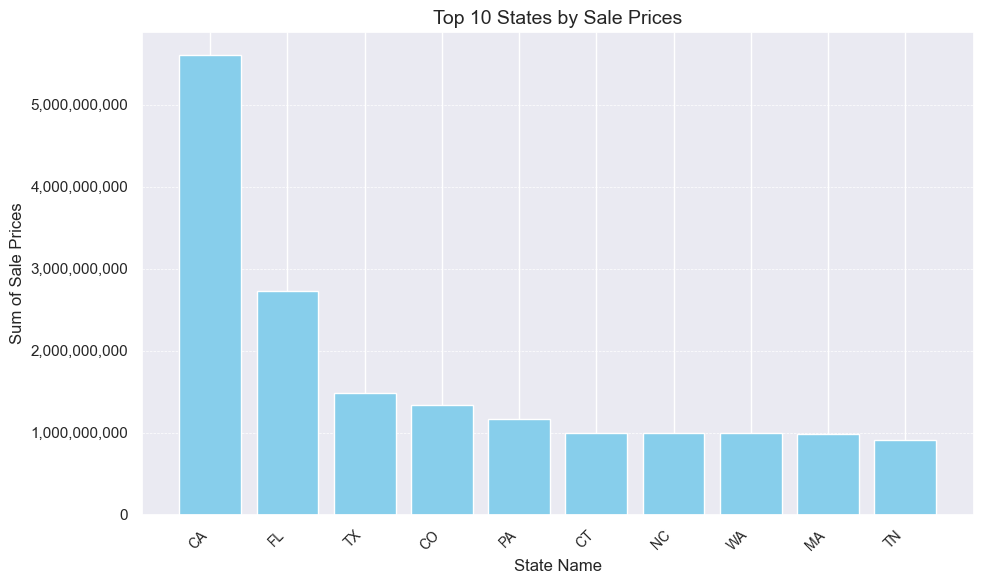

In [70]:
# Group and calculate the total inventory value for each region
sales_trend_df = sales_cleaned_df.groupby("StateName")["Value"].sum().reset_index()

# Sort by "Value" in descending order and select the top 10 regions
top_10_states = sales_trend_df.sort_values(by="Value", ascending=False).head(10)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(top_10_states["StateName"], top_10_states["Value"], color="skyblue")

# Add titles and labels
ax.set_title("Top 10 States by Sale Prices", fontsize=14)
ax.set_xlabel("State Name", fontsize=12)
ax.set_ylabel("Sum of Sale Prices", fontsize=12)

# Rotate x-axis labels for readability
ax.set_xticklabels(top_10_states["StateName"], rotation=45, ha="right", fontsize=10)

# Format the y-axis to show full values
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))  # Adds commas and removes scientific notation


# Add grid
ax.grid(axis="y", linestyle="--", linewidth=0.5)

# Show the plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


# When And Where To Invest

In order to understand if we should wait to invest or should I invest now we can look at the Zillow's forecast. The forecast dataset contains *home values* based on a Zillow's Home Value Index. The dataset predicts the home value for November 2024, January 2025 and October 2025. 

The Home Value Index is calculated based on multiple features that the Zillow website collects.

> The core tech for the previous Zestimate algorithm used random forests, an algorithmic approach that filtered homes into ever narrowing price buckets using property and listing information. The end result is a set of similar homes with prices that jointly minimizes the error between the model’s predictions (the Zestimates) and actual, observed sale prices. the new neural network-based approach has several major advantages. First and foremost, it can handle A LOT more data allowing the models to learn about the price of homes across time and beyond county borders flexibly and responsively.

The dataset contains the `zip` code and the `RegionID` which can be used later to select the geographical area in the United States that we can invest.

We will be using the Zillow's Median Sale Prices Adjusted dataset to understand what are the median house price for the identified investment will be, to check if we follow the 12 million dollars budget.

In [71]:
print(zip_codes.head())
print(zip_codes.dtypes)
print(us_states.head())
print(us_states.dtypes)
print('Zillow Forecast of Home Values dataset')
print(f'Size: {len(forecastByZip)}')
print(forecastByZip.dtypes)
display(forecastByZip.head())
print('US Median Sale Price dataset')
print(f'Size: {len(meadianSalePrices)}')
print(meadianSalePrices.dtypes)
display(meadianSalePrices.head())

  ZCTA5CE20 GEOID20       GEOIDFQ20 CLASSFP20 MTFCC20 FUNCSTAT20  ALAND20  \
0     47236   47236  860Z200US47236        B5   G6350          S  1029063   
1     47870   47870  860Z200US47870        B5   G6350          S     8830   
2     47851   47851  860Z200US47851        B5   G6350          S    53326   
3     47337   47337  860Z200US47337        B5   G6350          S   303089   
4     47435   47435  860Z200US47435        B5   G6350          S    13302   

   AWATER20   INTPTLAT20    INTPTLON20  \
0         0  +39.1517426  -085.7252769   
1         0  +39.3701518  -087.4735141   
2         0  +39.5735839  -087.2459559   
3         0  +39.8027537  -085.4372850   
4         0  +39.2657557  -086.2951577   

                                            geometry  
0  POLYGON ((-85.7341 39.15597, -85.72794 39.1561...  
1  POLYGON ((-87.47414 39.37016, -87.47409 39.370...  
2  POLYGON ((-87.24769 39.5745, -87.24711 39.5744...  
3  POLYGON ((-85.44357 39.80328, -85.44346 39.803...  
4  POLYGO

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,BaseDate,2024-11-30,2025-01-31,2025-10-31
0,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,2024-10-31,0.0,-0.2,0.6
1,61148,2,8701,zip,NJ,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,2024-10-31,0.4,0.6,1.8
2,91940,3,77449,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,2024-10-31,-0.3,-0.8,0.3
3,62080,4,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2024-10-31,-0.1,-0.3,0.5
4,91733,5,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,2024-10-31,-0.2,-0.6,0.4


US Median Sale Price dataset
Size: 714
RegionID        int64
SizeRank        int64
RegionName     object
RegionType     object
StateName      object
               ...   
2024-05-31    float64
2024-06-30    float64
2024-07-31    float64
2024-08-31    float64
2024-09-30    float64
Length: 79, dtype: object


,RegionID,SizeRank,RegionName,RegionType,StateName,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
0,102001,0,United States,country,NaN,226464.0,225849.0,226543.0,227654.0,228643.0,...,334503.0,335121.0,339431.0,345202.0,349125.0,352081.0,355144.0,357383.0,358468.0,358221.0
1,394913,1,"New York, NY",msa,NY,397636.0,395248.0,395611.0,396926.0,396567.0,...,603185.0,605647.0,608658.0,612170.0,617987.0,627793.0,641076.0,651363.0,655123.0,654488.0
2,753899,2,"Los Angeles, CA",msa,CA,673718.0,669784.0,670135.0,668451.0,663329.0,...,919376.0,917801.0,923357.0,932840.0,948535.0,958927.0,969256.0,970001.0,956885.0,944886.0
3,394463,3,"Chicago, IL",msa,IL,229945.0,228880.0,229653.0,231949.0,231769.0,...,298526.0,300513.0,302807.0,306239.0,308296.0,311049.0,315312.0,320457.0,320957.0,322567.0
4,394514,4,"Dallas, TX",msa,TX,258925.0,254695.0,252172.0,251891.0,252191.0,...,381933.0,383066.0,385045.0,389886.0,391964.0,393948.0,392894.0,392275.0,391197.0,390032.0


### Data Cleaning Of The Forecast Dataset

We have decided to not remove any empty values, because the `City` and the `Metro` value can be infer it by the zip code or other data.

The `RegionName` column in reality is the `ZipCode` which we will rename.

In [72]:
# Data Cleaning Forecast By Zip
forecastByZip = forecastByZip.rename(columns={'RegionName': 'ZipCode'})
forecastByZip['ZipCode'] = forecastByZip['ZipCode'].astype(str).str.zfill(5)
print(f'Number of duplicate rows: {forecastByZip[forecastByZip.duplicated()].shape}')
print()
print(f'Number of rows:\n{forecastByZip.count()}')
print()
print('Number of empty rows:')
print(forecastByZip.isnull().sum())

Number of duplicate rows: (0, 13)

Number of rows:
RegionID      20161
SizeRank      20161
ZipCode       20161
RegionType    20161
StateName     20161
State         20161
City          19502
Metro         20091
CountyName    20161
BaseDate      20161
2024-11-30    20161
2025-01-31    20161
2025-10-31    20161
dtype: int64

Number of empty rows:
RegionID        0
SizeRank        0
ZipCode         0
RegionType      0
StateName       0
State           0
City          659
Metro          70
CountyName      0
BaseDate        0
2024-11-30      0
2025-01-31      0
2025-10-31      0
dtype: int64


### Data Exploration: The Zillow Forecast Of Home Values

With boxplots and histograms we are able to better understand how the data is distributed. It looks like that the more you wait the higher prices will grow. From the Zillow's forcast models we noticed that the average home value will increase by 1.7 points in the month of October 2025.

In [73]:
nov_2024_avg = np.around(forecastByZip['2024-11-30'].mean(), decimals=4, out=None)
jan_2025_avg = np.around(forecastByZip['2025-01-31'].mean(), decimals=4, out=None)
oct_2025_avg = np.around(forecastByZip['2025-10-31'].mean(), decimals=4, out=None)

print(f'November 2024 average forcast: {nov_2024_avg}')
print(f'January 2025 average forcast: {jan_2025_avg}')
print(f'October 2025 average forcast: {oct_2025_avg}')

November 2024 average forcast: 0.0934
January 2025 average forcast: 0.3384
October 2025 average forcast: 1.7423


In [74]:
forecast_min_value = min(forecastByZip['2024-11-30'].min(), forecastByZip['2025-01-31'].min(), forecastByZip['2025-10-31'].min())
forecast_max_value = max(forecastByZip['2024-11-30'].max(), forecastByZip['2025-01-31'].max(), forecastByZip['2025-10-31'].max())

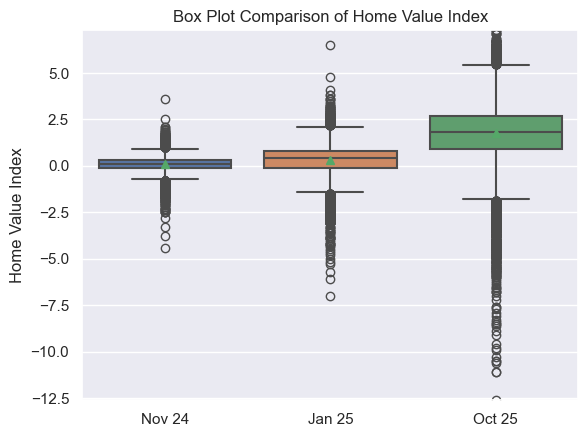

In [75]:
boxplot_data = [forecastByZip['2024-11-30'], forecastByZip['2025-01-31'], forecastByZip['2025-10-31']]
sns.boxplot(
    data=boxplot_data,
    showmeans=True,
    linewidth=1.5
)
plt.xticks([0, 1, 2], ['Nov 24', 'Jan 25', 'Oct 25'])
plt.ylabel('Home Value Index')
plt.title('Box Plot Comparison of Home Value Index')
plt.xlim(-0.5, 2.5)  # Adjust limits as needed
plt.ylim(forecast_min_value, forecast_max_value)
plt.show()

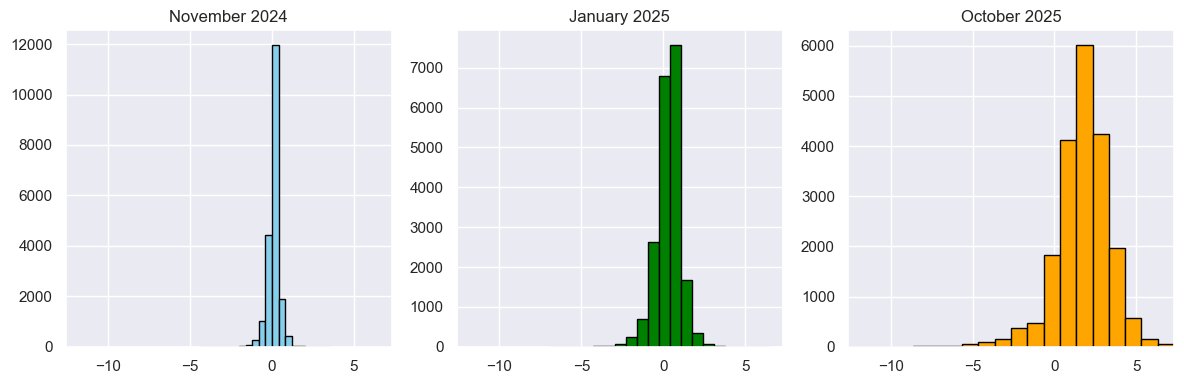

In [76]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
axes[0].hist(forecastByZip['2024-11-30'], bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('November 2024')
axes[0].set_xlim(forecast_min_value, forecast_max_value)
axes[1].hist(forecastByZip['2025-01-31'], bins=20, color='green', edgecolor='black')
axes[1].set_title('January 2025')
axes[1].set_xlim(forecast_min_value, forecast_max_value)
axes[2].hist(forecastByZip['2025-10-31'], bins=20, color='orange', edgecolor='black')
axes[2].set_title('October 2025')
axes[2].set_xlim(forecast_min_value, forecast_max_value)
plt.tight_layout()
plt.show()

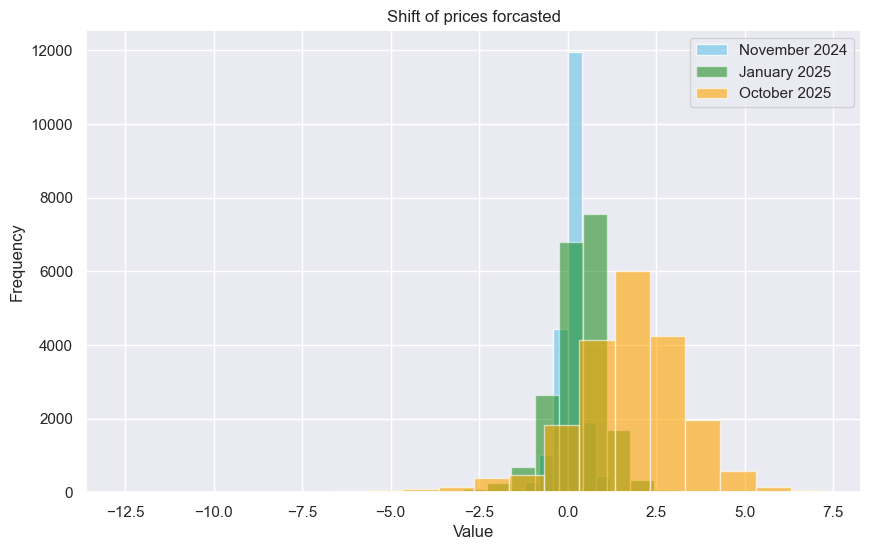

In [77]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(forecastByZip['2024-11-30'], bins=20, color='skyblue', alpha=0.8, label='November 2024')
ax.hist(forecastByZip['2025-01-31'], bins=20, color='green', alpha=0.5, label='January 2025')
ax.hist(forecastByZip['2025-10-31'], bins=20, color='orange', alpha=0.6, label='October 2025')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Shift of prices forcasted')
ax.legend()
plt.show()

### Buying Now To Sell In October 2025

The boxplots and the histograms are showing that the prices of some houses will eventually increase by October 2025. Based on Zillow's forcasting model.

Overall, Zillow is forcasting that Home Values will increase until October 2025, therefore we should be investing now in the geographical regions that will have the highest Home Value forecast increase.

### Exploring Where To Invest

By looking at the highest home values increase by October 2025, we can investage to invest in:
- Berlin, NH
- Stratford, NH
- Clewiston, FL
- Stockett, MT
- Margate City, NJ
- Longport, NJ
- Felda, FL
- Lake Toxaway, NC
- Atlantic City, NJ
- Pine Hill, NY

In [78]:
top10_nov24 = forecastByZip.nlargest(10, '2024-11-30')
top10_jan25 = forecastByZip.nlargest(10, '2025-01-31')
top10_nov25 = forecastByZip.nlargest(10, '2025-10-31')
display(top10_nov24[['RegionID', 'City', 'StateName', '2024-11-30']])
display(top10_jan25[['RegionID', 'City', 'StateName', '2025-01-31']])
display(top10_nov25[['RegionID', 'City', 'StateName', '2025-10-31']])

,RegionID,City,StateName,2024-11-30
11846,79944,Kincheloe,MI,3.6
15885,62218,Great River,NY,2.5
16634,60156,Hartford,CT,2.1
16881,84985,La Harpe,IL,2.1
15725,86235,Senath,MO,2.0
14101,85558,Mount Pulaski,IL,1.9
16249,81459,Cassville,WI,1.9
17031,85188,Fithian,IL,1.8
17193,85224,Ashmore,IL,1.8
17552,85597,NaN,IL,1.8


,RegionID,City,StateName,2025-01-31
11846,79944,Kincheloe,MI,6.5
15885,62218,Great River,NY,4.8
16881,84985,La Harpe,IL,4.1
16249,81459,Cassville,WI,3.8
17859,75543,Payneville,KY,3.8
14116,65577,Luzerne,PA,3.6
17613,85167,Bismarck,IL,3.6
18856,74967,Clarksdale,MS,3.6
16634,60156,Hartford,CT,3.5
17031,85188,Fithian,IL,3.4


,RegionID,City,StateName,2025-10-31
9431,59145,Berlin,NH,7.3
17267,59159,Stratford,NH,7.3
5464,72606,Clewiston,FL,7.2
17675,84083,Stockett,MT,7.2
11579,61075,Margate City,NJ,7.1
17929,61076,Longport,NJ,7.1
19663,72919,Felda,FL,7.1
15791,70191,Lake Toxaway,NC,6.9
2131,61074,Atlantic City,NJ,6.8
19631,62588,Pine Hill,NY,6.8


### Finding Where To Buy

Now that we know some of the , we can decide to invest in the area where the median home prices are the lowest.

In [79]:
# Merge the dataframe on RegionID
merged_df_median_sale_by_regionID = top10_nov25.merge(meadianSalePrices, on='RegionID')
# This returned an empty dataframe, because the median dataset does not have these regionID
print(f'Size of median sale price by RegionID: {len(merged_df_median_sale_by_regionID)} \n')
# We can now try it by finding the Median Sale Price of the City
top10_nov25['CityState'] = top10_nov25['City'] + ', ' + top10_nov25['StateName']
print(top10_nov25['CityState'])

Size of median sale price by RegionID: 0 

9431            Berlin, NH
17267        Stratford, NH
5464         Clewiston, FL
17675         Stockett, MT
11579     Margate City, NJ
17929         Longport, NJ
19663            Felda, FL
15791     Lake Toxaway, NC
2131     Atlantic City, NJ
19631        Pine Hill, NY
Name: CityState, dtype: object


In [80]:
# Check if the dataframe contains the CityState
print(f'Atlantic City, NJ found: {len(meadianSalePrices[meadianSalePrices['RegionName'] == 'Atlantic City, NJ'])}')
print(f'Berlin, NH not found: {len(meadianSalePrices[meadianSalePrices['RegionName'] == 'Berlin, NH'])}')
print(f'Stratford, NH not found: {len(meadianSalePrices[meadianSalePrices['RegionName'] == 'Stratford, NH'])}')

# Something we could have done if we had the data
top10_nov25Copy = top10_nov25
col_to_move = top10_nov25Copy.pop('CityState')
top10_nov25Copy.insert(len(top10_nov25Copy.columns), 'CityState', col_to_move)
merged_df_median_sale_by_citystate = top10_nov25Copy.merge(meadianSalePrices, left_on='CityState', right_on='RegionName')
display(merged_df_median_sale_by_citystate)

Atlantic City, NJ found: 1
Berlin, NH not found: 0
Stratford, NH not found: 0


,RegionID_x,SizeRank_x,ZipCode,RegionType_x,StateName_x,State,City,Metro,CountyName,BaseDate,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
0,72606,5571,33440,zip,FL,FL,Clewiston,"Clewiston, FL",Hendry County,2024-10-31,...,54867.0,50522.0,44103.0,62821.0,94934.0,94676.0,91307.0,93436.0,137805.0,165601.0
1,61074,2168,08401,zip,NJ,NJ,Atlantic City,"Atlantic City-Hammonton, NJ",Atlantic County,2024-10-31,...,342057.0,334362.0,342081.0,343941.0,350880.0,357040.0,353469.0,349884.0,345772.0,347741.0


The Median Price Sale dataset does not contian all cities in the United States. Therefore we don't have the data to determine which city is cheaper to invest.

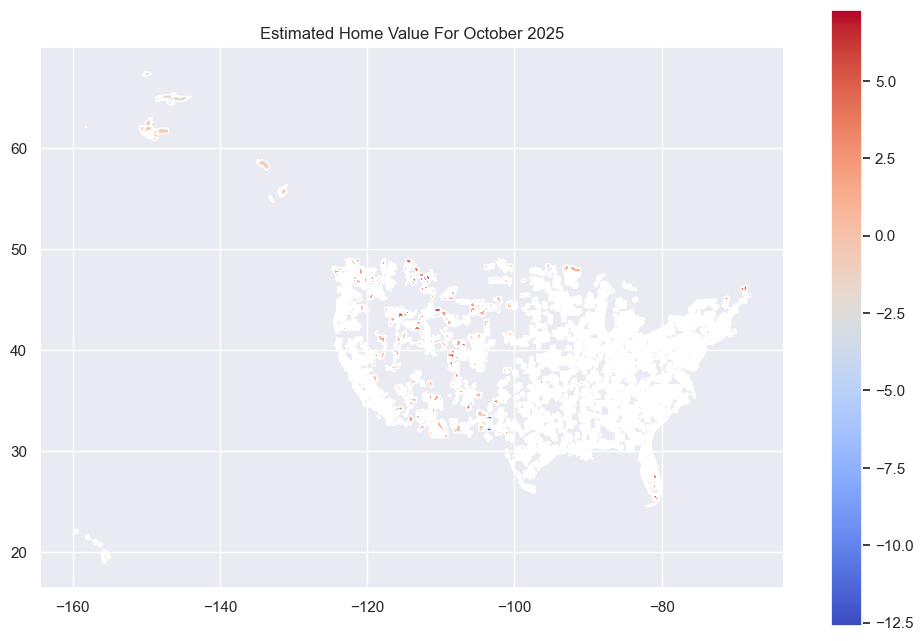

In [81]:
forecastByZipCopy = forecastByZip

col_to_move = forecastByZipCopy.pop('ZipCode')
forecastByZipCopy.insert(len(forecastByZipCopy.columns), 'ZipCode', col_to_move)
map_zip_df = zip_codes.merge(forecastByZipCopy, left_on='ZCTA5CE20', right_on='ZipCode')

fig, ax = plt.subplots(1, figsize=(12, 8))
map_zip_df.plot(column='2025-10-31', cmap='coolwarm', ax=ax, legend=True)
ax.set_title('Estimated Home Value For October 2025')
#ax.axis('off')
plt.show()

In [82]:
forecastByState = forecastByZipCopy.groupby('StateName')['2025-10-31'].mean().reset_index()
top5StatesForOct24 = forecastByState.nlargest(10, '2025-10-31')
print(top5StatesForOct24)

   StateName  2025-10-31
21        ME    4.450704
26        MT    4.228736
30        NH    4.227215
6         CT    3.624324
39        RI    3.536232
13        ID    3.022667
42        TN    3.008409
15        IN    2.980492
27        NC    2.801997
8         DE    2.733898


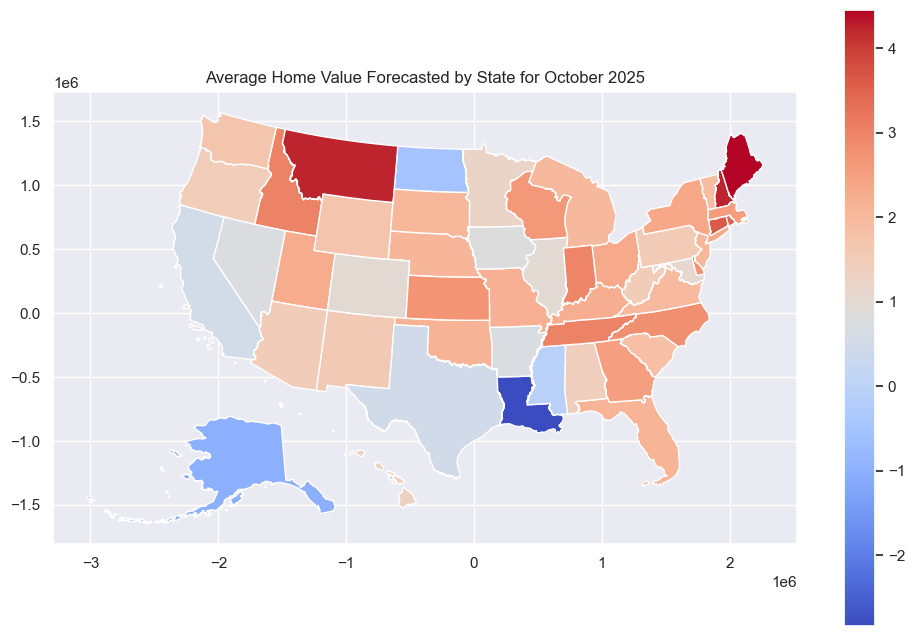

In [83]:
forecast_map_state_df = us_states.merge(forecastByState, left_on='STUSPS', right_on='StateName')

fig, ax = plt.subplots(1, figsize=(12, 8))
forecast_map_state_df.plot(column='2025-10-31', cmap='coolwarm', ax=ax, legend=True)
ax.set_title('Average Home Value Forecasted by State for October 2025')
plt.show()

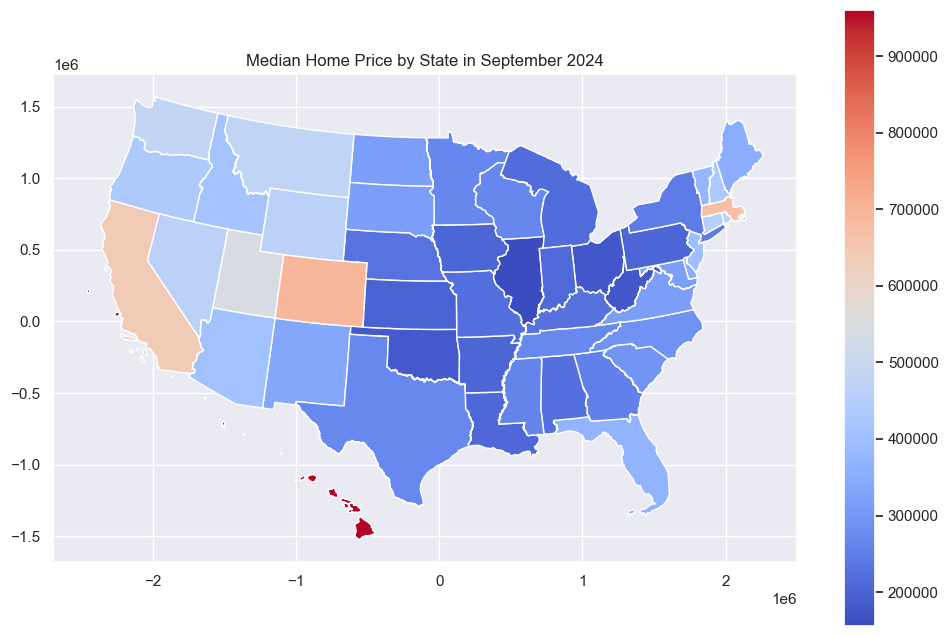

In [84]:
medianSalesCopy = meadianSalePrices

medianSalesByState = medianSalesCopy.groupby('StateName')['2024-09-30'].mean().reset_index()
col_to_move = medianSalesByState.pop('StateName')
medianSalesByState.insert(len(medianSalesByState.columns), 'StateName', col_to_move)
map_states_median_df = us_states.merge(medianSalesByState, left_on='STUSPS', right_on='StateName')

fig, ax = plt.subplots(1, figsize=(12, 8))
map_states_median_df.plot(column='2024-09-30', cmap='coolwarm', ax=ax, legend=True)
ax.set_title('Median Home Price by State in September 2024')
plt.show()

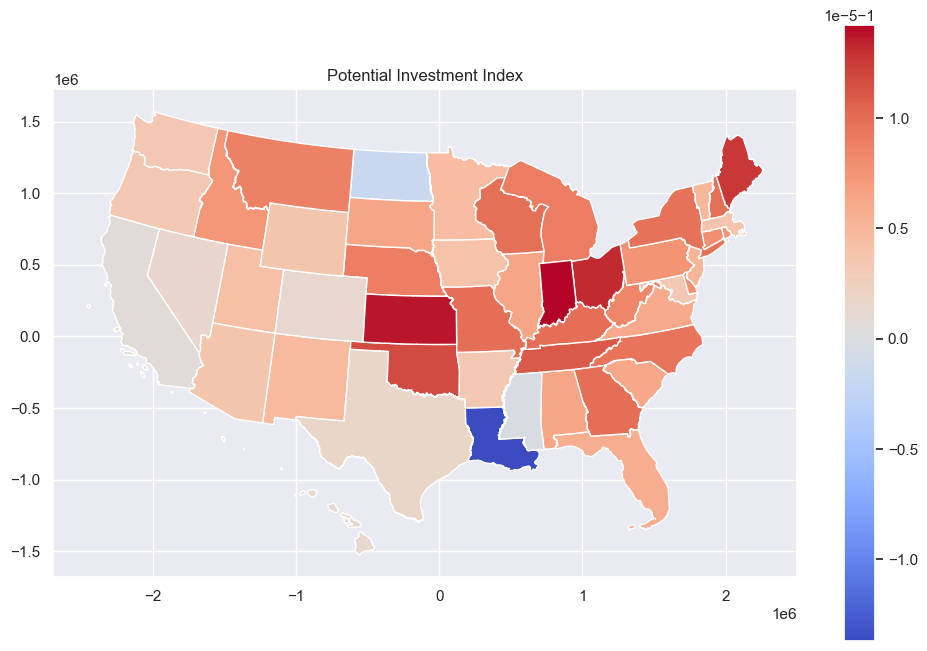

In [85]:
median_value_df = forecastByState.merge(medianSalesByState)
median_value_df = median_value_df.rename(columns={'2025-10-31': 'HomeValue', '2024-09-30': 'MedianPrice'})
median_value_df['PotentialInvestmentIndex'] = (median_value_df['HomeValue'] / median_value_df['MedianPrice']) - 1

map_states_pip_df = us_states.merge(median_value_df, left_on='STUSPS', right_on='StateName')

fig, ax = plt.subplots(1, figsize=(12, 8))
map_states_pip_df.plot(column='PotentialInvestmentIndex', cmap='coolwarm', ax=ax, legend=True)
ax.set_title('Potential Investment Index')
plt.show()

In [86]:
top = top10_nov25.merge(median_value_df, on='StateName')
top = top.rename(columns={'HomeValue': 'StateHomeValue', '2025-10-31': 'ForecastedHomeValue'})
top = top[['City', 'StateName', 'ForecastedHomeValue', 'StateHomeValue', 'MedianPrice', 'PotentialInvestmentIndex']]
display(top)

,City,StateName,ForecastedHomeValue,StateHomeValue,MedianPrice,PotentialInvestmentIndex
0,Berlin,NH,7.3,4.227215,429470.500000,-0.999990
1,Stratford,NH,7.3,4.227215,429470.500000,-0.999990
2,Clewiston,FL,7.2,2.108266,368253.230769,-0.999994
3,Stockett,MT,7.2,4.228736,477568.714286,-0.999991
4,Margate City,NJ,7.1,2.051920,396868.250000,-0.999995
5,Longport,NJ,7.1,2.051920,396868.250000,-0.999995
6,Felda,FL,7.1,2.108266,368253.230769,-0.999994
7,Lake Toxaway,NC,6.9,2.801997,292866.243243,-0.999990
8,Atlantic City,NJ,6.8,2.051920,396868.250000,-0.999995
9,Pine Hill,NY,6.8,2.362529,244207.520000,-0.999990


![Berlin](https://img.bestplaces.net/images/states/new_hampshire.jpg)

### Conclusions: Invest In Berlin, Stratford And Pine Hill

Based on the Forcasted Home Value, it would be good to invest today in either New Hampshire, Florida, Montana, New Jersey, North Carolina and New York.

Investing in Pine Hill, New York, would be a great place to invest in case it is important to invest in multiple cheaper houses, because the state median price in September 2024 is the lowest and the forecasted Home Value will increase by the end of 2025. Although if there are no restrctions in the Median Price, Berlin or Stratford, New Hampshire, are the best cities to invest and buy a home, because the Forecasted Home Value for 2025 will be the highest.

# !!!! Charlies section

# Calculating the Return on Investement for Single-Family Home Sales
For any investment, we want to know how much we can make from the investment. Especially when intrest rates are high, investing in index funds may generate good ROI with low risk. To know if our investment is worth it, we need the following inputs. 

* **Purchase Cost** this is how much we're paying upfront for the properties we're buying.
* **Renovation Cost** this is how much we're spending on upgrades.
* **Holding Cost** while we own the property, how much is it costing us in terms of taxes, utilites, insurance, and upkeep. We will assume a fixed amount per property.
* **Financing Cost** we're making mortage payments while we've the property. How much interest is it costing us?
* **Selling Cost** typically, we would have an broker who takes a commission plus closing costs. Typically, this sets around 3-6% of the sale price.
* **Final Sale Price** how much we're selling each property for.

To acquire those inputs, we will look into the data Zillow provides. We won't find all the data such holding and selling costs, so we will use estimates or use other data sets to acquire those inputs. 

First, we need to build our investment portfolio and we start by identifying high growth markets. 

## Identifying High Growth Markets
First, we need to identify high growth market where we can have high return on investment. Zillow Home Value Index is a home price estimation from Zillow that we can use to identify high growth markets. So we will use the `ZHVI Single-Family Homes Time Series ($)` dataset. Zillow provides a forecast dataset, but the dataset covers all home types, so we will have to build our own based on the investor intrest.  

First, let's load the data and inspect some top and bottom rows.

In [87]:
# Load the Zillow dataset
df = pd.read_csv('./data/sfh_ts.csv')
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
0,102001,0,United States,country,NaN,121531.336651,121738.651072,121995.876446,122548.308184,123184.186238,...,350593.674816,351419.563807,352981.682891,354901.213108,356405.219291,357054.866170,357269.495250,357556.470130,358047.728564,358695.400157
1,394913,1,"New York, NY",msa,NY,215526.347853,216437.299774,217353.388393,219206.206623,221115.123983,...,653024.167946,657325.710093,662976.463941,669457.862304,674379.010648,677580.634957,680209.743078,683834.502366,687956.181425,691747.775297
2,753899,2,"Los Angeles, CA",msa,CA,228840.318549,229713.653329,230850.552728,233116.339880,235575.321729,...,961240.278183,958067.128774,956942.083361,960982.286878,967579.982979,972048.452546,976772.555536,982347.195293,989199.485026,994897.480686
3,394463,3,"Chicago, IL",msa,IL,156308.333980,156460.092041,156739.556227,157434.724023,158265.478146,...,323407.920786,325014.621277,327666.811355,330756.679881,333074.201792,334422.582458,335234.282077,336199.561203,337340.532590,338506.114351
4,394514,4,"Dallas, TX",msa,TX,126045.193158,126100.940737,126169.731762,126344.177104,126568.833701,...,371215.184232,371698.224857,372852.439583,373826.243574,373978.341627,373322.949324,372396.923106,371759.173084,371580.012878,371494.296639


In [88]:
df.tail()

,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
890,753929,935,"Zapata, TX",msa,TX,NaN,NaN,NaN,NaN,NaN,...,125505.480365,124620.859170,124703.453283,126217.346418,127940.190271,129029.544547,129216.203575,128841.856015,128169.963134,127248.665154
891,394743,936,"Ketchikan, AK",msa,AK,NaN,NaN,NaN,NaN,NaN,...,411724.194103,411668.716287,413385.593811,415037.934548,416247.744981,416235.514828,415323.647956,415325.998281,416842.773776,419086.682223
892,753874,937,"Craig, CO",msa,CO,98830.861837,99097.911211,99574.805478,100259.229234,101040.616567,...,285287.949217,285219.875814,285685.290380,286463.285398,287357.918108,287698.710801,288033.677233,288266.115146,289594.833055,291259.120524
893,395188,938,"Vernon, TX",msa,TX,NaN,NaN,NaN,NaN,NaN,...,91184.718655,91281.020656,91975.182494,92739.898571,93395.868423,93641.985168,93402.487663,92893.101563,91612.695630,90013.700765
894,394767,939,"Lamesa, TX",msa,TX,NaN,NaN,NaN,NaN,NaN,...,88711.311676,87596.741991,87637.262603,87847.018796,88770.521386,90064.663210,91903.350319,93542.740242,94253.311435,94265.128384


From the initial look, we can quickly spot the following
* The data is optimized for size, so each region has a single row and each estimation is a value in a date column.
* We've some null values for older dates in some regions.

In [89]:
# Let's confirm our assumption about "each region is a single row"
df[df.duplicated(subset='RegionID', keep=False)]

,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31


In [90]:
# Let's drop any fields we're not going to use. We're keeping RegionID because it's safer to use than RegionName
# which contains white space. Additionally, we will use RegionID to interact with other datasets from Zillow
# we also should keep state names in case we need to deal with aggregate date at state-level
single_home_values = df.drop(columns=['SizeRank', 'RegionType'])
single_home_values.head()

,RegionID,RegionName,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
0,102001,United States,NaN,121531.336651,121738.651072,121995.876446,122548.308184,123184.186238,123865.680213,124586.279073,...,350593.674816,351419.563807,352981.682891,354901.213108,356405.219291,357054.866170,357269.495250,357556.470130,358047.728564,358695.400157
1,394913,"New York, NY",NY,215526.347853,216437.299774,217353.388393,219206.206623,221115.123983,223259.025429,225613.438183,...,653024.167946,657325.710093,662976.463941,669457.862304,674379.010648,677580.634957,680209.743078,683834.502366,687956.181425,691747.775297
2,753899,"Los Angeles, CA",CA,228840.318549,229713.653329,230850.552728,233116.339880,235575.321729,238017.327535,240515.010731,...,961240.278183,958067.128774,956942.083361,960982.286878,967579.982979,972048.452546,976772.555536,982347.195293,989199.485026,994897.480686
3,394463,"Chicago, IL",IL,156308.333980,156460.092041,156739.556227,157434.724023,158265.478146,159199.059474,160194.910072,...,323407.920786,325014.621277,327666.811355,330756.679881,333074.201792,334422.582458,335234.282077,336199.561203,337340.532590,338506.114351
4,394514,"Dallas, TX",TX,126045.193158,126100.940737,126169.731762,126344.177104,126568.833701,126796.407950,127030.425355,...,371215.184232,371698.224857,372852.439583,373826.243574,373978.341627,373322.949324,372396.923106,371759.173084,371580.012878,371494.296639


In [91]:
# We can note that we've an entry for the United States which we don't need, so let's also drop this row.
single_home_values.drop(0, inplace=True)
single_home_values.head()

,RegionID,RegionName,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
1,394913,"New York, NY",NY,215526.347853,216437.299774,217353.388393,219206.206623,221115.123983,223259.025429,225613.438183,...,653024.167946,657325.710093,662976.463941,669457.862304,674379.010648,677580.634957,680209.743078,683834.502366,687956.181425,691747.775297
2,753899,"Los Angeles, CA",CA,228840.318549,229713.653329,230850.552728,233116.339880,235575.321729,238017.327535,240515.010731,...,961240.278183,958067.128774,956942.083361,960982.286878,967579.982979,972048.452546,976772.555536,982347.195293,989199.485026,994897.480686
3,394463,"Chicago, IL",IL,156308.333980,156460.092041,156739.556227,157434.724023,158265.478146,159199.059474,160194.910072,...,323407.920786,325014.621277,327666.811355,330756.679881,333074.201792,334422.582458,335234.282077,336199.561203,337340.532590,338506.114351
4,394514,"Dallas, TX",TX,126045.193158,126100.940737,126169.731762,126344.177104,126568.833701,126796.407950,127030.425355,...,371215.184232,371698.224857,372852.439583,373826.243574,373978.341627,373322.949324,372396.923106,371759.173084,371580.012878,371494.296639
5,394692,"Houston, TX",TX,122566.394660,122586.615487,122498.107793,122552.473556,122601.663389,122792.886927,122963.068045,...,306485.894827,306879.944577,307878.534350,308913.023118,309454.105049,309335.478400,308972.502773,308770.188744,308740.930953,308583.122732


**Transforming the Data**
Now, let's transform the data to make it possible for calculating month-over-month growth rate. While we're doing this, we will drop home values which is NaN

In [92]:
# Reshape the data. Convert columns to rows using melt()
single_home_values_melted = single_home_values.melt(id_vars=['RegionID', 'RegionName', 'StateName'], 
                    var_name='EestimationDate',
                    value_name='HomeValue')

# Convert 'EestimationDate' to datetime type
single_home_values_melted['EestimationDate'] = pd.to_datetime(single_home_values_melted['EestimationDate'])

# Drop rows where 'HomeValue' is null or zero
single_home_values_final = single_home_values_melted.dropna(subset='HomeValue')

In [93]:
# Verify the cleaning step
print(single_home_values_final.isnull().sum())

RegionID           0
RegionName         0
StateName          0
EestimationDate    0
HomeValue          0
dtype: int64


In [94]:
# Take a look at our transformed table
single_home_values_final.head()

,RegionID,RegionName,StateName,EestimationDate,HomeValue
0,394913,"New York, NY",NY,2000-01-31,215526.347853
1,753899,"Los Angeles, CA",CA,2000-01-31,228840.318549
2,394463,"Chicago, IL",IL,2000-01-31,156308.333980
3,394514,"Dallas, TX",TX,2000-01-31,126045.193158
4,394692,"Houston, TX",TX,2000-01-31,122566.394660


In [95]:
# Ensure date types are accurate
single_home_values_final.dtypes

RegionID                    int64
RegionName                 object
StateName                  object
EestimationDate    datetime64[ns]
HomeValue                 float64
dtype: object

In [96]:
# For simplicity, use the region name as index
single_home_values_final.set_index('RegionName', inplace=True)
single_home_values_final.head()

,RegionID,StateName,EestimationDate,HomeValue
RegionName,,,,
"New York, NY",394913,NY,2000-01-31,215526.347853
"Los Angeles, CA",753899,CA,2000-01-31,228840.318549
"Chicago, IL",394463,IL,2000-01-31,156308.333980
"Dallas, TX",394514,TX,2000-01-31,126045.193158
"Houston, TX",394692,TX,2000-01-31,122566.394660


In [97]:
# Let's calculate our month-over-month change
# Sort the data by RegionID and Date for correct pct_change calculation
single_home_values_final = single_home_values_final.sort_values(by=['RegionID', 'EestimationDate'])

# Calculate the month-over-month change for 'HomeValue'
single_home_values_final['MoM_Change'] = single_home_values_final.groupby('RegionID')['HomeValue'].pct_change() * 100
single_home_values_final.head()

,RegionID,StateName,EestimationDate,HomeValue,MoM_Change
RegionName,,,,,
"Aberdeen, SD",394297,SD,2009-02-28,129498.397203,NaN
"Aberdeen, SD",394297,SD,2009-03-31,129512.232545,0.010684
"Aberdeen, SD",394297,SD,2009-04-30,129314.309011,-0.152822
"Aberdeen, SD",394297,SD,2009-05-31,129201.263533,-0.087419
"Aberdeen, SD",394297,SD,2009-06-30,129003.424531,-0.153125


In [98]:
# As shown above the calculation introduces a null entry per region. This is because pct_change() uses the previous row
# to calculate the change. Let's drop those rows
single_home_values_final = single_home_values_final.dropna(subset=['MoM_Change'])

# Sort by MoM Change (in descending order)
top_25_regions = util.get_top_regions_by_mom_change(single_home_values_final)
display(top_25_regions)

,RegionID,RegionName,MoM_Change
660,395033,"Rockford, IL",0.813178
757,395143,"Syracuse, NY",0.804417
682,395059,"San Jose, CA",0.786331
587,394951,"Oxford, MS",0.764303
91,394397,"Blytheville, AR",0.744494
629,395000,"Pottsville, PA",0.728000
499,394855,"Miami, OK",0.727374
70,394374,"Beckley, WV",0.722711
231,394556,"Edwards, CO",0.716400
310,394643,"Great Bend, KS",0.713209


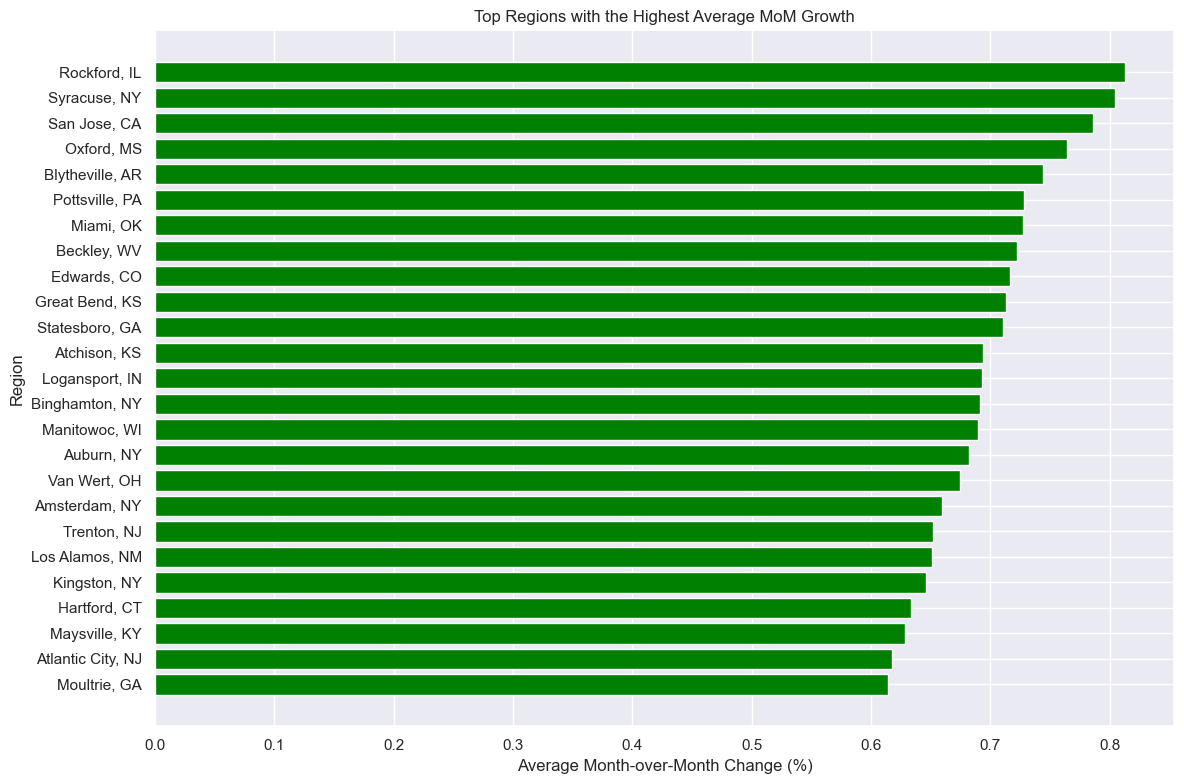

In [99]:
util.plot_top_regions_mom_change(top_25_regions)

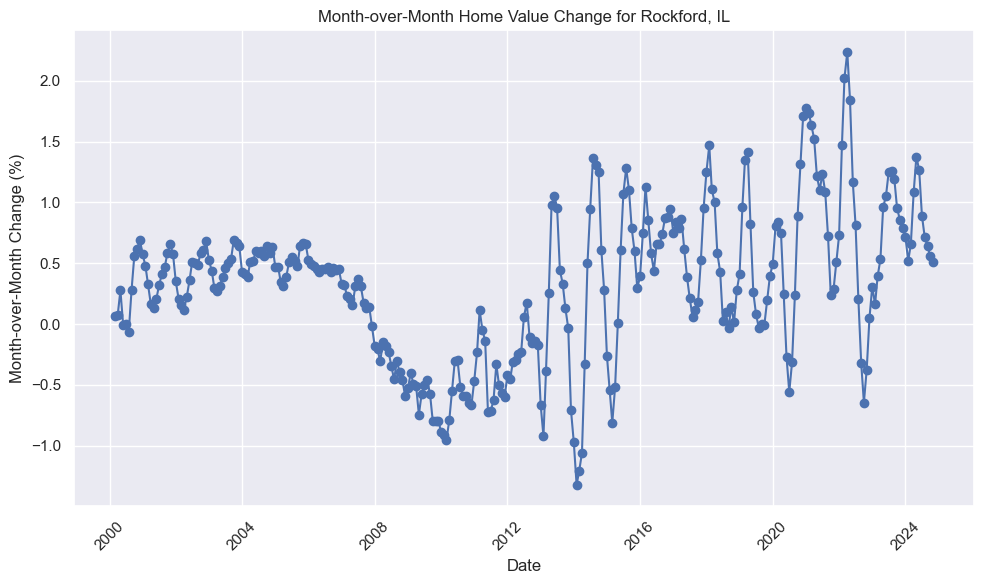

In [100]:
# Show top region entire history of MoM
util.plot_region_mom_change(single_home_values_final[single_home_values_final['RegionID'] == 395033], 'Rockford, IL')

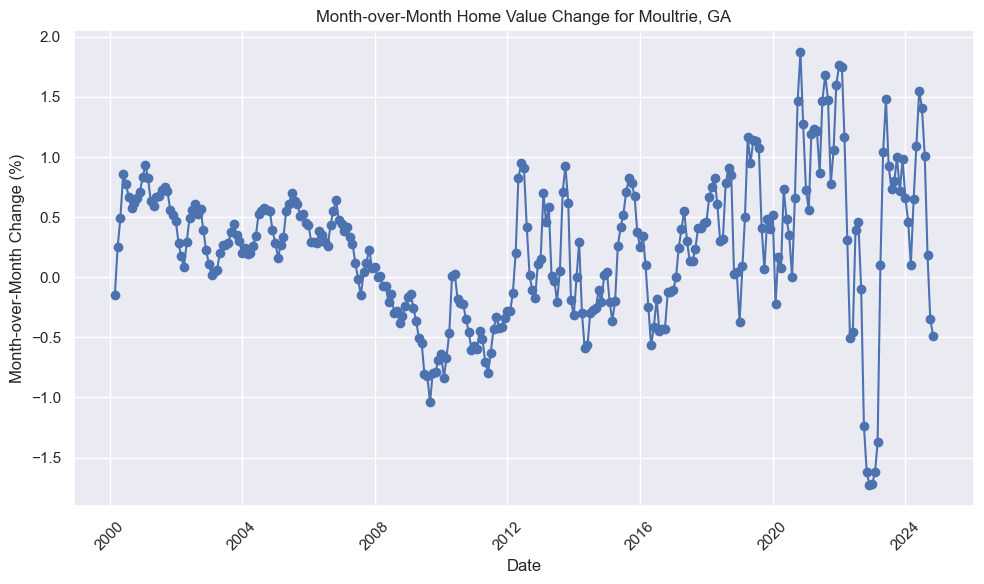

In [101]:
# Show bottom region entire history of MoM
# 394883	Moultrie, GA
util.plot_region_mom_change(single_home_values_final[single_home_values_final['RegionID'] == 394883], 'Moultrie, GA')

Above analysis shows upward trend for home values for the recent years. It also shows what we expect for the financial crisis of 2008 as home values tanked. Since COVID19, we see overall positive, and we expect better outlook for 2025 as the FED continues to cut down interest rates.

## Identifying Holding Period

Holding period is important for calculating many of our ROI parameters. For example, we need to know how long we're holding the unit for to calculate how much financing charges we would incur. Additionally, we need to know the sale date to identify the approximate property sell price. 

Parameters to calculate the holding period:
* **Renovation Time** this is the time we're using to upgrade the property.
* **Days-to-Pending** this is how long the unit is on the market for before a buyer makes an acceptable offer. We will use Zillow dataset to estimate. 
* **Days-to-Close** how many days elapsed since an offer has been accepted till the sale is finalized and legal papers are signed. We will use Zillow dataset to estimate.

We will use forecasted home value for October 31st, 2025 as our sale price to simplify our calculations. This leaves ample time for renovations. We still need Days-to-Pending and Days-to-Close to calculate how long we're holding the unit after we list on it on the market, on October 31st, 2025.

In [102]:
mean_days_to_pending = pd.read_csv('./data/Metro_mean_doz_pending_uc_sfrcondo_sm_month.csv')
mean_days_to_pending.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
0,102001,0,United States,country,NaN,51.0,48.0,45.0,43.0,44.0,...,49.0,52.0,49.0,43.0,39.0,37.0,38.0,41.0,44.0,46.0
1,394913,1,"New York, NY",msa,NY,68.0,65.0,63.0,64.0,66.0,...,68.0,71.0,67.0,58.0,51.0,49.0,49.0,52.0,55.0,58.0
2,753899,2,"Los Angeles, CA",msa,CA,35.0,32.0,31.0,32.0,33.0,...,40.0,41.0,37.0,33.0,30.0,29.0,30.0,33.0,36.0,38.0
3,394463,3,"Chicago, IL",msa,IL,51.0,44.0,40.0,39.0,40.0,...,42.0,43.0,38.0,31.0,26.0,24.0,24.0,25.0,28.0,31.0
4,394514,4,"Dallas, TX",msa,TX,46.0,42.0,38.0,37.0,38.0,...,51.0,52.0,49.0,43.0,39.0,38.0,40.0,45.0,50.0,54.0


In [103]:
# Let's format the data similar to our home value index data
mean_days_to_pending_melted = util.melt_zillow_dataset(mean_days_to_pending, id_fields=['RegionID', 'RegionName',	'StateName'], index_field='RegionName', fields_to_drop=['SizeRank', 'RegionType'], value_col='DaysToPending')
mean_days_to_pending_melted.head()

,RegionID,StateName,Date,DaysToPending
RegionName,,,,
"New York, NY",394913,NY,2018-03-31,68.0
"Los Angeles, CA",753899,CA,2018-03-31,35.0
"Chicago, IL",394463,IL,2018-03-31,51.0
"Dallas, TX",394514,TX,2018-03-31,46.0
"Houston, TX",394692,TX,2018-03-31,49.0


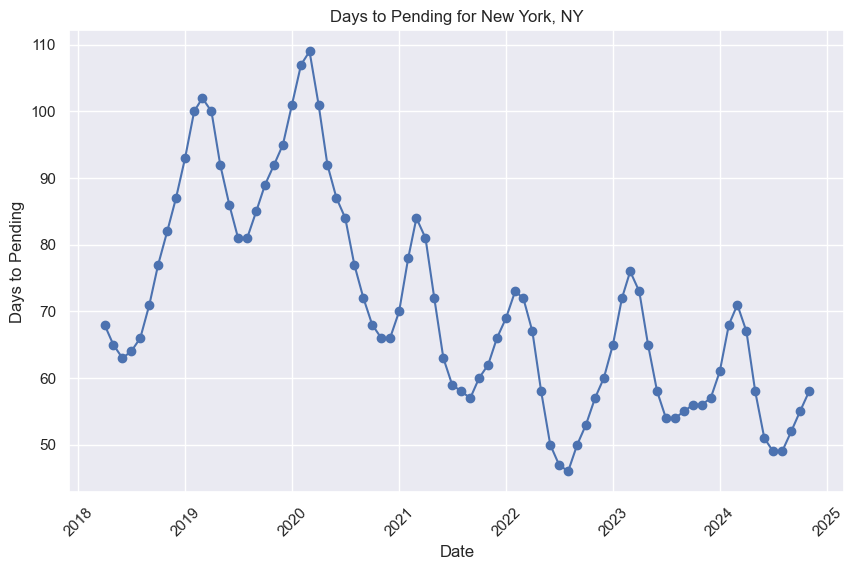

In [104]:
# Filter data for one region (e.g., 'New York, NY')
region_data = mean_days_to_pending_melted[mean_days_to_pending_melted['RegionID'] == 394913]

# Plot the timeline for this region
plt.figure(figsize=(10, 6))
plt.plot(region_data['Date'], region_data['DaysToPending'], marker='o', linestyle='-', color='b')
plt.title('Days to Pending for New York, NY')
plt.xlabel('Date')
plt.ylabel('Days to Pending')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

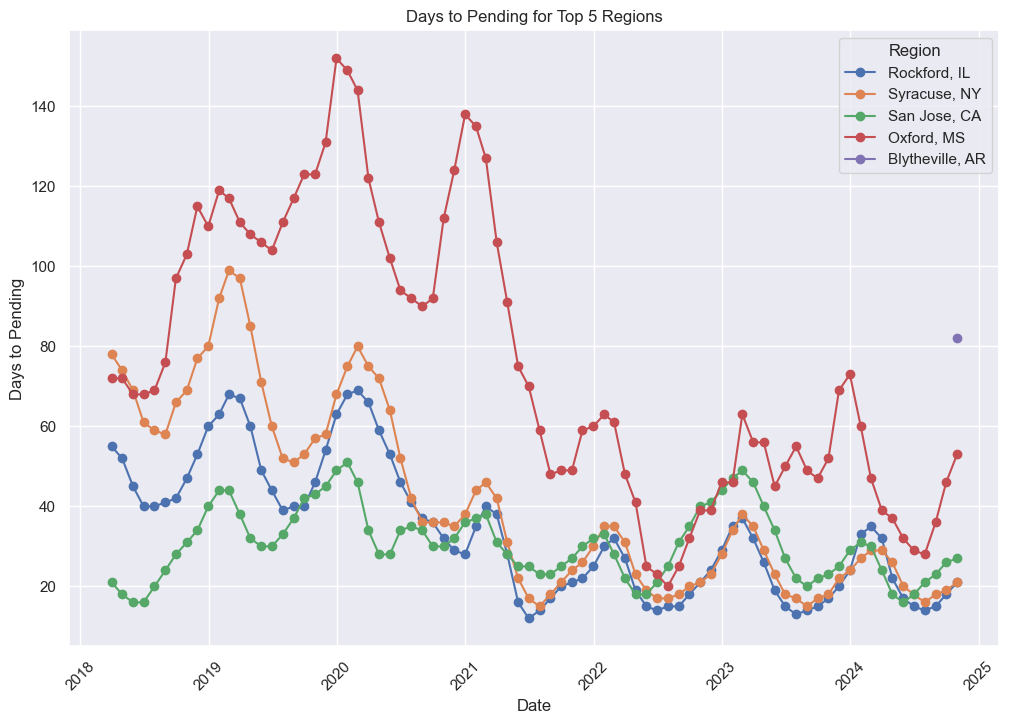

In [105]:
# Trends among our top ten regions
regions_to_plot = top_25_regions.head(5)['RegionID']
multiple_region_data = mean_days_to_pending_melted[mean_days_to_pending_melted['RegionID'].isin(regions_to_plot)].reset_index()

# Plot the timelines for multiple regions
plt.figure(figsize=(12, 8))

for region in regions_to_plot:
    region_data = multiple_region_data[multiple_region_data['RegionID'] == region]
    if not region_data.empty:
        plt.plot(region_data['Date'], region_data['DaysToPending'], marker='o', label=region_data['RegionName'].iloc[0])

plt.title('Days to Pending for Top 5 Regions')
plt.xlabel('Date')
plt.ylabel('Days to Pending')
plt.legend(title='Region')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [106]:
mean_days_to_close = pd.read_csv('./data/Metro_mean_days_to_close_uc_sfrcondo_sm_month.csv')
mean_days_to_close.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
0,102001,0,United States,country,NaN,35.0,34.0,34.0,35.0,36.0,...,33.0,34.0,34.0,33.0,32.0,33.0,34.0,34.0,34.0,34.0
1,394913,1,"New York, NY",msa,NY,57.0,53.0,50.0,51.0,53.0,...,53.0,54.0,55.0,54.0,52.0,51.0,53.0,54.0,55.0,55.0
2,753899,2,"Los Angeles, CA",msa,CA,34.0,32.0,33.0,33.0,34.0,...,30.0,31.0,30.0,30.0,29.0,29.0,29.0,29.0,29.0,30.0
3,394463,3,"Chicago, IL",msa,IL,43.0,42.0,42.0,44.0,45.0,...,37.0,38.0,37.0,37.0,36.0,37.0,38.0,38.0,38.0,37.0
4,394514,4,"Dallas, TX",msa,TX,21.0,21.0,21.0,22.0,22.0,...,28.0,28.0,28.0,28.0,28.0,28.0,29.0,29.0,29.0,28.0


In [107]:
mean_days_to_close_melted = util.melt_zillow_dataset(mean_days_to_close, id_fields=['RegionID', 'RegionName',	'StateName'], index_field='RegionName', fields_to_drop=['SizeRank', 'RegionType'], value_col='DaysToClose')
mean_days_to_close_melted.head()

,RegionID,StateName,Date,DaysToClose
RegionName,,,,
"New York, NY",394913,NY,2018-03-31,57.0
"Los Angeles, CA",753899,CA,2018-03-31,34.0
"Chicago, IL",394463,IL,2018-03-31,43.0
"Dallas, TX",394514,TX,2018-03-31,21.0
"Houston, TX",394692,TX,2018-03-31,31.0


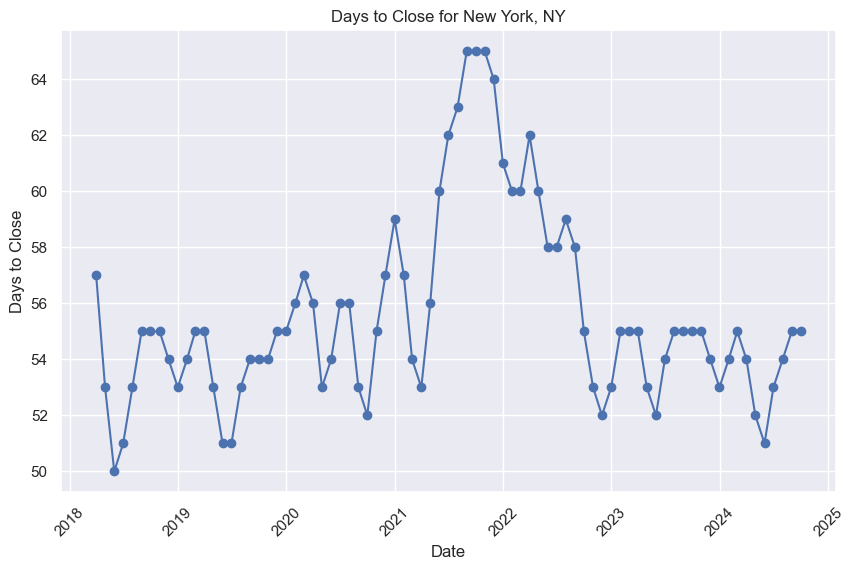

In [108]:
# Filter data for one region (e.g., 'New York, NY')
region_data = mean_days_to_close_melted[mean_days_to_close_melted['RegionID'] == 394913]

# Plot the timeline for this region
plt.figure(figsize=(10, 6))
plt.plot(region_data['Date'], region_data['DaysToClose'], marker='o', linestyle='-', color='b')
plt.title('Days to Close for New York, NY')
plt.xlabel('Date')
plt.ylabel('Days to Close')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

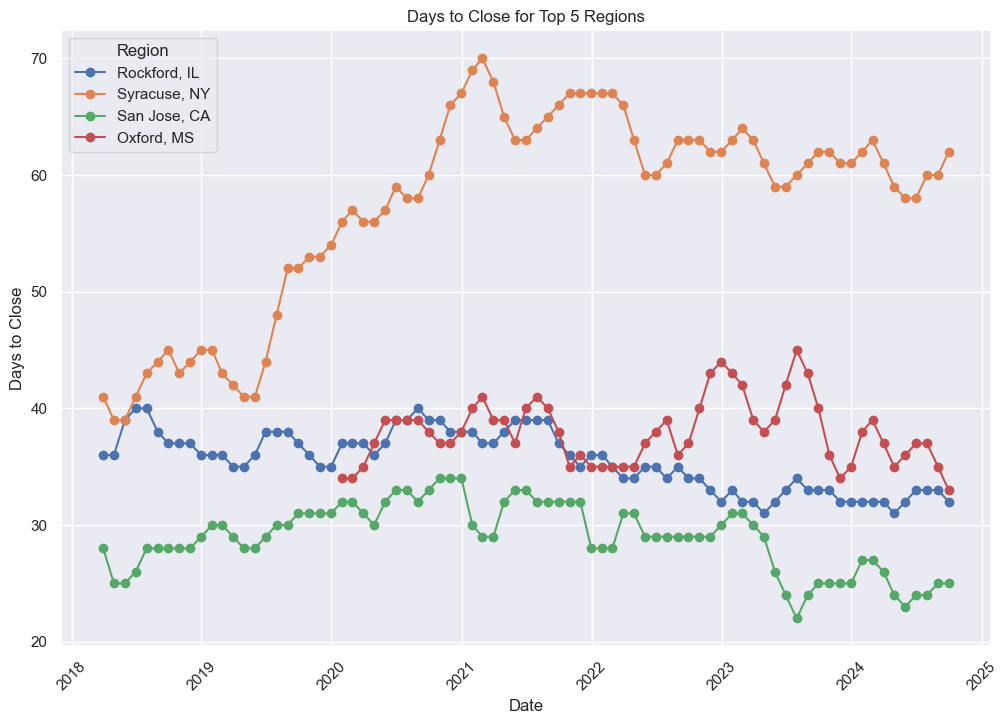

In [109]:
# Trends among our top ten regions
regions_to_plot = top_25_regions.head(5)['RegionID']
multiple_region_data = mean_days_to_close_melted[mean_days_to_close_melted['RegionID'].isin(regions_to_plot)].reset_index()

# Plot the timelines for multiple regions
plt.figure(figsize=(12, 8))

for region in regions_to_plot:
    region_data = multiple_region_data[multiple_region_data['RegionID'] == region]
    if not region_data.empty:
        plt.plot(region_data['Date'], region_data['DaysToClose'], marker='o', label=region_data['RegionName'].iloc[0])

plt.title('Days to Close for Top 5 Regions')
plt.xlabel('Date')
plt.ylabel('Days to Close')
plt.legend(title='Region')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

Analysis for Days-to-Pending and Days-to-Close reveals that we would hold the property for 3-5 months following the listing on the market. It also shows that some regions have little or no data for those two parameters, so we will use the mean to fill those gaps where they exist.

## How Much to Invest
With financing in the picture, we've the ability to invest in properties with value of $20 millions, but we've to keep cash around. Our investor is willing to invest \\$12 million, so let's discuss strategy. 

### Use 40% Equity-to-Value
For each property, we will put 40% down payment and take a mortgage for the remaining balance. We will take [interest-only mortgage loans](https://www.chase.com/personal/mortgage/education/financing-a-home/what-is-interest-only-mortgage) which works better for our investor use-case. Interest-Only mortgage means we will pay interest only and no payment toward the principle for x years. This makes our monthly payment smaller since we're holding the unit for a short period. Interest-only loans should offer a better APR. [We will assume interest rate of 6.558% as indicated on rate.com as of Dec 10th, 2024](https://www.rate.com/mortgage-rates).

### Keep Third of Our Cash
How much cash to keep on hand can be a complex calculation. We will try to simplify it and assume a 33.33% is enough to cover our expenses while we hold the properties. This means we can put $8 million toward equity.

## Buying the Properties
Time to buy our properties. We will make couple assumptions here to simplify the math:
- All properties are bought by Dec 31st, 2024.
- Zillow Home Value Index(ZHVI) accurately reflects purchase prices, and the index for October 31st, 2024 holds true for all of our purchases.
- We will assume the only initial cost of the purchase is reflected in ZHVI, so no taxes or buyer fee for example.

Above we calculated the MoM change for single family homes value in `single_home_values_final` This allows us to find the best regions with historically high MoM rates. We also want to utilize Zillow Home Value Forecast for our intended date to list the properties on the market, 2025-10-31. To acquire the best of the two, we will get the top 50 regions with MoM change in the past year and reduce the list based on the Zillow forecast.

In [110]:
home_value_forecast = pd.read_csv('./data/forecast_metro.csv')
home_value_forecast.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,BaseDate,2024-11-30,2025-01-31,2025-10-31
0,102001,0,United States,country,NaN,2024-10-31,-0.4,-1.0,2.8
1,394913,1,"New York, NY",msa,NY,2024-10-31,-0.5,-0.8,1.1
2,753899,2,"Los Angeles, CA",msa,CA,2024-10-31,-0.7,-0.8,2.2
3,394463,3,"Chicago, IL",msa,IL,2024-10-31,-1.0,-2.2,0.7
4,394514,4,"Dallas, TX",msa,TX,2024-10-31,-1.1,-2.1,1.3


In [111]:
# Melt the data and only keep the YoY projection for 2025-10-31
home_value_forecast = util.melt_zillow_dataset(home_value_forecast, id_fields=['RegionID'], fields_to_drop=['SizeRank', 'RegionName', 'RegionType', 'StateName', 'BaseDate', '2024-11-30', '2025-01-31'], date_col='ForecastDate', value_col='ForecastChange')
home_value_forecast.head()

,RegionID,ForecastDate,ForecastChange
0,394913,2025-10-31,1.1
1,753899,2025-10-31,2.2
2,394463,2025-10-31,0.7
3,394514,2025-10-31,1.3
4,394692,2025-10-31,0.8


In [112]:
top_50_regions = util.get_top_regions_by_mom_change(single_home_values_final, top_n=50)
regions_to_buy_from = top_50_regions.merge(home_value_forecast, on=['RegionID'], how='inner')
regions_to_buy_from.head()

,RegionID,RegionName,MoM_Change,ForecastDate,ForecastChange
0,395033,"Rockford, IL",0.813178,2025-10-31,3.4
1,395143,"Syracuse, NY",0.804417,2025-10-31,3.9
2,395059,"San Jose, CA",0.786331,2025-10-31,0.0
3,394951,"Oxford, MS",0.764303,2025-10-31,3.7
4,394397,"Blytheville, AR",0.744494,2025-10-31,-0.8


In [113]:
# As we see above using MoM change may be at odds with Zillow projections for the same regions.
# Let's drop any region with negative forecast and sort them by the forecast change in value
regions_to_buy_from = regions_to_buy_from[regions_to_buy_from['ForecastChange'] > 0]
regions_to_buy_from = regions_to_buy_from.sort_values(by='ForecastChange', ascending=False)
regions_to_buy_from.head()

,RegionID,RegionName,MoM_Change,ForecastDate,ForecastChange
48,395154,"Thomaston, GA",0.569473,2025-10-31,7.8
8,394556,"Edwards, CO",0.716400,2025-10-31,7.1
26,753921,"Steamboat Springs, CO",0.612016,2025-10-31,6.8
23,394348,"Atlantic City, NJ",0.617399,2025-10-31,6.6
20,394748,"Kingston, NY",0.646099,2025-10-31,6.1


In [114]:
# Let's add the purchase price to our data frame. Following our assumption above, we're using the 2024-10-31 estimation 
target_date = pd.to_datetime('2024-10-31')

# Filter single_home_values_final for the specified EestimationDate
filtered_home_values = single_home_values_final[single_home_values_final['EestimationDate'] == target_date]

regions_to_buy_from = regions_to_buy_from.merge(filtered_home_values[['RegionID', 'HomeValue']], on=['RegionID'], how='left')
regions_to_buy_from.rename(columns={'HomeValue': 'PurchaseCost'}, inplace=True)
regions_to_buy_from.head()

,RegionID,RegionName,MoM_Change,ForecastDate,ForecastChange,PurchaseCost
0,395154,"Thomaston, GA",0.569473,2025-10-31,7.8,1.747448e+05
1,394556,"Edwards, CO",0.716400,2025-10-31,7.1,1.535533e+06
2,753921,"Steamboat Springs, CO",0.612016,2025-10-31,6.8,1.312827e+06
3,394348,"Atlantic City, NJ",0.617399,2025-10-31,6.6,3.890825e+05
4,394748,"Kingston, NY",0.646099,2025-10-31,6.1,4.190990e+05


In [115]:
# Only buy from top 5 regions with the best projected appreciation
bought_properties = regions_to_buy_from.head().copy()

# Budget available (in dollars). 40% cash are $9 million and the rest is financed
budget = (8_000_000 / 0.4)

# Track total payments
total_payments = 0

# Initialize a new column for the number of properties purchased per region
bought_properties['NumberOfProperties'] = 0

# Loop through the properties until the budget is exhausted
while total_payments <= budget:
    for index, row in bought_properties.iterrows():
        if total_payments + row['PurchaseCost'] <= budget:
            bought_properties.loc[index, 'NumberOfProperties'] = row['NumberOfProperties'] + 1
            total_payments += row['PurchaseCost']
        else:
            break
    else:
        continue
    break

# Above loop will break before we hit the budget, let's see if the remaining amount can afford us a few cheap properties
while bought_properties['PurchaseCost'].min() < (budget - total_payments):
    index = bought_properties['PurchaseCost'].idxmin()
    total_payments += bought_properties.loc[index, 'PurchaseCost']
    bought_properties.loc[index, 'NumberOfProperties'] = bought_properties.loc[index,'NumberOfProperties'] + 1

# Result: The properties we can afford and the total payments used
print(f"Total budget: ${budget:,.2f}")
print(f"Total payments used: ${total_payments:,.2f}")
print(f"Remaining budget: ${budget - total_payments:,.2f}")
bought_properties.head()

Total budget: $20,000,000.00
Total payments used: $19,855,410.80
Remaining budget: $144,589.20


,RegionID,RegionName,MoM_Change,ForecastDate,ForecastChange,PurchaseCost,NumberOfProperties
0,395154,"Thomaston, GA",0.569473,2025-10-31,7.8,1.747448e+05,9
1,394556,"Edwards, CO",0.716400,2025-10-31,7.1,1.535533e+06,5
2,753921,"Steamboat Springs, CO",0.612016,2025-10-31,6.8,1.312827e+06,5
3,394348,"Atlantic City, NJ",0.617399,2025-10-31,6.6,3.890825e+05,5
4,394748,"Kingston, NY",0.646099,2025-10-31,6.1,4.190990e+05,5


## Calculate Total Investment & Net Profit
Let's calculate all costs associated with our investment.

### Purchase & Financing Costs
Purchase cost is how much we put down out of our pocket. Financing cost is how much interest we're paying.

In [116]:
# Now, let's add columns for the cost of purchase
bought_properties['DownPayments'] = (bought_properties['PurchaseCost'] * .40) * bought_properties['NumberOfProperties'] 
bought_properties['LoanTotal'] = (bought_properties['PurchaseCost'] * .60) * bought_properties['NumberOfProperties']

# With interest rate of 6.558%, calculate monthly interest
bought_properties['InterestPerMonth'] = bought_properties['LoanTotal'] * (.06558/12)

print(f"Total Purchase Costs: ${bought_properties['DownPayments'].sum():,.2f}")
print(f"Financing Costs per Month: ${bought_properties['InterestPerMonth'].sum():,.2f}")
bought_properties.head()

Total Purchase Costs: $7,942,164.32
Financing Costs per Month: $65,105.89


,RegionID,RegionName,MoM_Change,ForecastDate,ForecastChange,PurchaseCost,NumberOfProperties,DownPayments,LoanTotal,InterestPerMonth
0,395154,"Thomaston, GA",0.569473,2025-10-31,7.8,1.747448e+05,9,6.290814e+05,9.436221e+05,5156.894582
1,394556,"Edwards, CO",0.716400,2025-10-31,7.1,1.535533e+06,5,3.071065e+06,4.606598e+06,25175.057368
2,753921,"Steamboat Springs, CO",0.612016,2025-10-31,6.8,1.312827e+06,5,2.625655e+06,3.938482e+06,21523.804125
3,394348,"Atlantic City, NJ",0.617399,2025-10-31,6.6,3.890825e+05,5,7.781650e+05,1.167247e+06,6379.007478
4,394748,"Kingston, NY",0.646099,2025-10-31,6.1,4.190990e+05,5,8.381980e+05,1.257297e+06,6871.128449


### Holding Costs
To calculate holding costs, we need to know how long we will own the property. Based on a [study from BankRate](https://www.bankrate.com/mortgages/hidden-costs-of-homeownership-study/), the average cost of owning a single family home soared to $18,000 in 2024. We will assume a fixed amount of \\$18,000 per year. 

To calculate how long we will own the properties, we will need the mean Days-to-Pending and Days-to-Close. We assume that we will list the properties on the market for sale on October 31st, 2025.

In [117]:
# Create temp data frame with days to pending and days to close to calculate sale date
sale_data = bought_properties.merge(mean_days_to_pending_melted.groupby('RegionID')['DaysToPending'].mean(), on=['RegionID'], how='left')
# Fill using mean if any is missing
sale_data.fillna(sale_data['DaysToPending'].mean(), inplace=True)

sale_data = sale_data.merge(mean_days_to_close_melted.groupby('RegionID')['DaysToClose'].mean(), on=['RegionID'], how='left')
# Fill using mean if any is missing
sale_data.fillna(sale_data['DaysToClose'].mean(), inplace=True)
sale_data.head()

,RegionID,RegionName,MoM_Change,ForecastDate,ForecastChange,PurchaseCost,NumberOfProperties,DownPayments,LoanTotal,InterestPerMonth,DaysToPending,DaysToClose
0,395154,"Thomaston, GA",0.569473,2025-10-31,7.8,1.747448e+05,9,6.290814e+05,9.436221e+05,5156.894582,51.000000,42.444255
1,394556,"Edwards, CO",0.716400,2025-10-31,7.1,1.535533e+06,5,3.071065e+06,4.606598e+06,25175.057368,64.759259,41.134615
2,753921,"Steamboat Springs, CO",0.612016,2025-10-31,6.8,1.312827e+06,5,2.625655e+06,3.938482e+06,21523.804125,56.000000,38.250000
3,394348,"Atlantic City, NJ",0.617399,2025-10-31,6.6,3.890825e+05,5,7.781650e+05,1.167247e+06,6379.007478,68.512500,40.164557
4,394748,"Kingston, NY",0.646099,2025-10-31,6.1,4.190990e+05,5,8.381980e+05,1.257297e+06,6871.128449,83.387500,50.227848


In [118]:
# Calculate the sale date. Starting from the list date
market_list_date = pd.to_datetime('2025-10-31')
sale_data['SaleDate'] = market_list_date + pd.to_timedelta(sale_data['DaysToPending'] + sale_data['DaysToClose'], unit='day')
sale_data.head()

,RegionID,RegionName,MoM_Change,ForecastDate,ForecastChange,PurchaseCost,NumberOfProperties,DownPayments,LoanTotal,InterestPerMonth,DaysToPending,DaysToClose,SaleDate
0,395154,"Thomaston, GA",0.569473,2025-10-31,7.8,1.747448e+05,9,6.290814e+05,9.436221e+05,5156.894582,51.000000,42.444255,2026-02-01 10:39:43.641674778
1,394556,"Edwards, CO",0.716400,2025-10-31,7.1,1.535533e+06,5,3.071065e+06,4.606598e+06,25175.057368,64.759259,41.134615,2026-02-13 21:27:10.769230765
2,753921,"Steamboat Springs, CO",0.612016,2025-10-31,6.8,1.312827e+06,5,2.625655e+06,3.938482e+06,21523.804125,56.000000,38.250000,2026-02-02 06:00:00.000000000
3,394348,"Atlantic City, NJ",0.617399,2025-10-31,6.6,3.890825e+05,5,7.781650e+05,1.167247e+06,6379.007478,68.512500,40.164557,2026-02-16 16:14:57.721518985
4,394748,"Kingston, NY",0.646099,2025-10-31,6.1,4.190990e+05,5,8.381980e+05,1.257297e+06,6871.128449,83.387500,50.227848,2026-03-13 14:46:06.075949365


In [119]:
# We own the properties starting in first day of 2025.
purchase_period = pd.to_datetime('2025-01-01').to_period('M')
sale_data['HoldingMonths'] = (sale_data['SaleDate'].dt.to_period('M') - purchase_period).apply(lambda x: x.n)

# Holding cost per month
sale_data['HoldingCostsPerMonth'] = (18_000/12) * sale_data['NumberOfProperties']
print(f"Holding Costs per Month: ${sale_data['HoldingCostsPerMonth'].sum():,.2f}")
sale_data.head()

Holding Costs per Month: $43,500.00


,RegionID,RegionName,MoM_Change,ForecastDate,ForecastChange,PurchaseCost,NumberOfProperties,DownPayments,LoanTotal,InterestPerMonth,DaysToPending,DaysToClose,SaleDate,HoldingMonths,HoldingCostsPerMonth
0,395154,"Thomaston, GA",0.569473,2025-10-31,7.8,1.747448e+05,9,6.290814e+05,9.436221e+05,5156.894582,51.000000,42.444255,2026-02-01 10:39:43.641674778,13,13500.0
1,394556,"Edwards, CO",0.716400,2025-10-31,7.1,1.535533e+06,5,3.071065e+06,4.606598e+06,25175.057368,64.759259,41.134615,2026-02-13 21:27:10.769230765,13,7500.0
2,753921,"Steamboat Springs, CO",0.612016,2025-10-31,6.8,1.312827e+06,5,2.625655e+06,3.938482e+06,21523.804125,56.000000,38.250000,2026-02-02 06:00:00.000000000,13,7500.0
3,394348,"Atlantic City, NJ",0.617399,2025-10-31,6.6,3.890825e+05,5,7.781650e+05,1.167247e+06,6379.007478,68.512500,40.164557,2026-02-16 16:14:57.721518985,13,7500.0
4,394748,"Kingston, NY",0.646099,2025-10-31,6.1,4.190990e+05,5,8.381980e+05,1.257297e+06,6871.128449,83.387500,50.227848,2026-03-13 14:46:06.075949365,14,7500.0


### Renovation Costs
For renovations, investors only spend on upgrades to recoup resale value increase. We will assume our investor is spending around 10% of the property value on renovation. Additionally, we will guide our investor on which renovations to do using data from [the Journal for Light Construction data](https://www.jlconline.com/cost-vs-value/2024/) in 2024. We will assume recoup rate of 125% of the renovations costs in resale value.

In [120]:
# Using 10% of the unit value when buying it to calculate the renovation costs per region
sale_data['RenovationCost'] = sale_data['PurchaseCost'] * 0.1
sale_data['ResaleValueIncrease'] = sale_data['RenovationCost'] * 1.25
print(f"Total Renovation Costs: ${(sale_data['RenovationCost'] * sale_data['NumberOfProperties']).sum():,.2f}")
print(f"Total Resale Value Increase: ${(sale_data['ResaleValueIncrease']  * sale_data['NumberOfProperties']).sum():,.2f}")
sale_data[['RegionID', 'RegionName', 'PurchaseCost', 'NumberOfProperties', 'RenovationCost', 'ResaleValueIncrease']].head()

Total Renovation Costs: $1,985,541.08
Total Resale Value Increase: $2,481,926.35


,RegionID,RegionName,PurchaseCost,NumberOfProperties,RenovationCost,ResaleValueIncrease
0,395154,"Thomaston, GA",1.747448e+05,9,17474.482674,21843.103343
1,394556,"Edwards, CO",1.535533e+06,5,153553.262385,191941.577982
2,753921,"Steamboat Springs, CO",1.312827e+06,5,131282.733302,164103.416628
3,394348,"Atlantic City, NJ",3.890825e+05,5,38908.249331,48635.311664
4,394748,"Kingston, NY",4.190990e+05,5,41909.902101,52387.377626


### Sale Price & Costs
Now, it's time to calculate our sale price and selling costs as our last two parameters. We will assume selling costs us 3% of the ask price.

In [121]:
sale_data['SalePrice'] = sale_data['PurchaseCost'] + (sale_data['PurchaseCost'] * (sale_data['ForecastChange']/100)) + sale_data['ResaleValueIncrease']
sale_data['SellingCosts'] = sale_data['SalePrice'] * 0.03 * sale_data['NumberOfProperties']
print(f"Total Selling Costs: ${sale_data['SellingCosts'].sum():,.2f}")
sale_data.head()

Total Selling Costs: $711,231.17


,RegionID,RegionName,MoM_Change,ForecastDate,ForecastChange,PurchaseCost,NumberOfProperties,DownPayments,LoanTotal,InterestPerMonth,DaysToPending,DaysToClose,SaleDate,HoldingMonths,HoldingCostsPerMonth,RenovationCost,ResaleValueIncrease,SalePrice,SellingCosts
0,395154,"Thomaston, GA",0.569473,2025-10-31,7.8,1.747448e+05,9,6.290814e+05,9.436221e+05,5156.894582,51.000000,42.444255,2026-02-01 10:39:43.641674778,13,13500.0,17474.482674,21843.103343,2.102180e+05,56758.867175
1,394556,"Edwards, CO",0.716400,2025-10-31,7.1,1.535533e+06,5,3.071065e+06,4.606598e+06,25175.057368,64.759259,41.134615,2026-02-13 21:27:10.769230765,13,7500.0,153553.262385,191941.577982,1.836497e+06,275474.552720
2,753921,"Steamboat Springs, CO",0.612016,2025-10-31,6.8,1.312827e+06,5,2.625655e+06,3.938482e+06,21523.804125,56.000000,38.250000,2026-02-02 06:00:00.000000000,13,7500.0,131282.733302,164103.416628,1.566203e+06,234930.451245
3,394348,"Atlantic City, NJ",0.617399,2025-10-31,6.6,3.890825e+05,5,7.781650e+05,1.167247e+06,6379.007478,68.512500,40.164557,2026-02-16 16:14:57.721518985,13,7500.0,38908.249331,48635.311664,4.633972e+05,69509.587430
4,394748,"Kingston, NY",0.646099,2025-10-31,6.1,4.190990e+05,5,8.381980e+05,1.257297e+06,6871.128449,83.387500,50.227848,2026-03-13 14:46:06.075949365,14,7500.0,41909.902101,52387.377626,4.970514e+05,74557.715837


### Calculate Total Investment & Net Profit
Let's now calculate our total investment and net profit. 

**Total Investment = Down Payments + Renovation Costs + Holding Costs + Financing Costs + Selling Costs**


**Net Profit = Total Sales - Total Investment - Loans Repayment**

Total Investment: $12,065,184.30


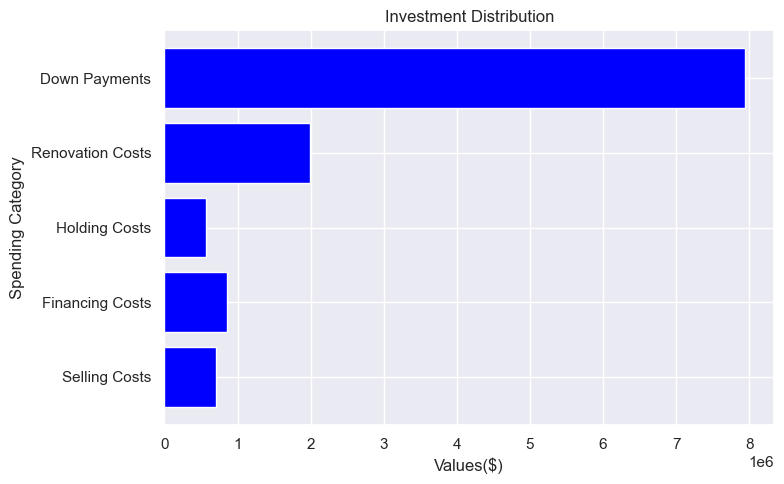

In [122]:
# Down payments
total_investment = sale_data['DownPayments'].sum() 
# Renovation costs
total_investment += (sale_data['RenovationCost'] * sale_data['NumberOfProperties']).sum()
# Holding costs
total_investment += (sale_data['HoldingCostsPerMonth'] * sale_data['HoldingMonths']).sum()
# Financing costs
total_investment += (sale_data['InterestPerMonth'] * sale_data['HoldingMonths']).sum()
# Selling costs
total_investment += sale_data['SellingCosts'].sum()

print(f"Total Investment: ${total_investment:,.2f}")

# Data for the bar chart
categories = ['Down Payments', 'Renovation Costs', 'Holding Costs', 'Financing Costs', 'Selling Costs']
values = [sale_data['DownPayments'].sum(),
          (sale_data['RenovationCost'] * sale_data['NumberOfProperties']).sum(),
          (sale_data['HoldingCostsPerMonth'] * sale_data['HoldingMonths']).sum(),
          (sale_data['InterestPerMonth'] * sale_data['HoldingMonths']).sum(),
          sale_data['SellingCosts'].sum()]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.barh(categories, values, color='blue')

# Customize labels and title
plt.xlabel('Values($)')
plt.ylabel('Spending Category')
plt.title('Investment Distribution')
plt.gca().invert_yaxis()
plt.tight_layout()
# Display the chart
plt.show()

Based on the total investment above, we went slightly over our budget of $12 million. This means that our initial estimation of keeping third of our cash falls short of the actual expenses. We can easily change the number above, but we will continue with our analysis. 

In [123]:
total_sales = (sale_data['SalePrice'] * sale_data['NumberOfProperties']).sum()
total_loan_repayment = sale_data['LoanTotal'].sum()
net_profit = total_sales - total_investment - total_loan_repayment
print(f"Total Sales: ${total_sales:,.2f}")
print(f"Total Loan Repayment: ${total_loan_repayment:,.2f}")
print(f"Net Profit: ${net_profit:,.2f}")

Total Sales: $23,707,705.81
Total Loan Repayment: $11,913,246.48
Net Profit: $-270,724.96


## Return on Investment
Our return on investment is simply the ratio of net profit to total investment. The numbers already tell us that we're losing money. Let's see this in terms of ROI

In [124]:
roi = (net_profit / total_investment) * 100
print(f"Return on Investment: {roi:,.2f}%")

Return on Investment: -2.24%


## Conclusion
Flipping properties might not be the best investment at the current market. This is driven by [multiple factors](https://www.nasdaq.com/articles/now-good-time-invest-real-estate) including:
* High interest rate. Interest rate was the our highest expense while holding the properties.
* Low affordability. Many now are unable to afford buying property, so they opt to renting rather than buying.

If we can offset the financing and holding costs by for example renting the properties, this investment would work very well. Otherwise, even at 7% YoY appreciation, flipping homes may not be a good investment.